<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [669]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [670]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [506]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Functions

In [598]:
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

def build_corr_table(df, x, target, title, method='pearson'):
    """Builds a concise correlation table for the given feature target across all subgroups."""
    table = pd.DataFrame()
    for group in groups:
        if group == 'all':
            sel_df = df
        else:
            sel_df = df[df['baseline_cluster']  == group]
        corr_df = pg.pairwise_corr(sel_df, columns=[sel_agg_cols, [target]], nan_policy='pairwise', padjust="fdr_bh", method=method)
        corr_df['group'] = group
        #print(corr_df.head())
        corr_df = corr_df[corr_df['X'] == x]
        table = table.append(corr_df[['group', 'n', 'r', 'p-corr', 'p-adjust']])
        
    table = table.reset_index(drop=True)
        
    return table.style.set_caption(title)


def display_all_corr(corr_df, cols, target, alpha=0.1, method="pearson"):
    """Displays all correlations for every feature in cols against target. 
    
    Sorts by feature group.
    Also stars the significant p-values.
    
    Args:
        corr_df (pd.df): pandas correlation frame
        cols (list): list of feature columns
        target (str): the target survey column name
        alpha (float): the specified significance level
        method (str): whether "pearson" or "spearman" correlations
    
    Returns:
        pd.df: styled correlation matrix
    
    """
    p_val_format = "{:0.4f}"
    style_p_val = lambda x: "{:0.4f}".format(x) + "*" if x < alpha else "{:0.4f}".format(x)
    pair_corr_df = pg.pairwise_corr(corr_df, columns=[cols, [target]], method=method, padjust="fdr_bh")
    pair_corr_df['p-corr'] = pair_corr_df['p-corr'].apply(f)
    pair_corr_df['p-unc'] = pair_corr_df['p-unc'].apply(f)

    title = method + ", alpha < {}".format(alpha)
    display(pair_corr_df[['X', 'Y', 'n', 'r', 'p-unc', 'p-corr', 'p-adjust']].style.set_caption(title))

# Load Data

In [521]:
gad_spin_corr = pd.read_pickle("wave1_features/gad_spin_corr.df")
rev_gad_spin_corr = pd.read_pickle("wave1_features/rev_gad_spin_corr.df")

phq_corr = pd.read_pickle("wave1_features/phq_corr.df")
rev_phq_corr = pd.read_pickle("wave1_features/rev_phq_corr.df")

## Plots Over Time

### PHQ

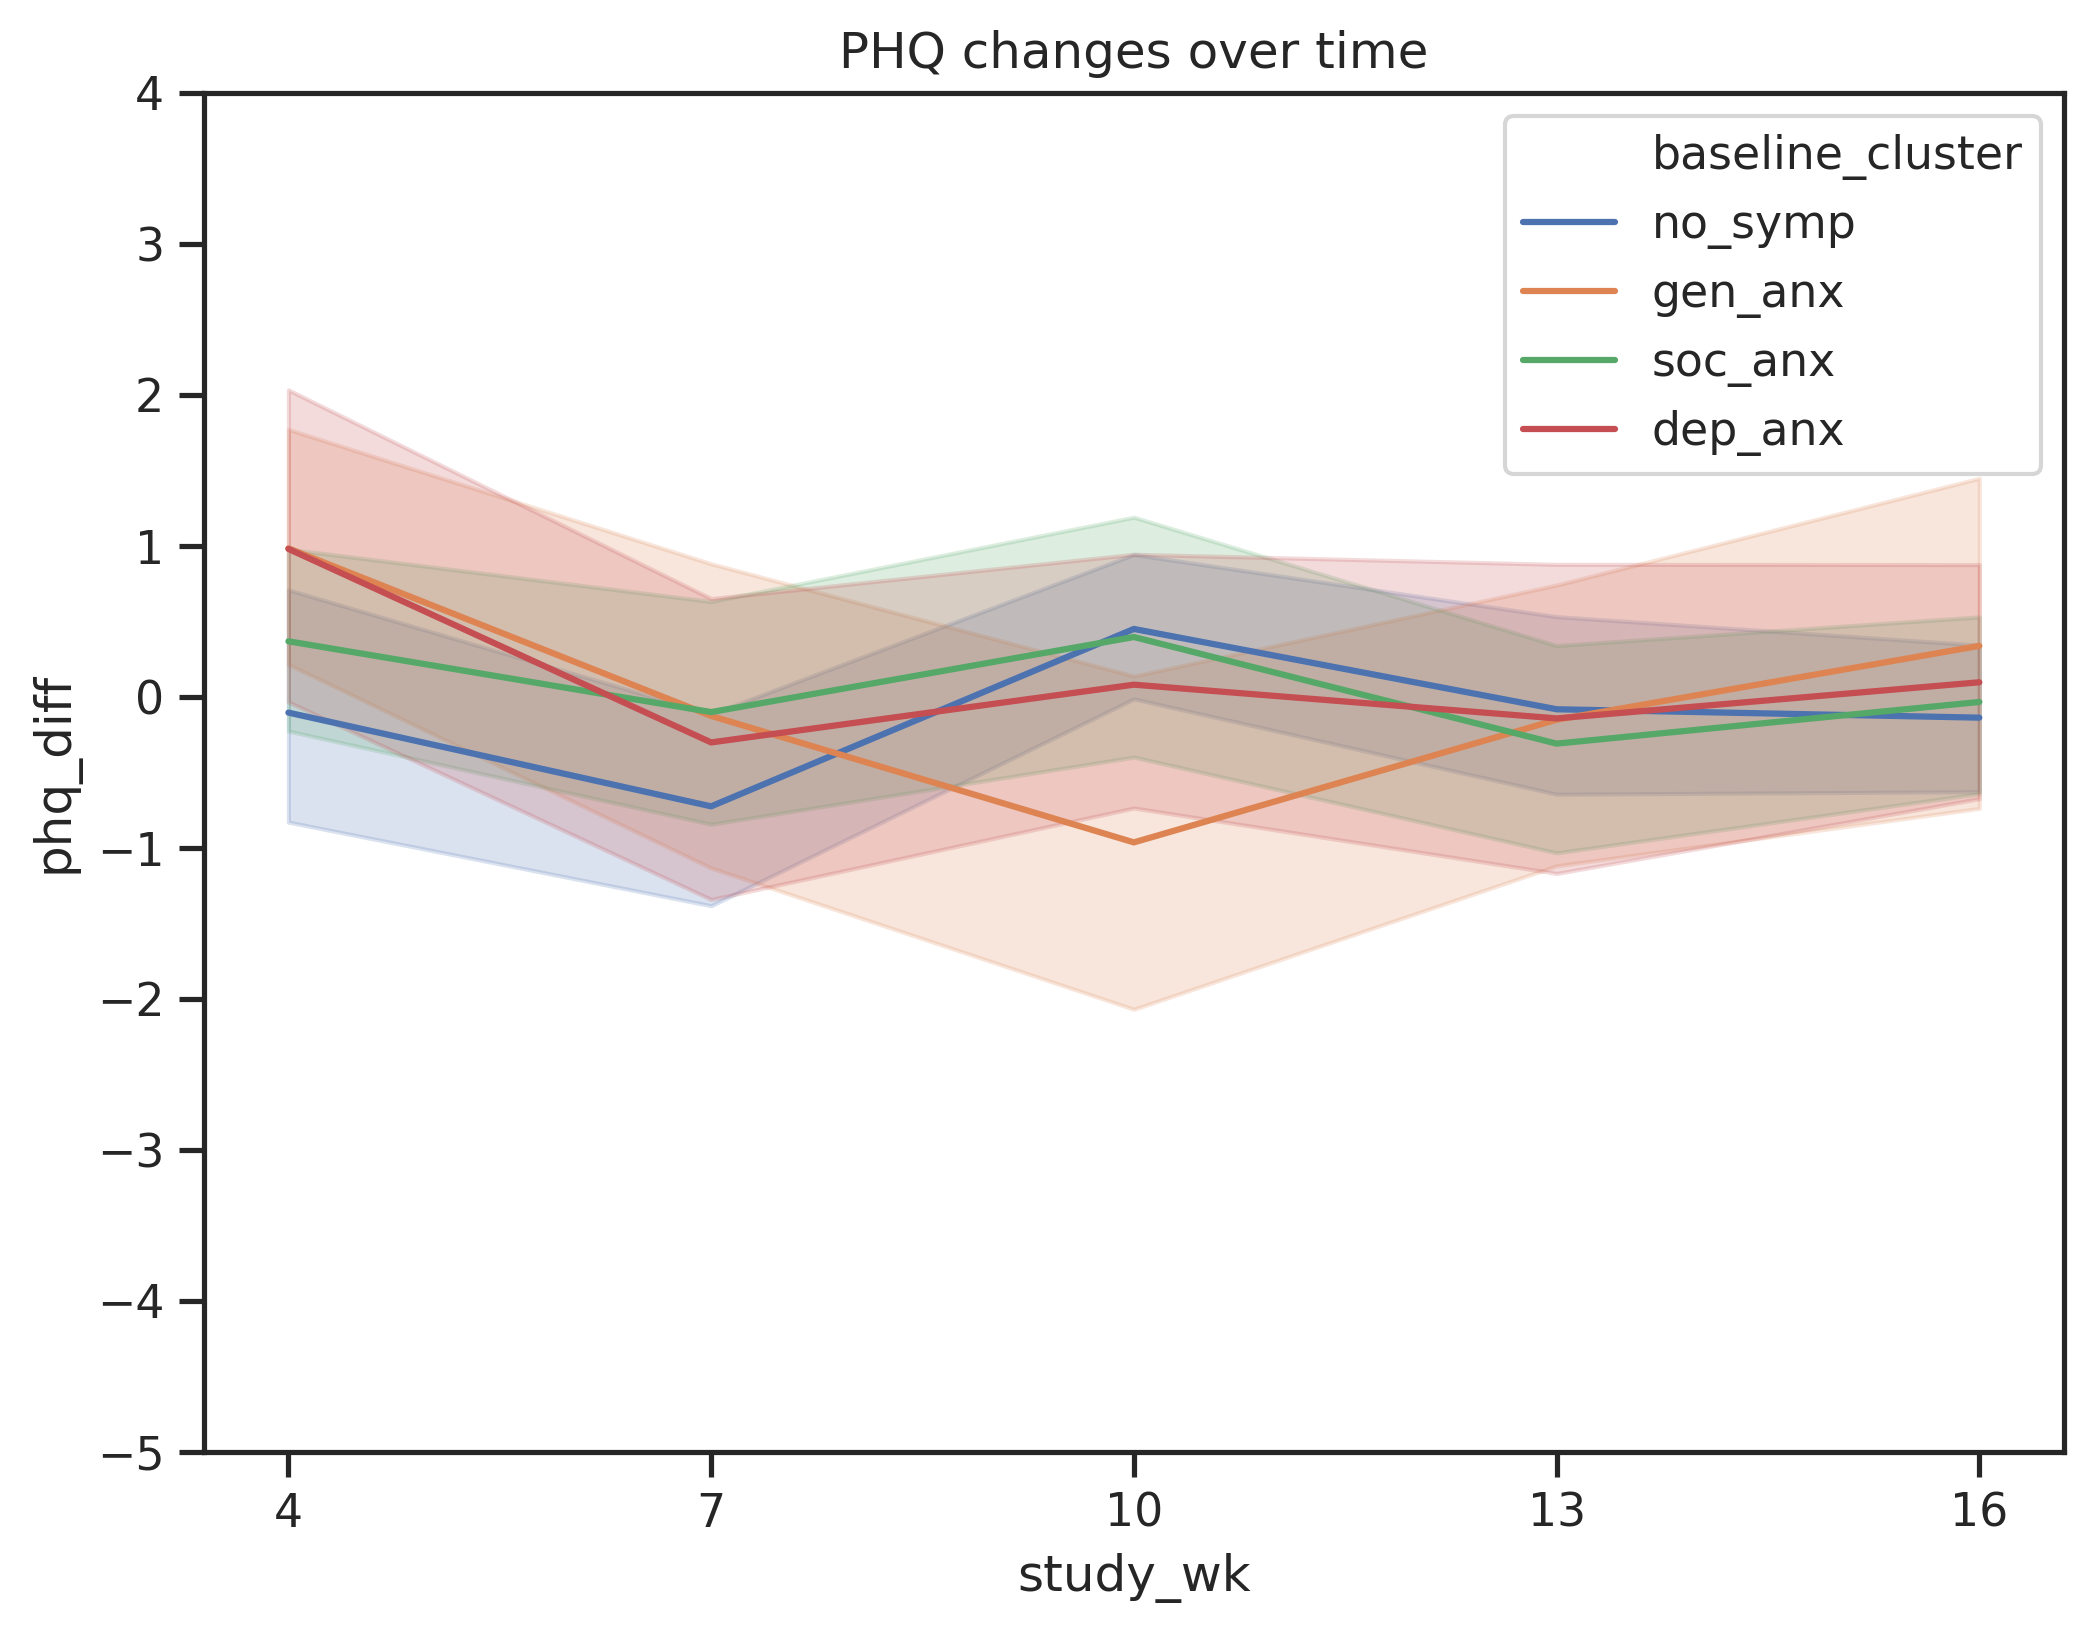

In [522]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

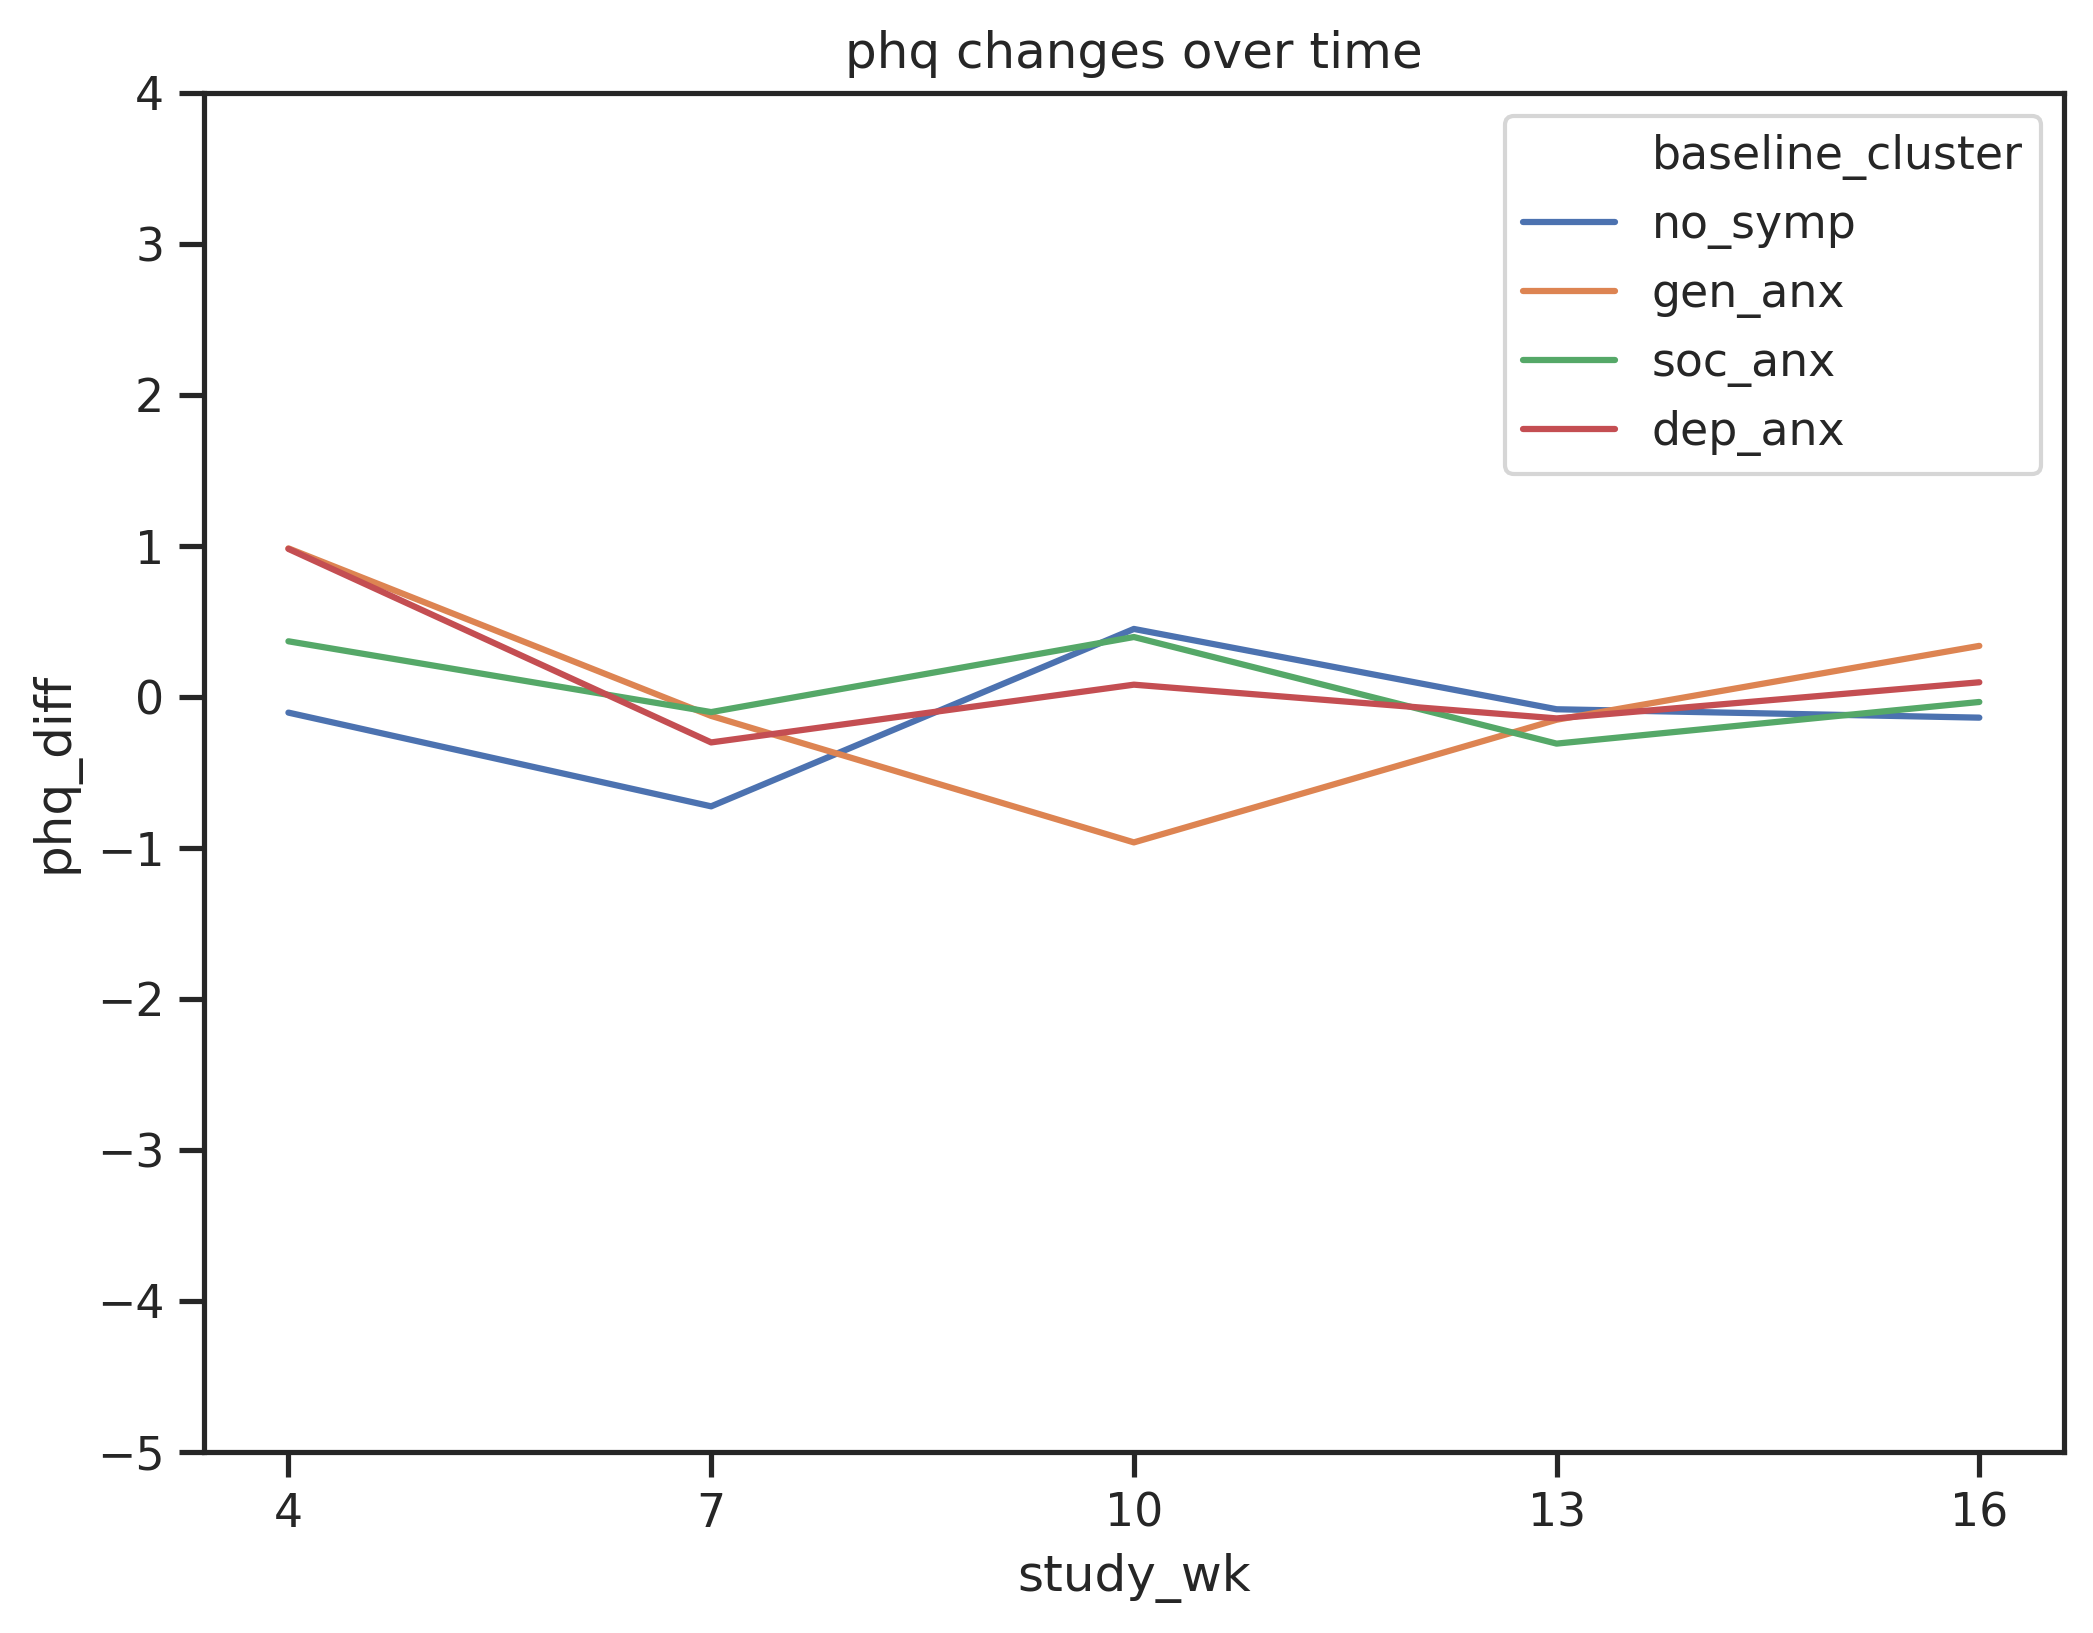

In [523]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

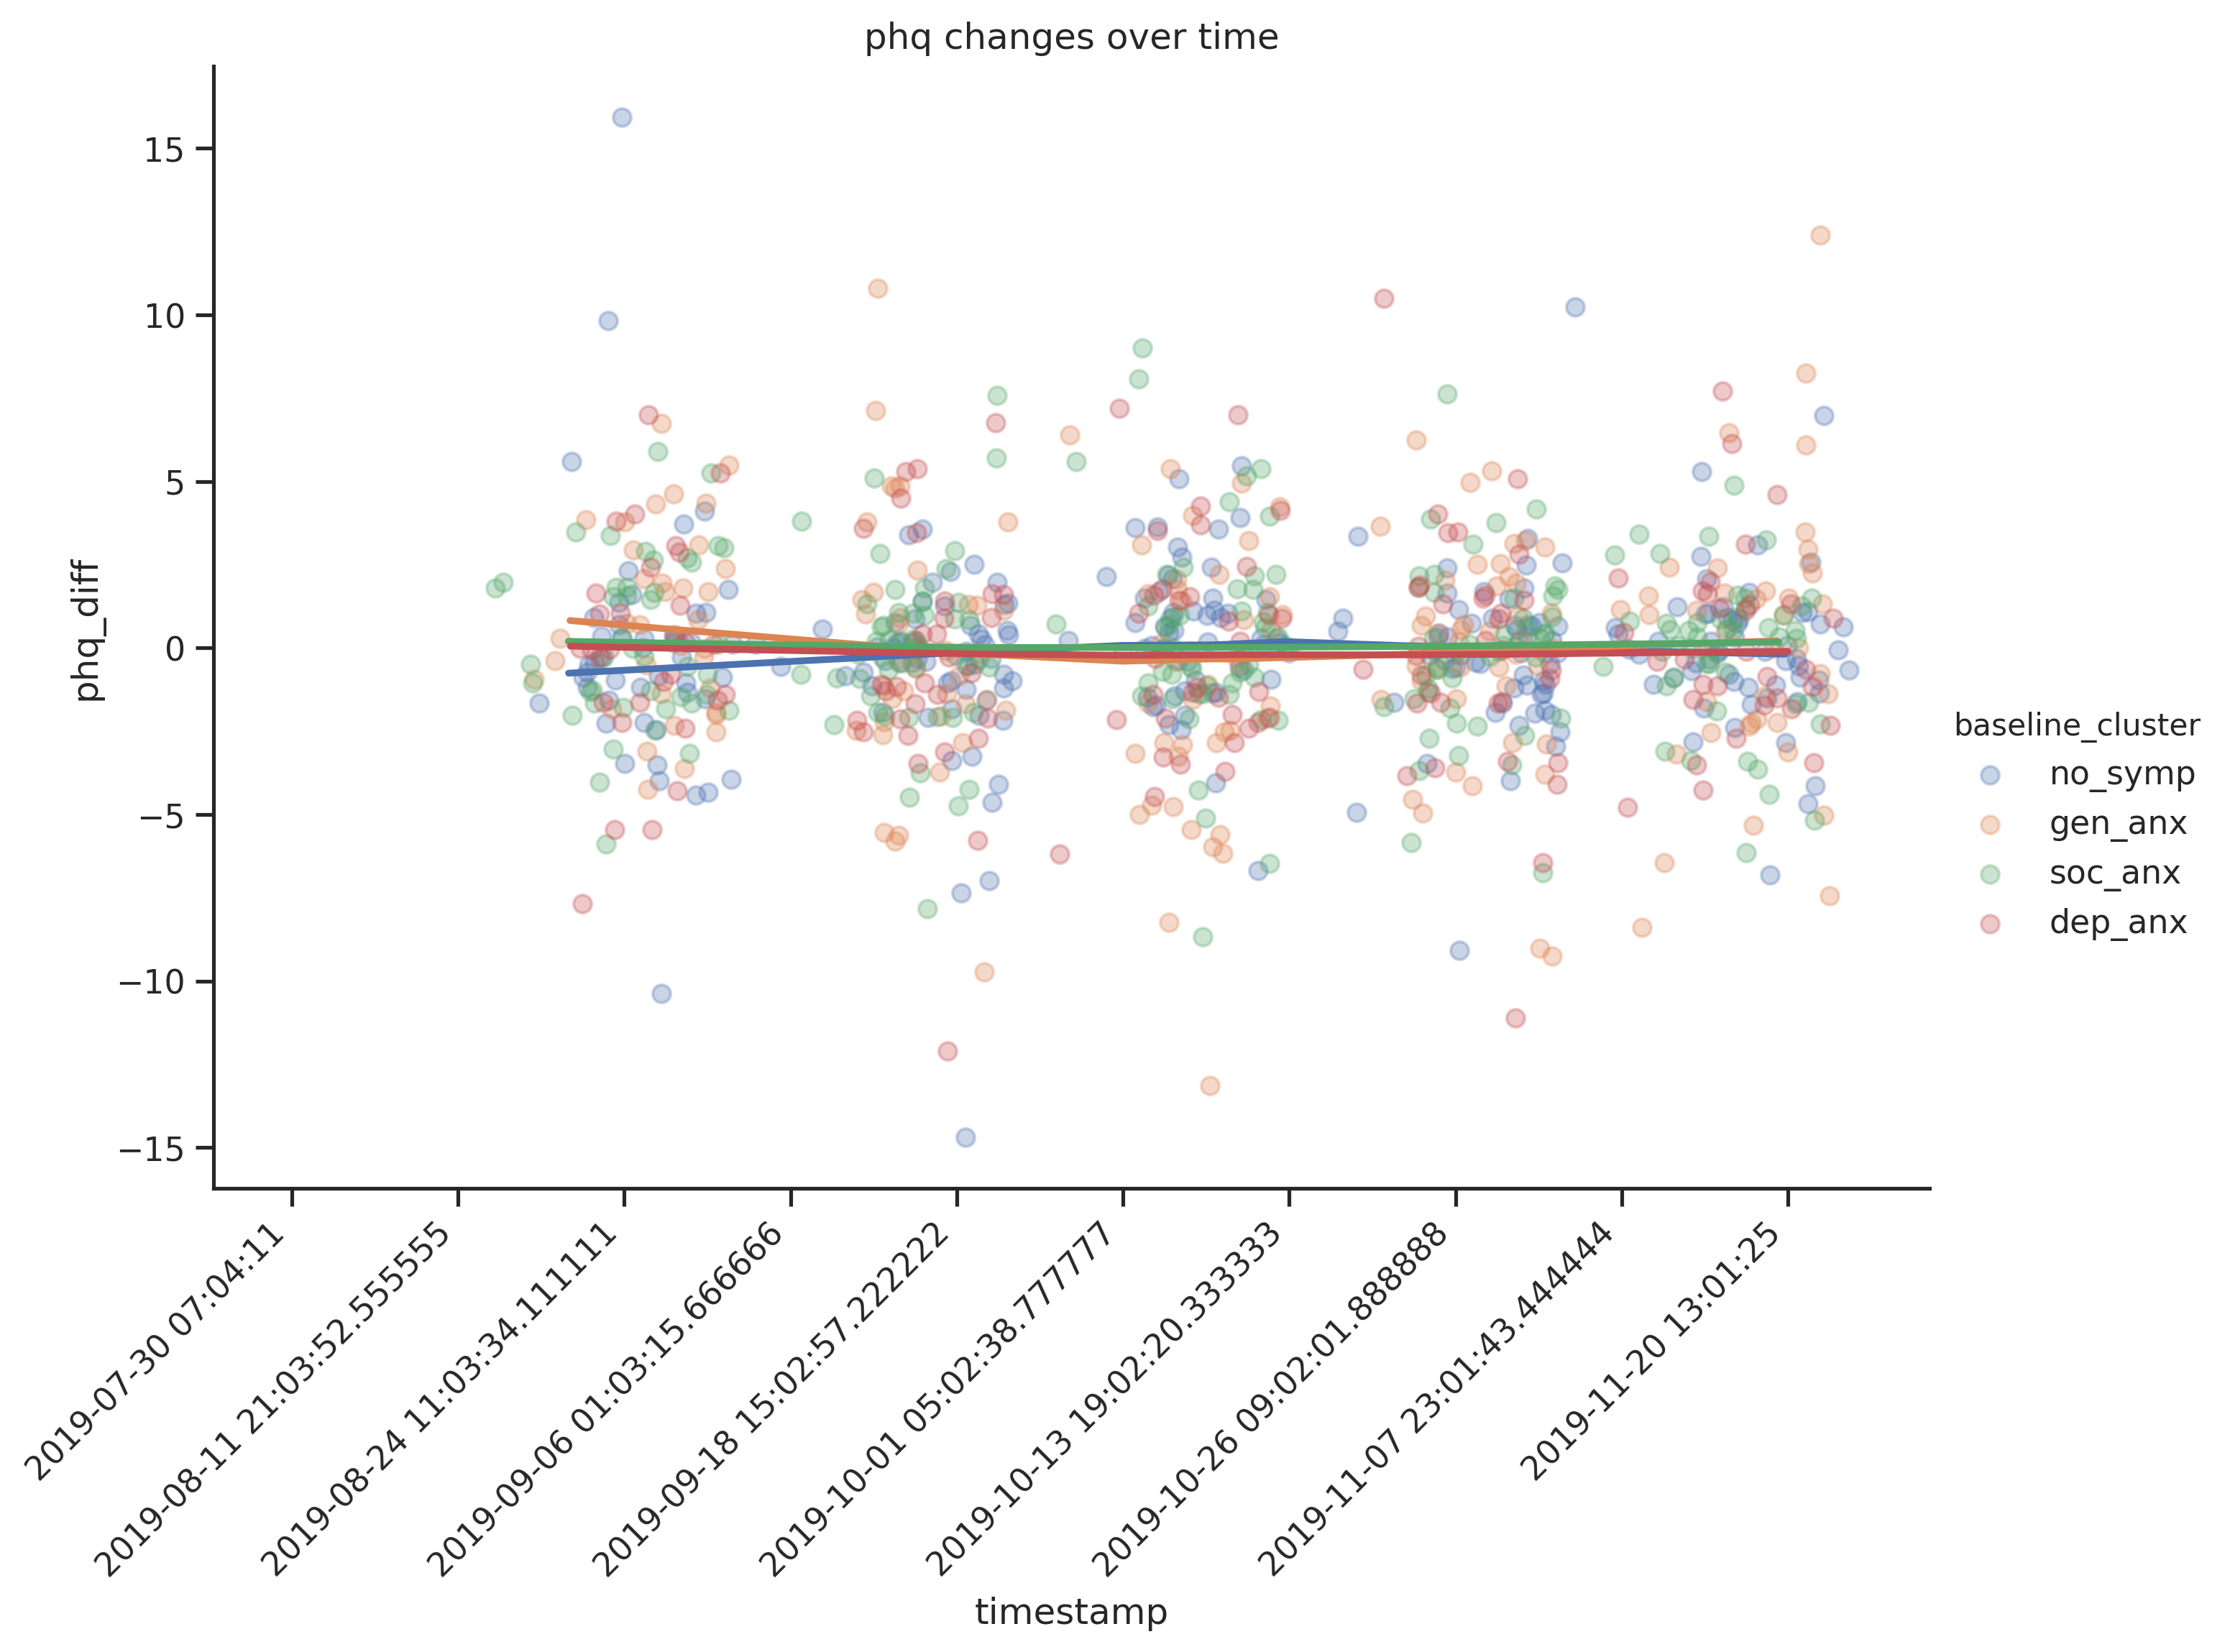

In [524]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [525]:
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

Text(0.5, 1.0, 'Within individual PHQ shift variance')

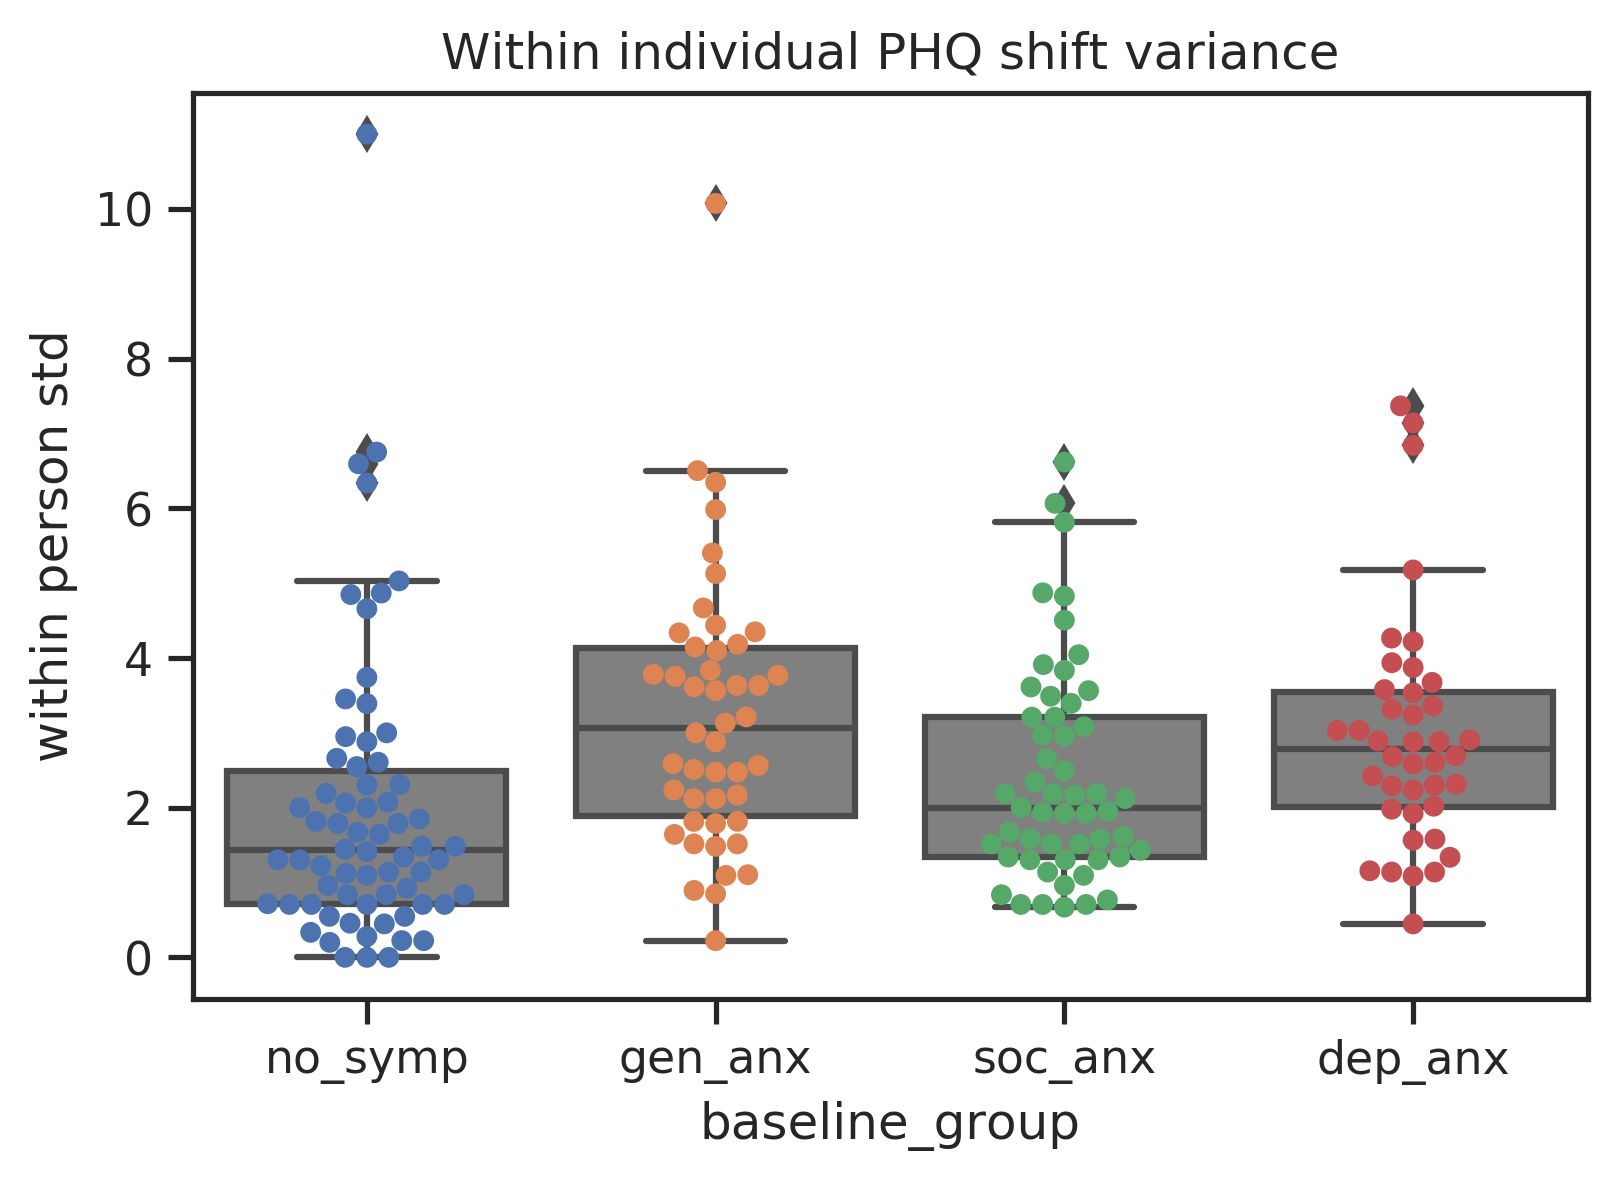

In [526]:

phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

In [672]:
phq_std.groupby('baseline_group').describe()

within person std                                          \
                           count      mean       std       min       25%   
baseline_group                                                             
dep_anx                     40.0  2.966863  1.562477  0.447214  2.009628   
gen_anx                     46.0  3.227902  1.810800  0.223607  1.892773   
no_symp                     66.0  1.992893  1.949029  0.000000  0.709545   
soc_anx                     53.0  2.428166  1.446199  0.670820  1.341641   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         2.787293  3.546078   7.368853  
gen_anx         3.065248  4.135585  10.074721  
no_symp         1.429756  2.489031  11.000000  
soc_anx         2.000000  3.209361   6.618157

### SPIN

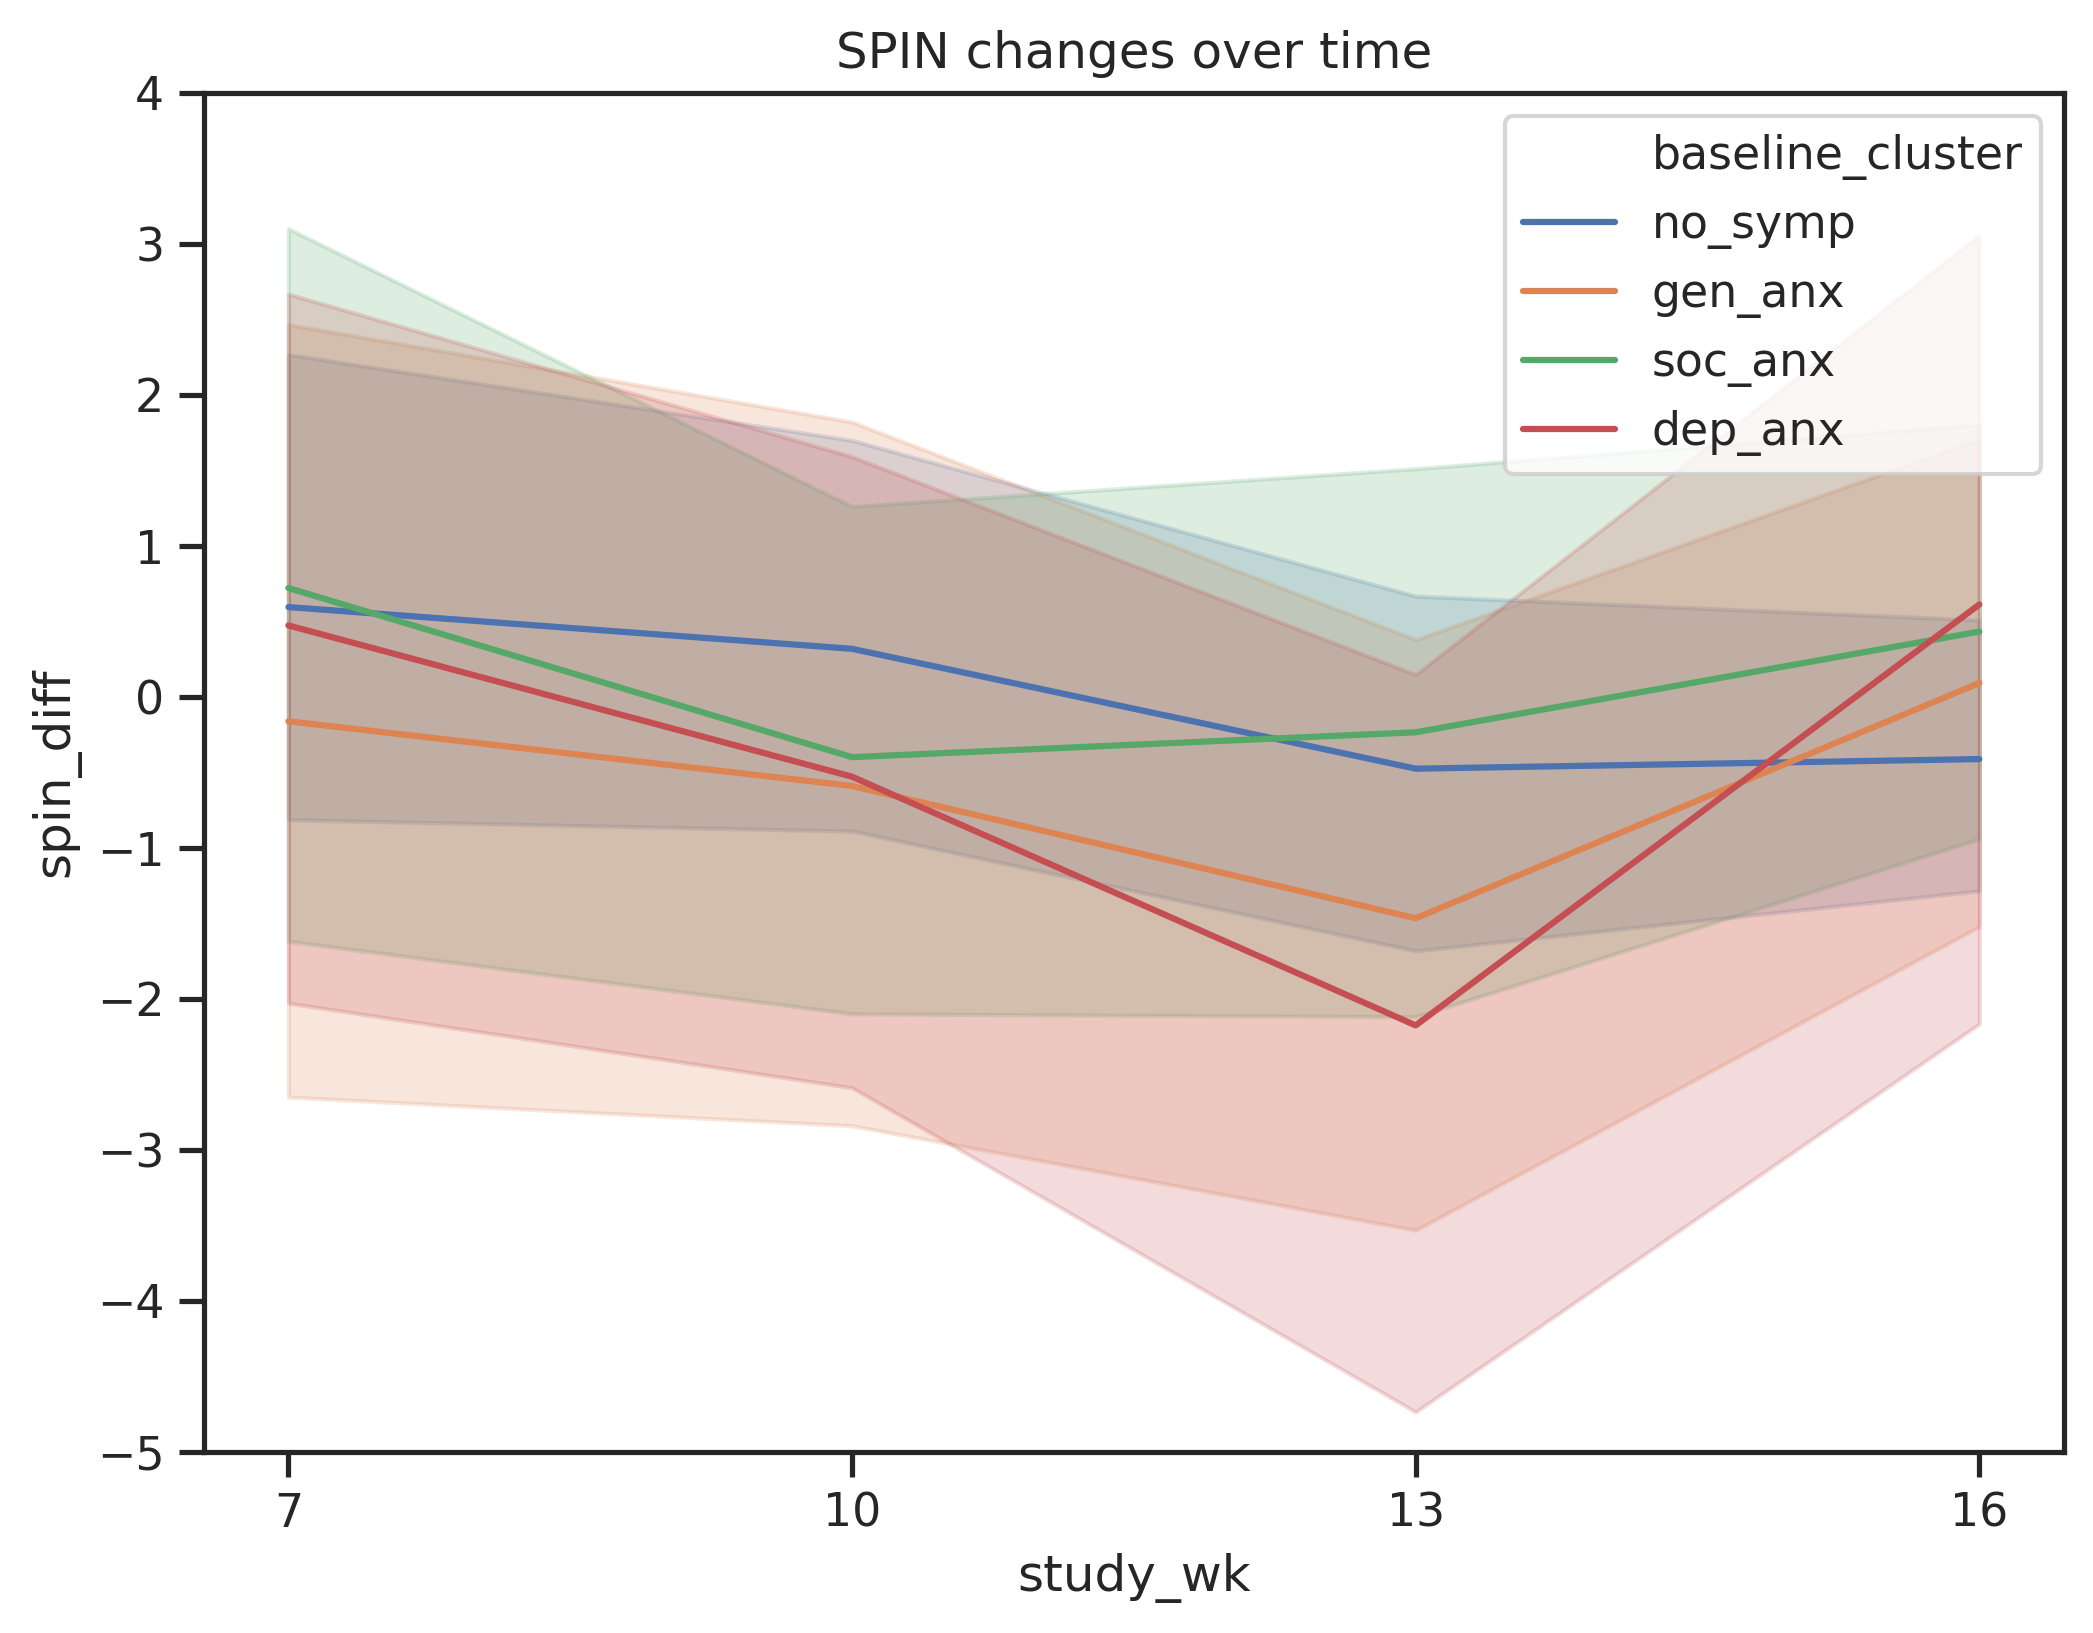

In [527]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

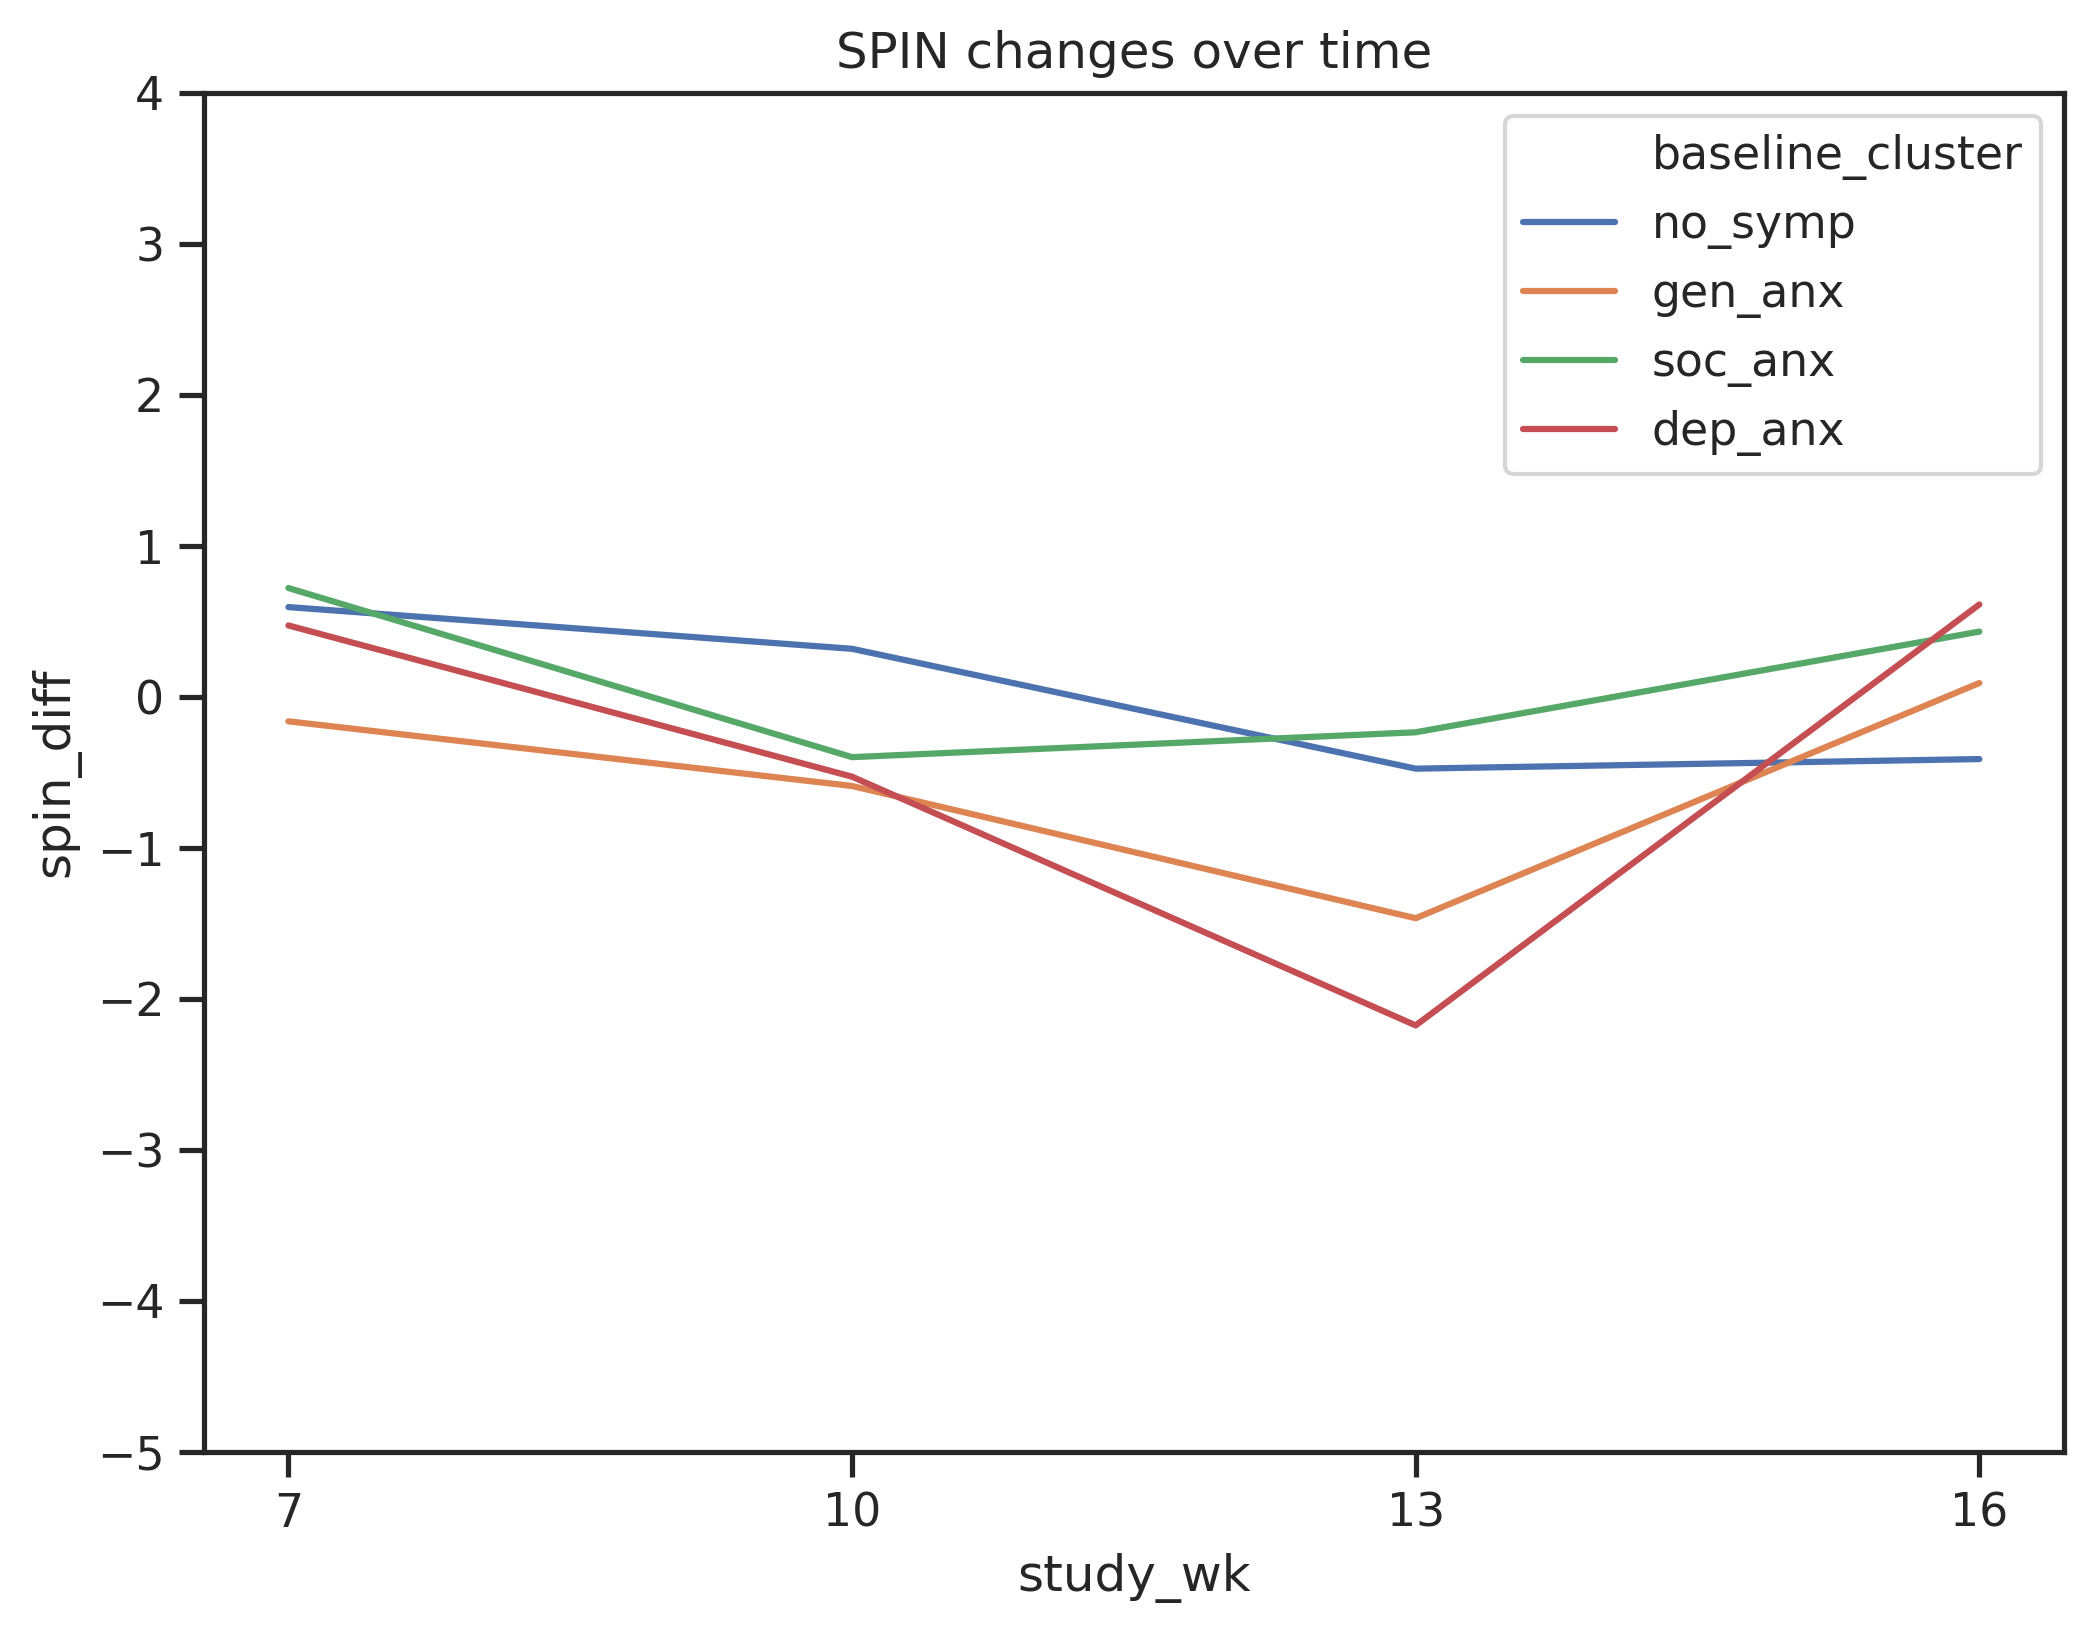

In [528]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

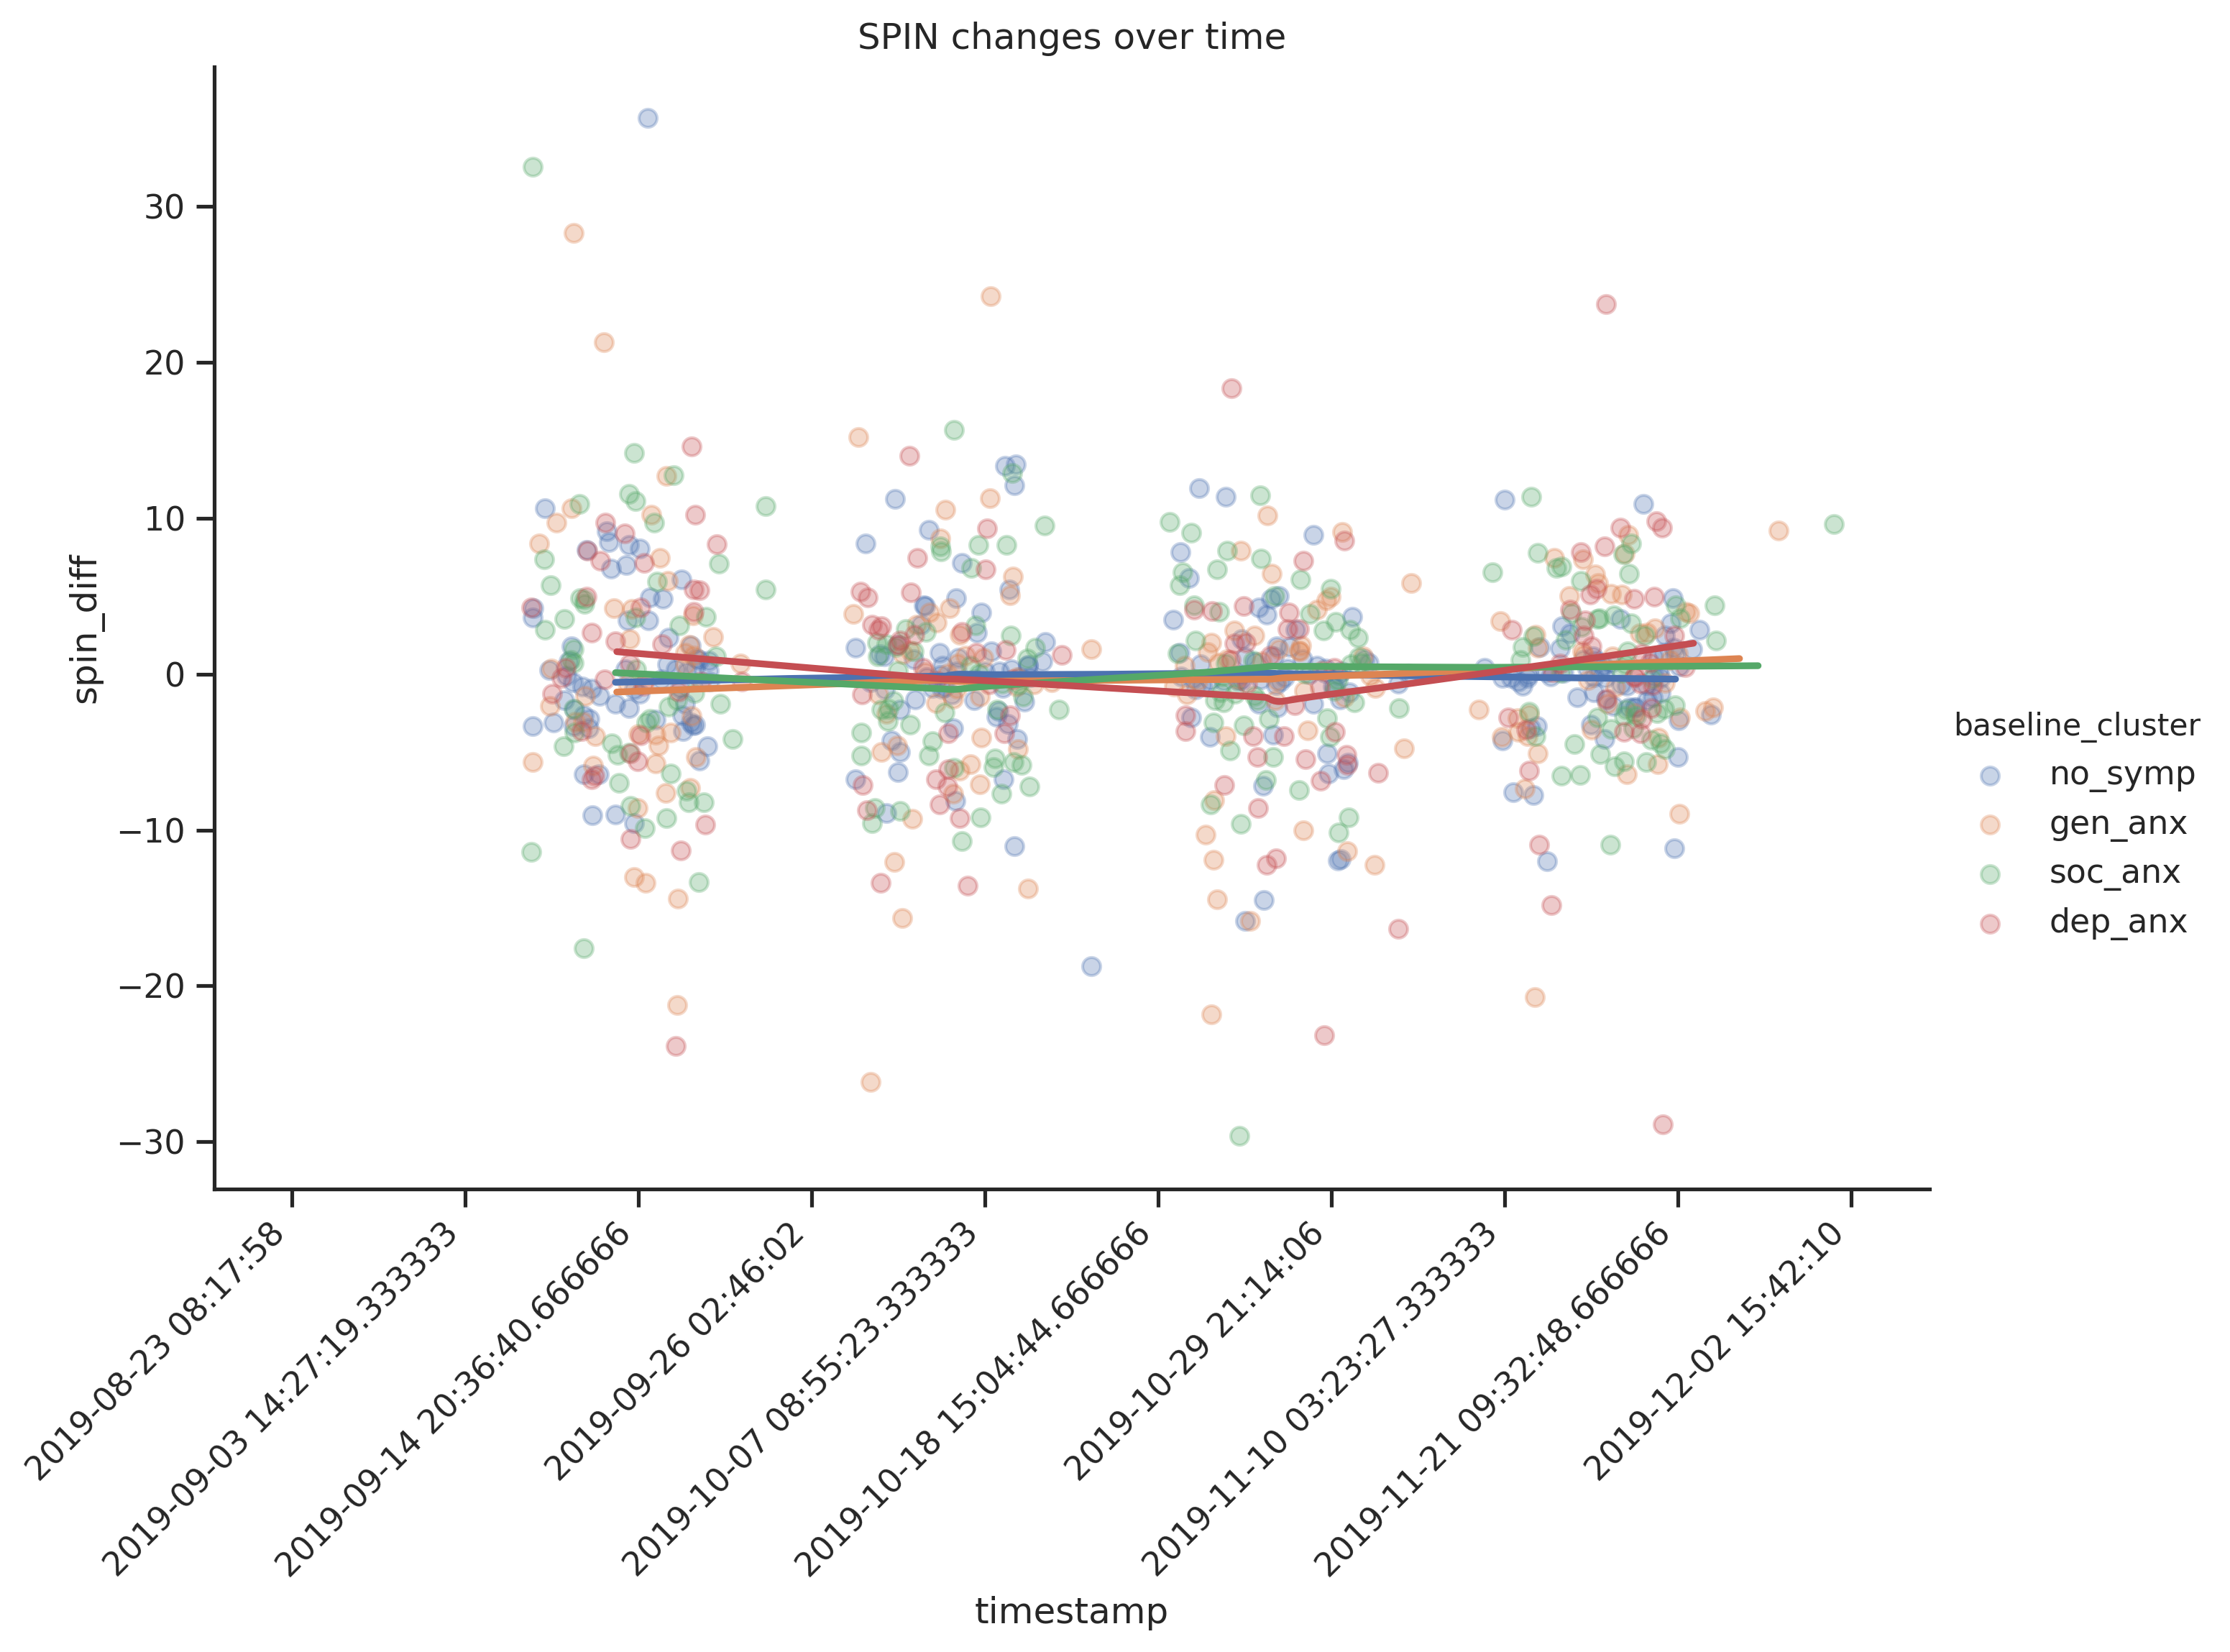

In [529]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

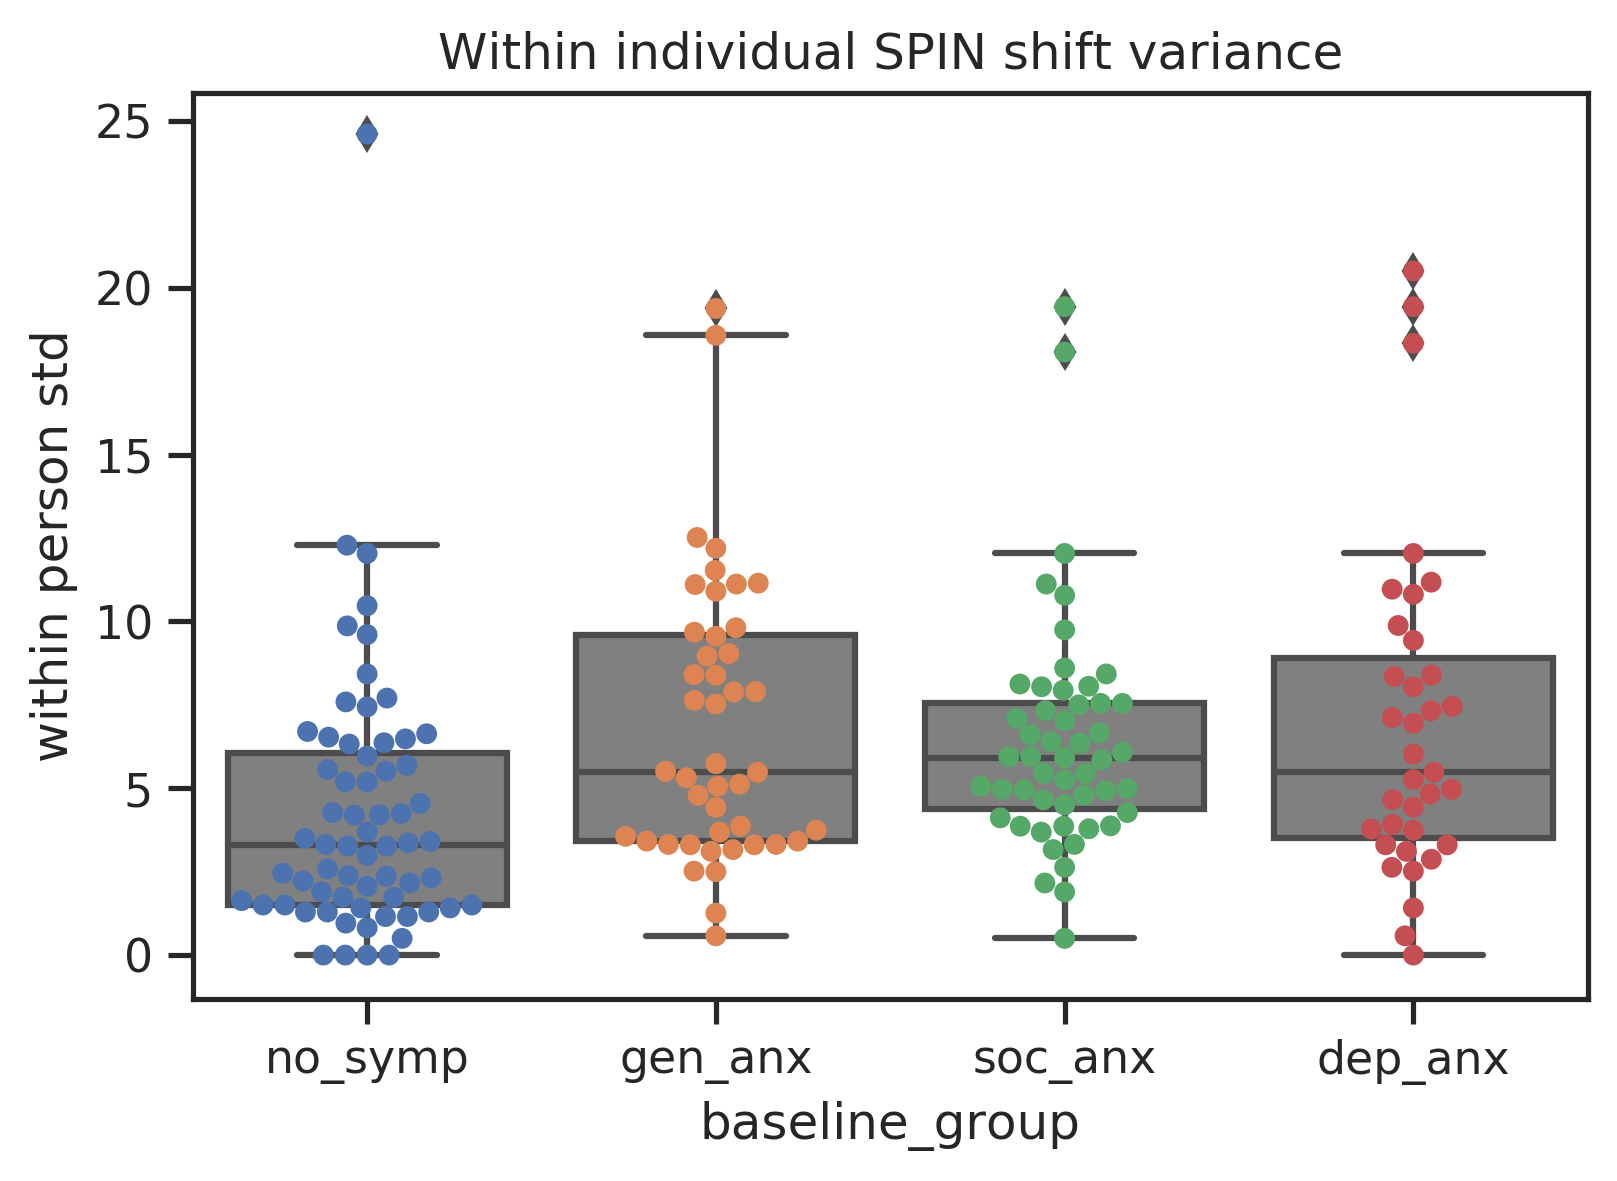

In [530]:

spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['baseline_group'] = spin_std['pid'].map(cluster_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=spin_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=spin_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [673]:
spin_std.groupby('baseline_group').describe()

within person std                                         \
                           count      mean       std      min       25%   
baseline_group                                                            
dep_anx                     35.0  6.942775  4.957938  0.00000  3.522848   
gen_anx                     44.0  6.880111  4.210229  0.57735  3.415650   
no_symp                     64.0  4.245557  3.954601  0.00000  1.500000   
soc_anx                     51.0  6.396988  3.435372  0.50000  4.386001   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         5.477226  8.908030  20.506097  
gen_anx         5.492398  9.587174  19.379972  
no_symp         3.291306  6.055021  24.608603  
soc_anx         5.909033  7.544314  19.433648

### GAD

In [531]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

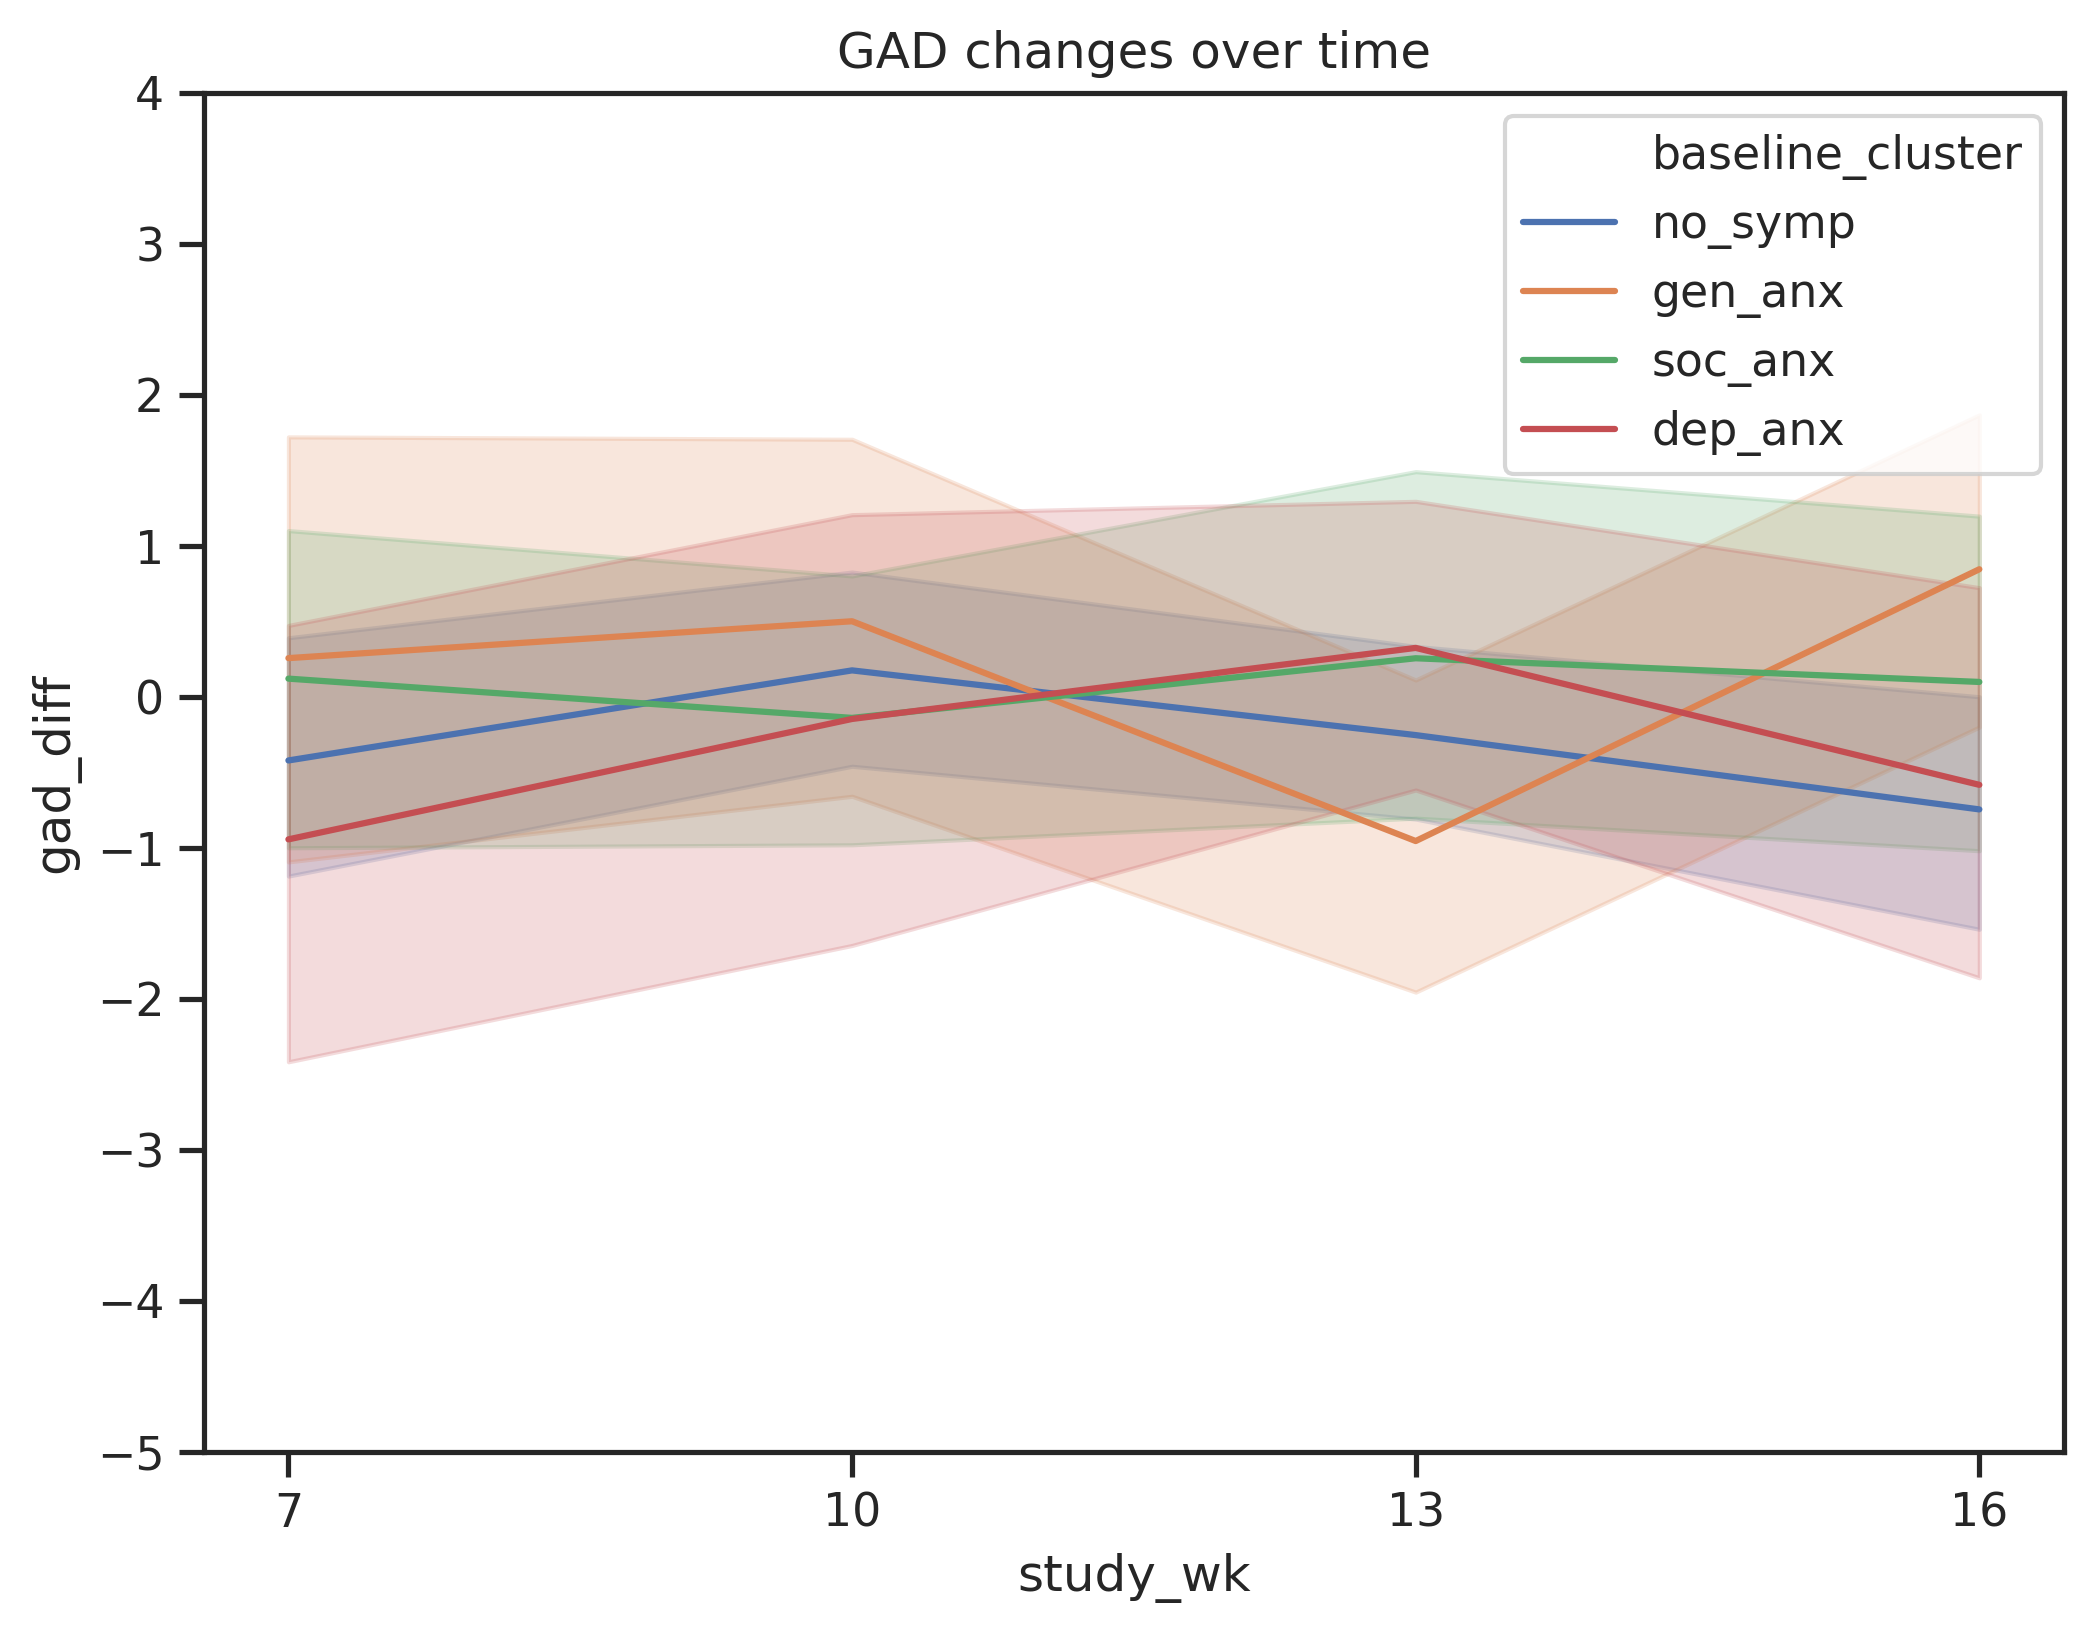

In [532]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

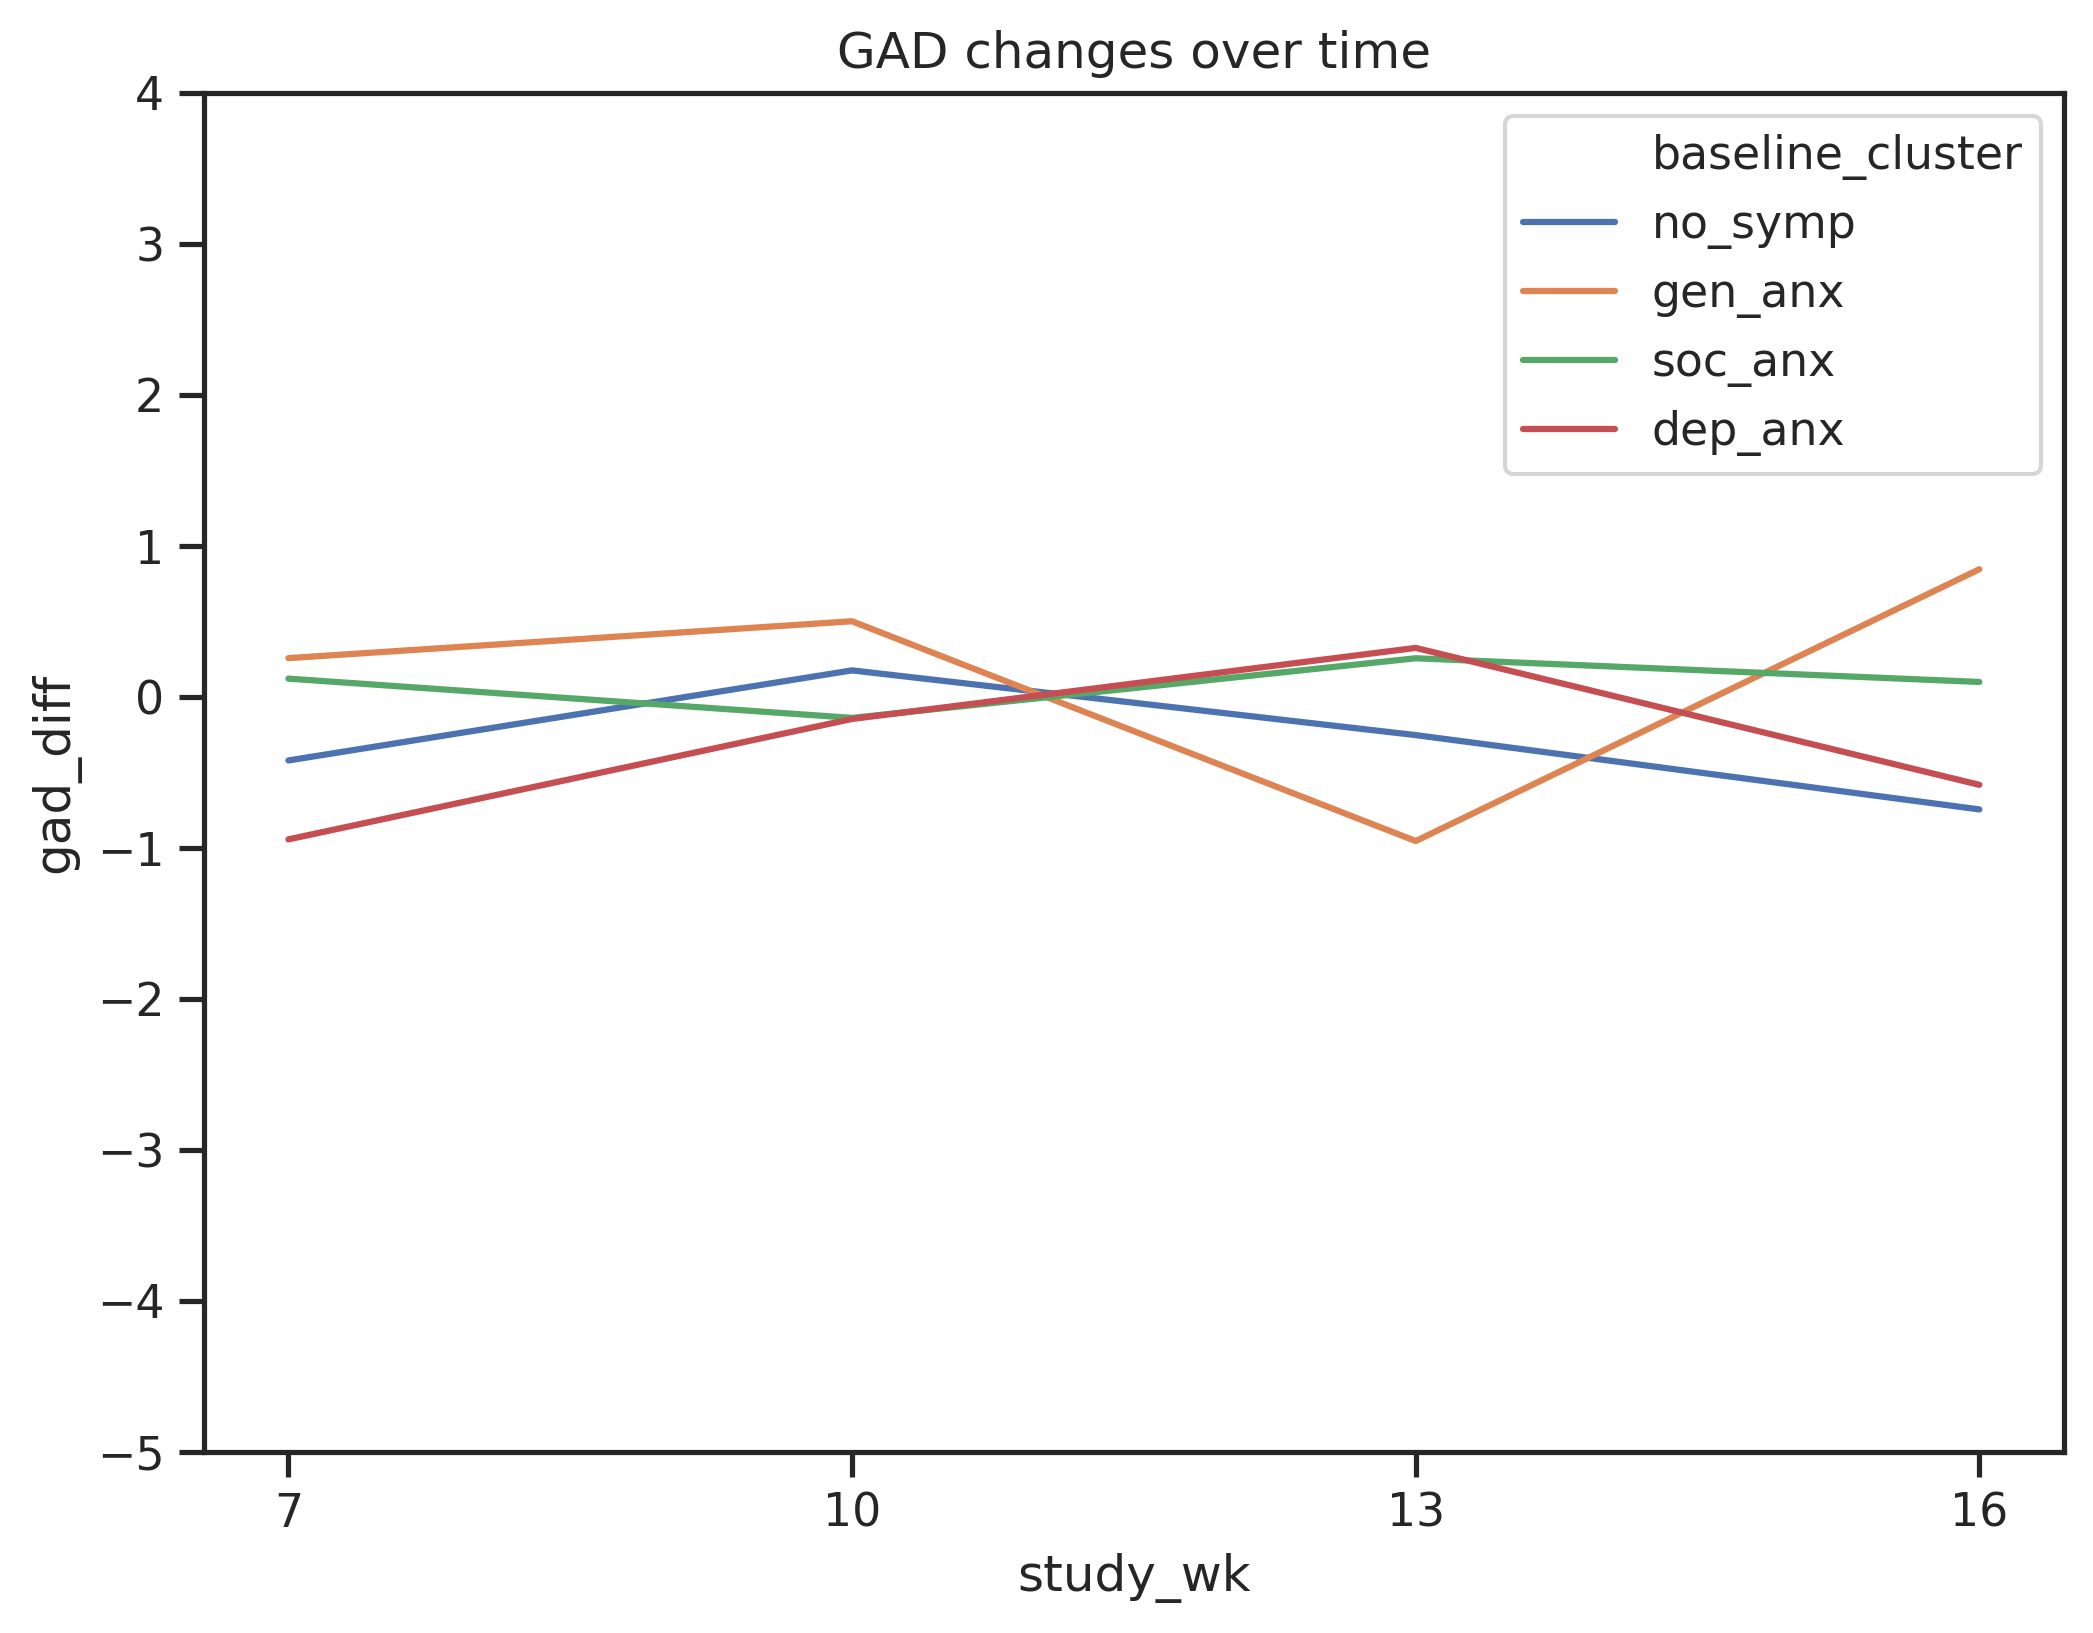

In [533]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

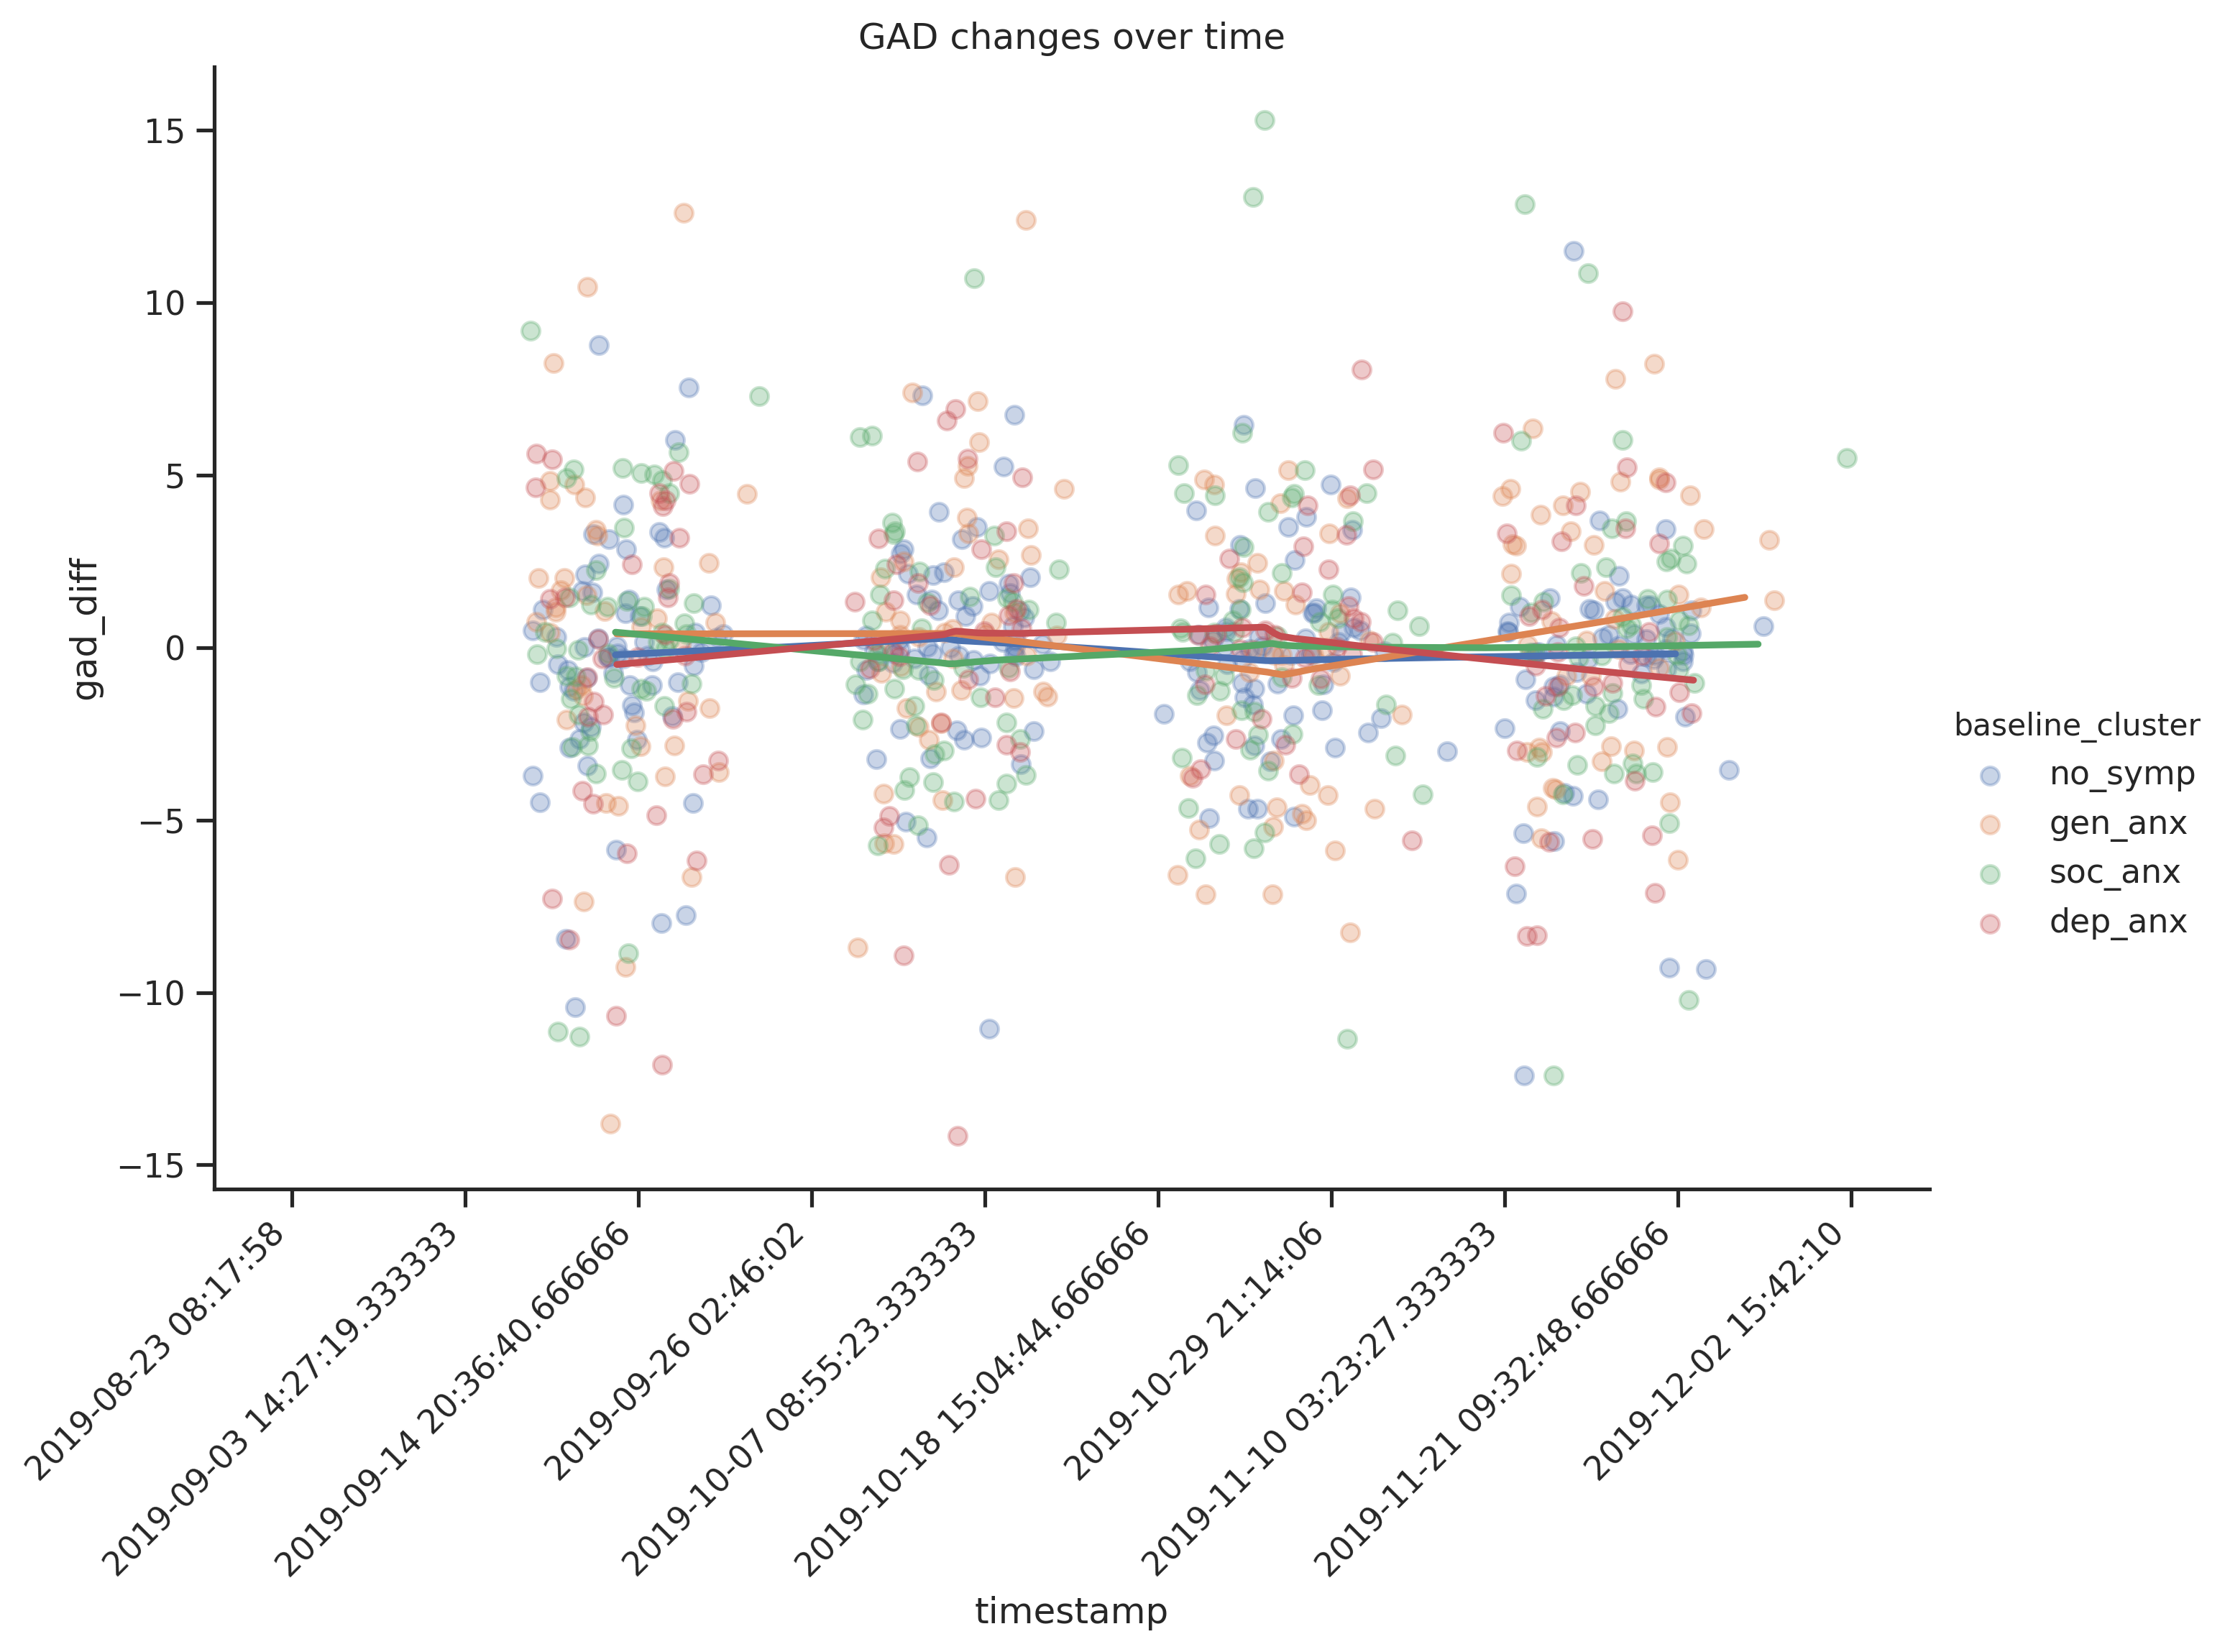

In [534]:
import matplotlib.dates as md

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

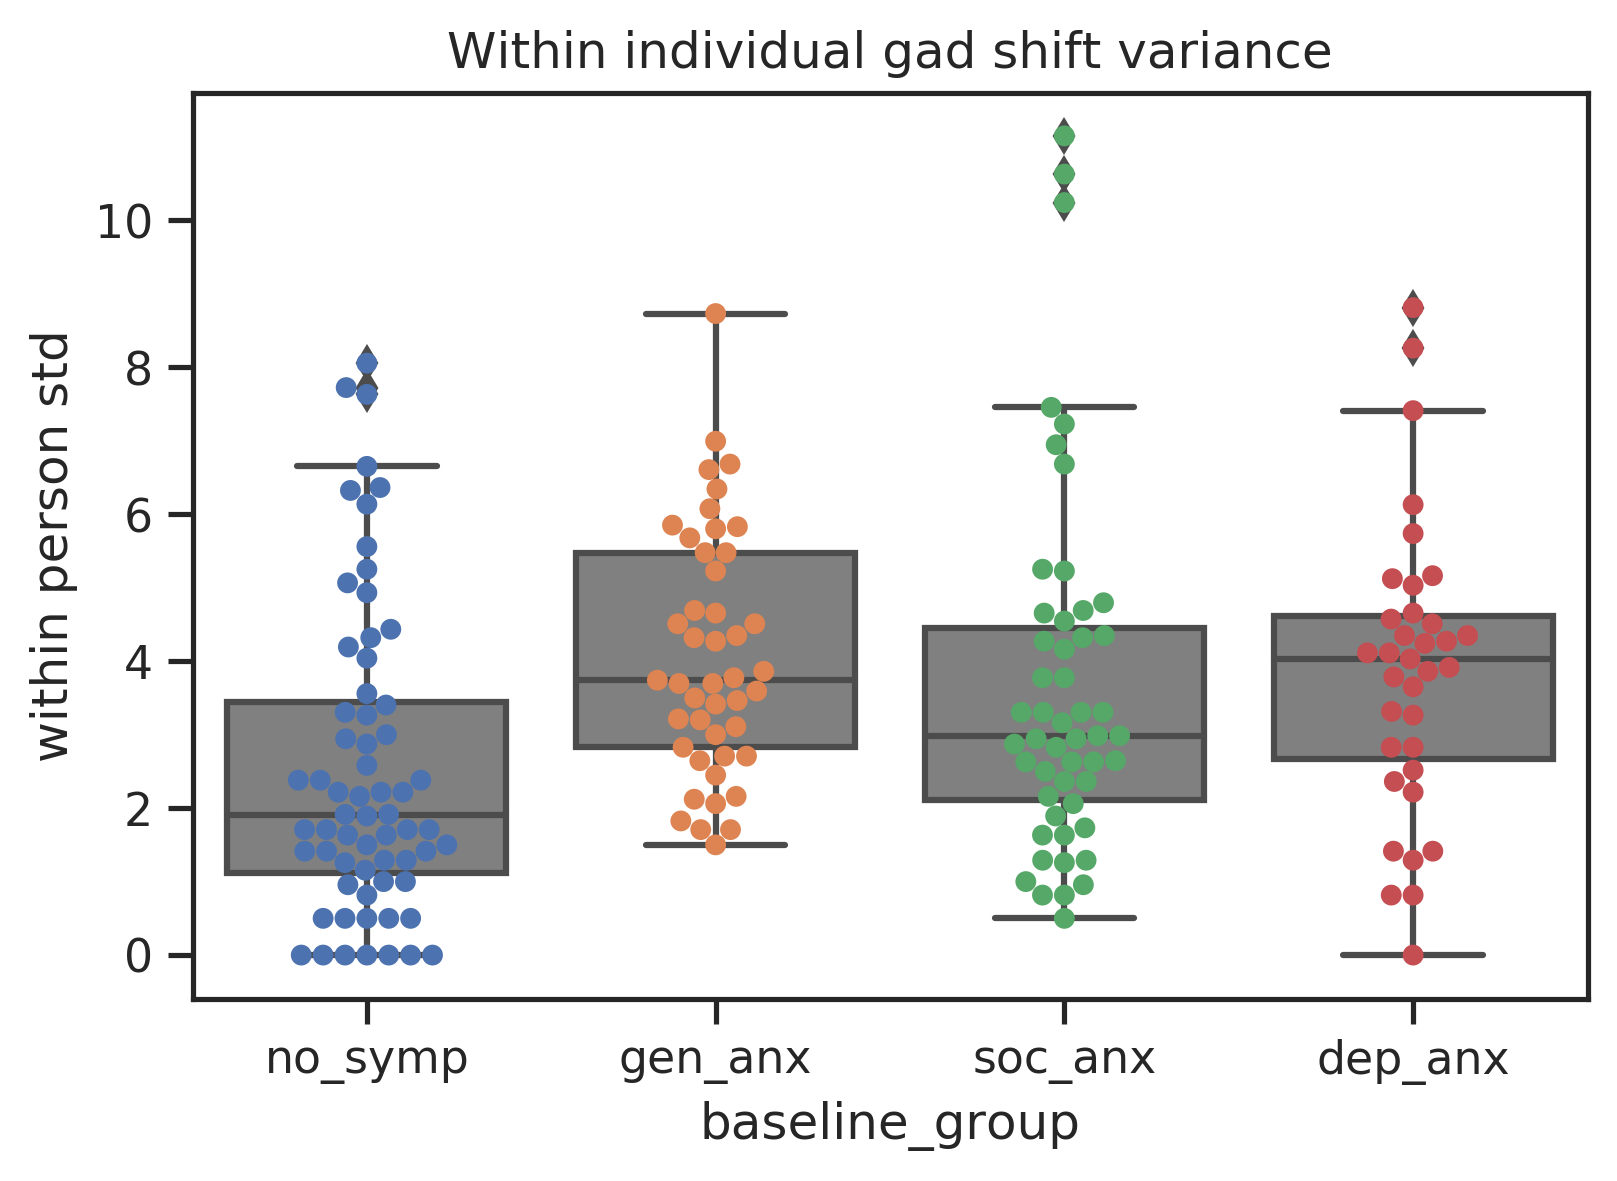

In [535]:

gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['baseline_group'] = gad_std['pid'].map(cluster_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=gad_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=gad_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual gad shift variance")

In [674]:
gad_std.groupby('baseline_group').describe()

within person std                                               \
                           count      mean       std  min       25%       50%   
baseline_group                                                                  
dep_anx                     35.0  3.862439  1.984782  0.0  2.672519  4.031129   
gen_anx                     45.0  4.084133  1.657012  1.5  2.828427  3.741657   
no_symp                     64.0  2.529825  2.110941  0.0  1.116025  1.903912   
soc_anx                     51.0  3.625552  2.433273  0.5  2.110900  2.986079   

                                     
                     75%        max  
baseline_group                       
dep_anx         4.614110   8.812869  
gen_anx         5.477226   8.732125  
no_symp         3.442329   8.057088  
soc_anx         4.447695  11.150486

# SPIN

## Full population

In [599]:
display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

## no_symp

In [600]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

## soc_anx

In [601]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

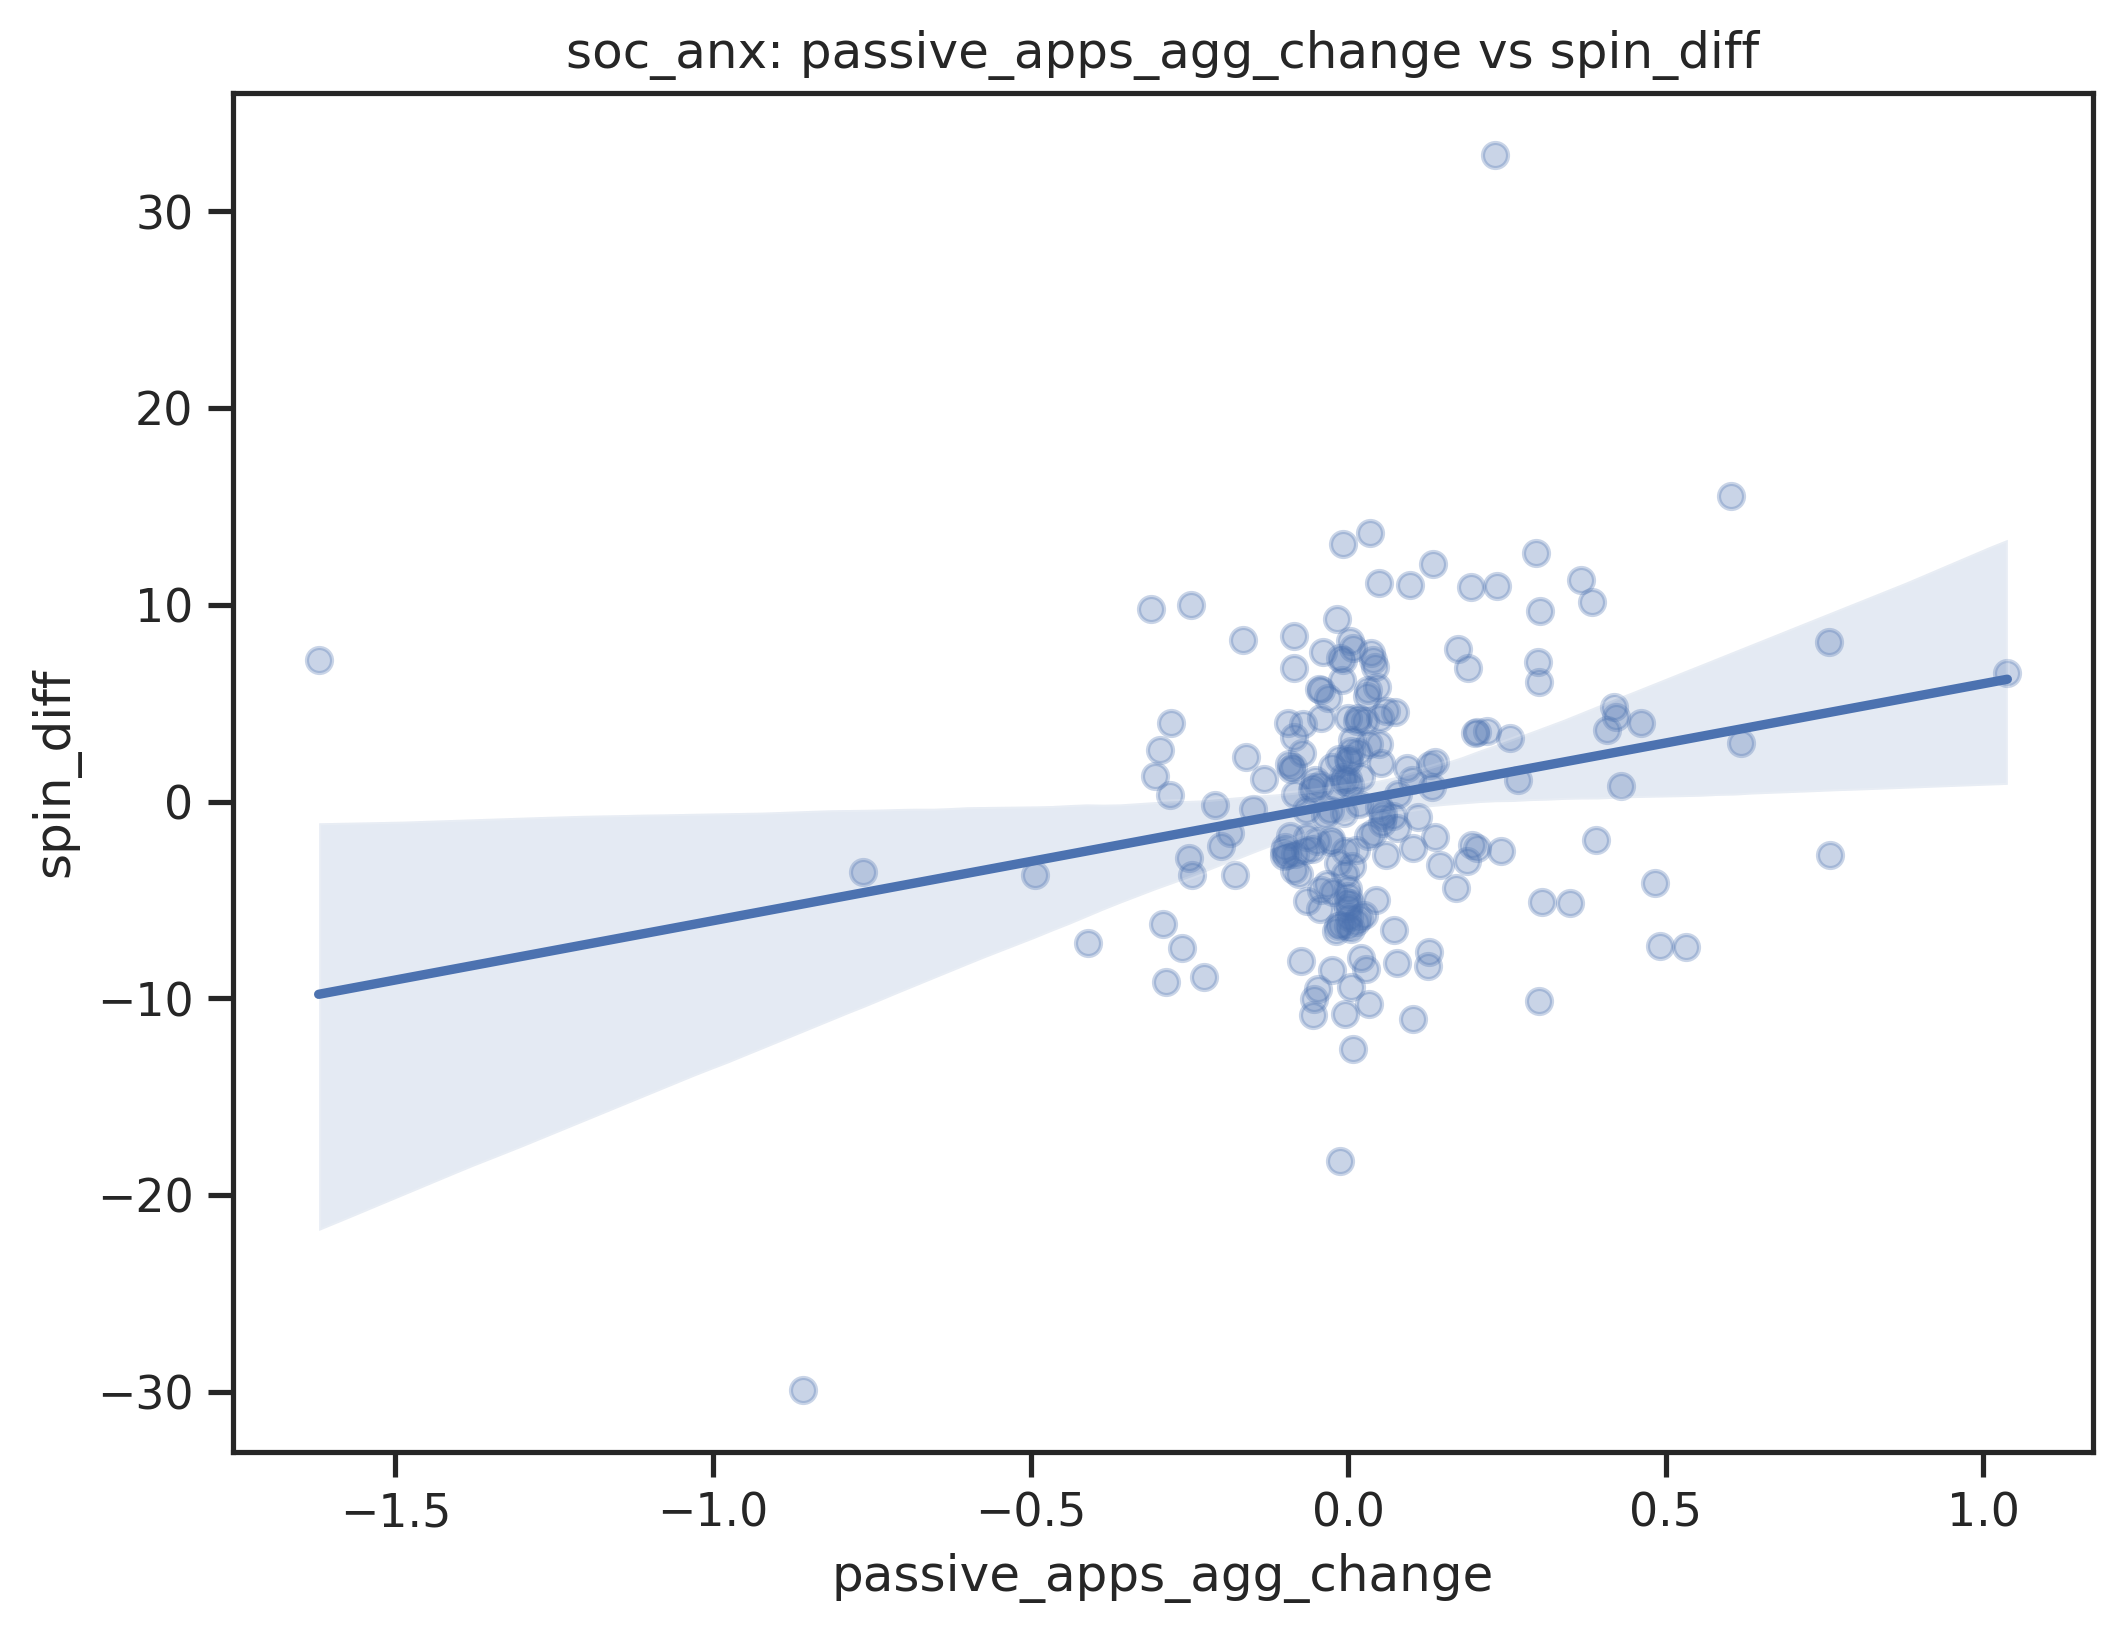

In [602]:
ls_utils.plot_cluster_scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

## gen_anx

In [603]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

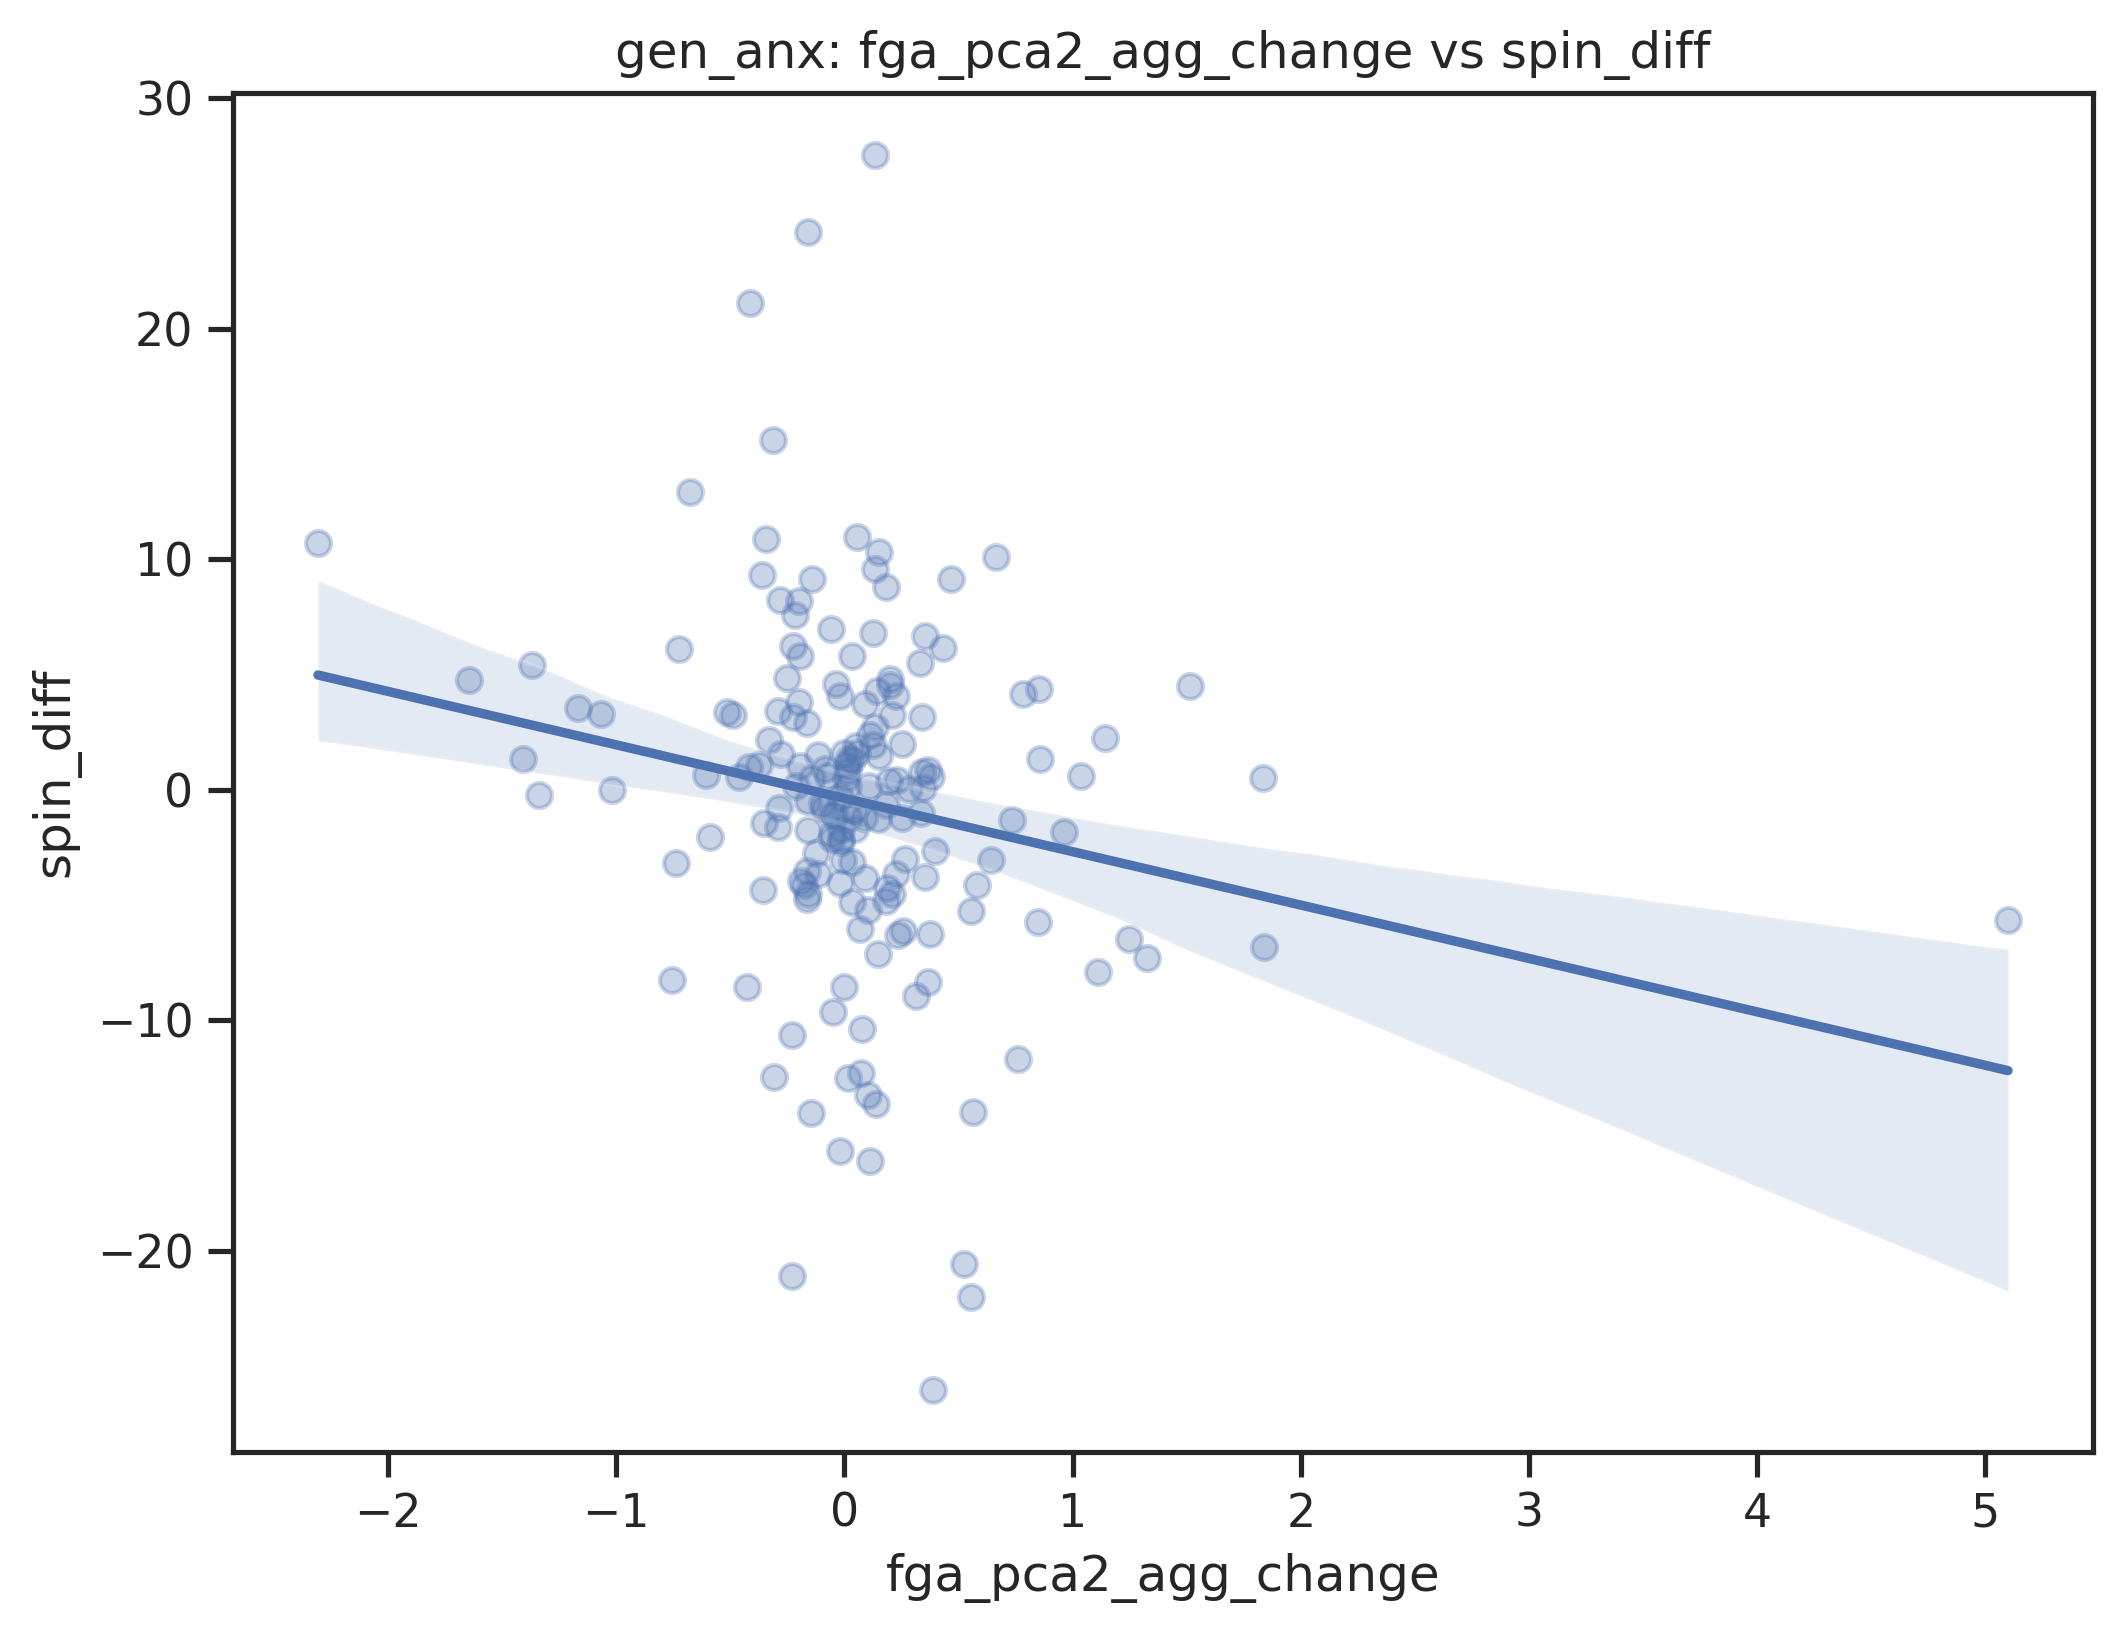

In [554]:
ls_utils.plot_cluster_scatter('fga_pca2_agg_change', 'spin_diff', sel_state_df, 'gen_anx', (8,6))

## dep_anx

In [604]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

# Reverse SPIN

## Full population

In [618]:
display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

## no_symp

In [619]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

## soc_anx

In [620]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

## gen_anx

In [621]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

## dep_anx

In [622]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

# GAD

## Full population

In [605]:
display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

## no_symp

In [606]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## soc_anx

In [607]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## gen_anx

In [609]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## dep_anx

In [610]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

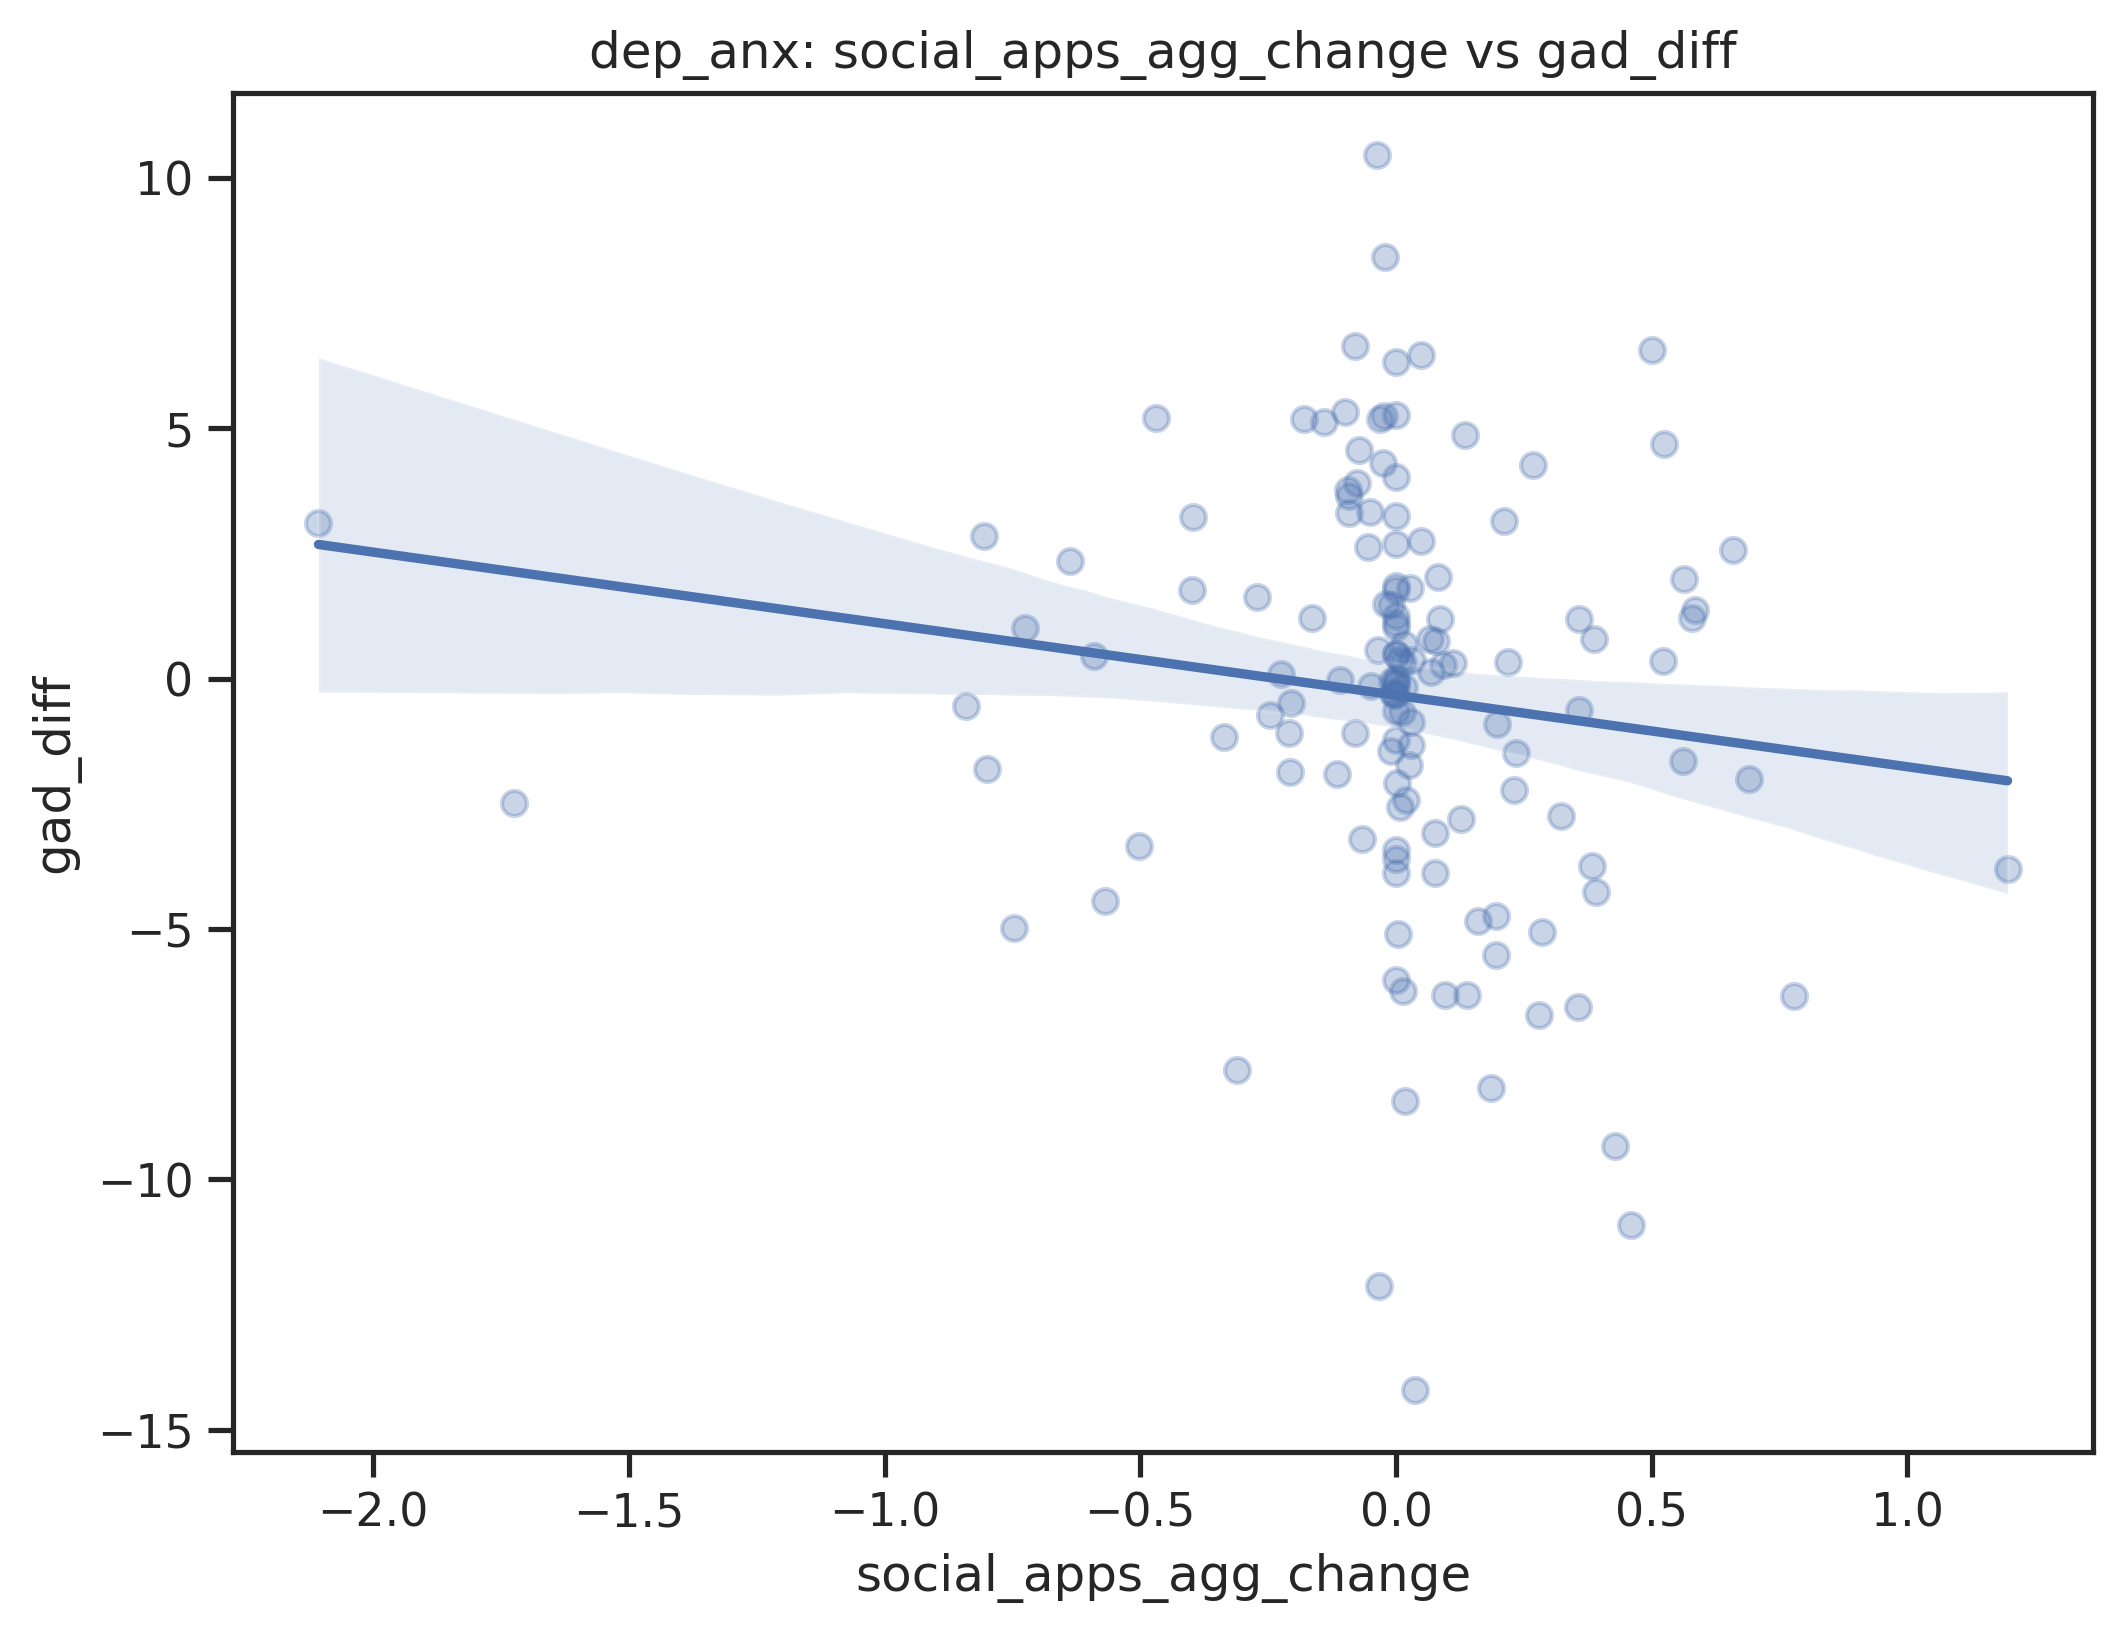

In [611]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', gad_spin_corr, 'dep_anx', (8,6))

# Reverse GAD

## Full population

In [612]:
display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

## no_symp

In [614]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## soc_anx

In [615]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## gen_anx

In [616]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

## dep_anx

In [617]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

# PHQ

## Entire population

In [636]:
display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman')

## no_symp

In [637]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'no_symp']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## soc_anx

In [638]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## gen_anx

In [640]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## dep_anx

In [641]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

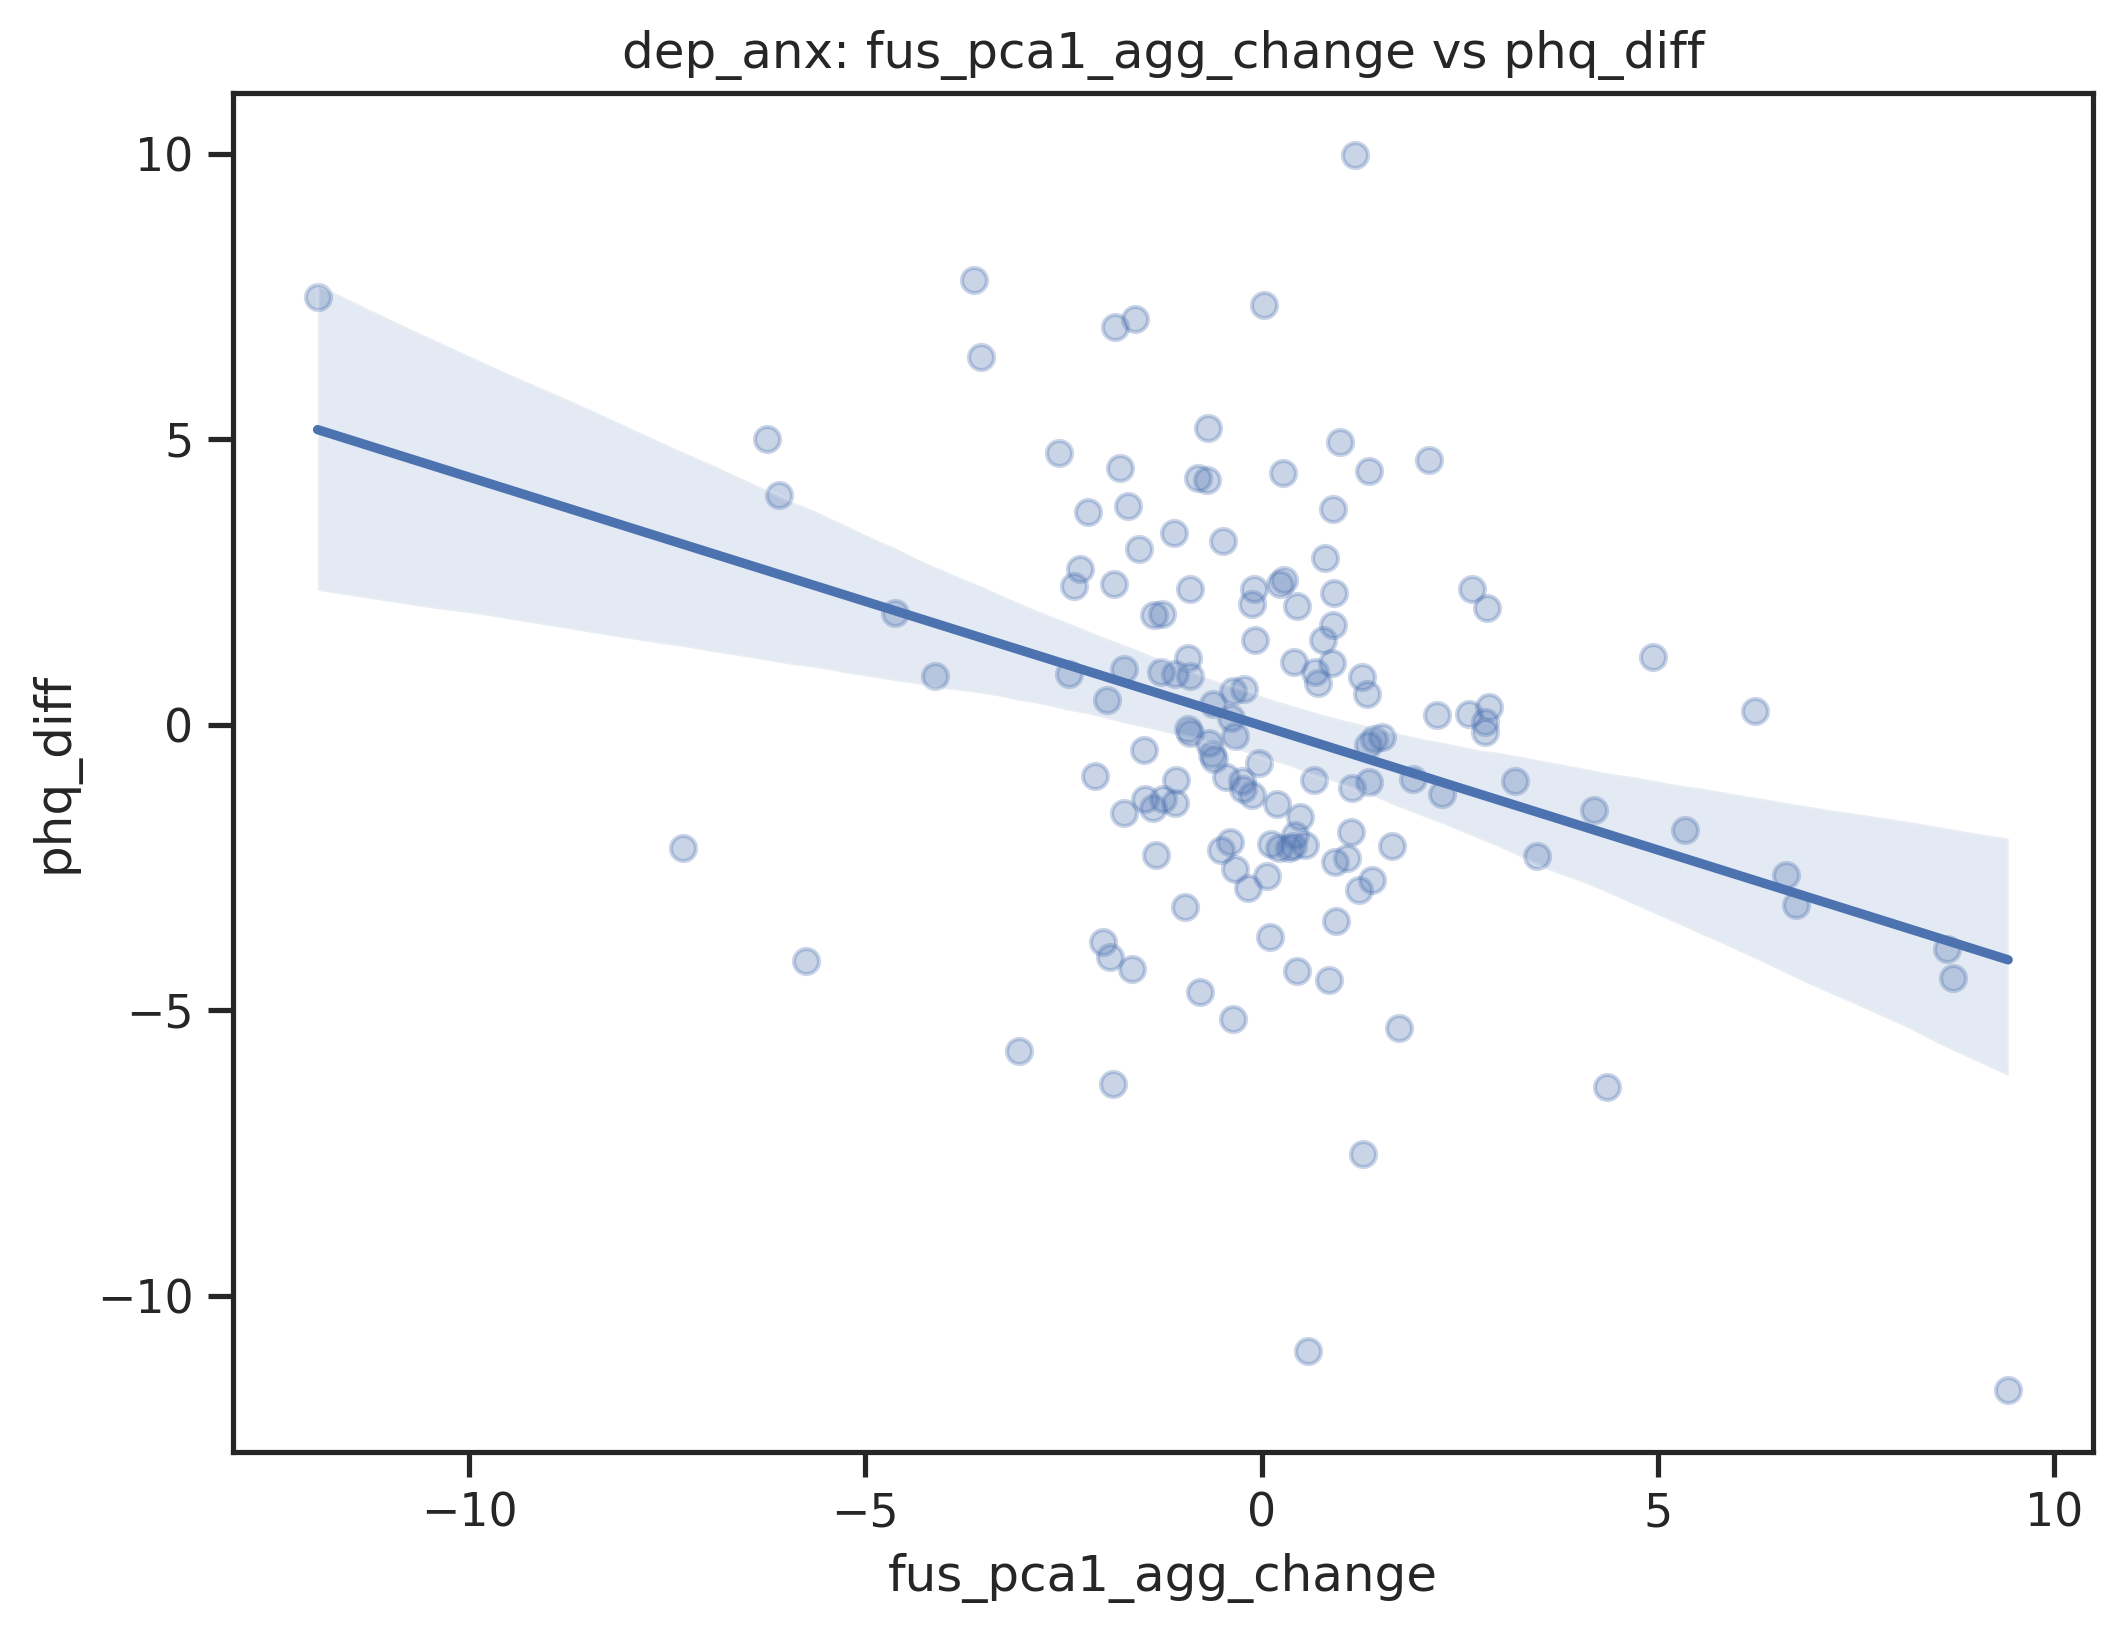

In [642]:
ls_utils.plot_cluster_scatter('fus_pca1_agg_change', 'phq_diff', phq_agg_df, 'dep_anx', (8,6))

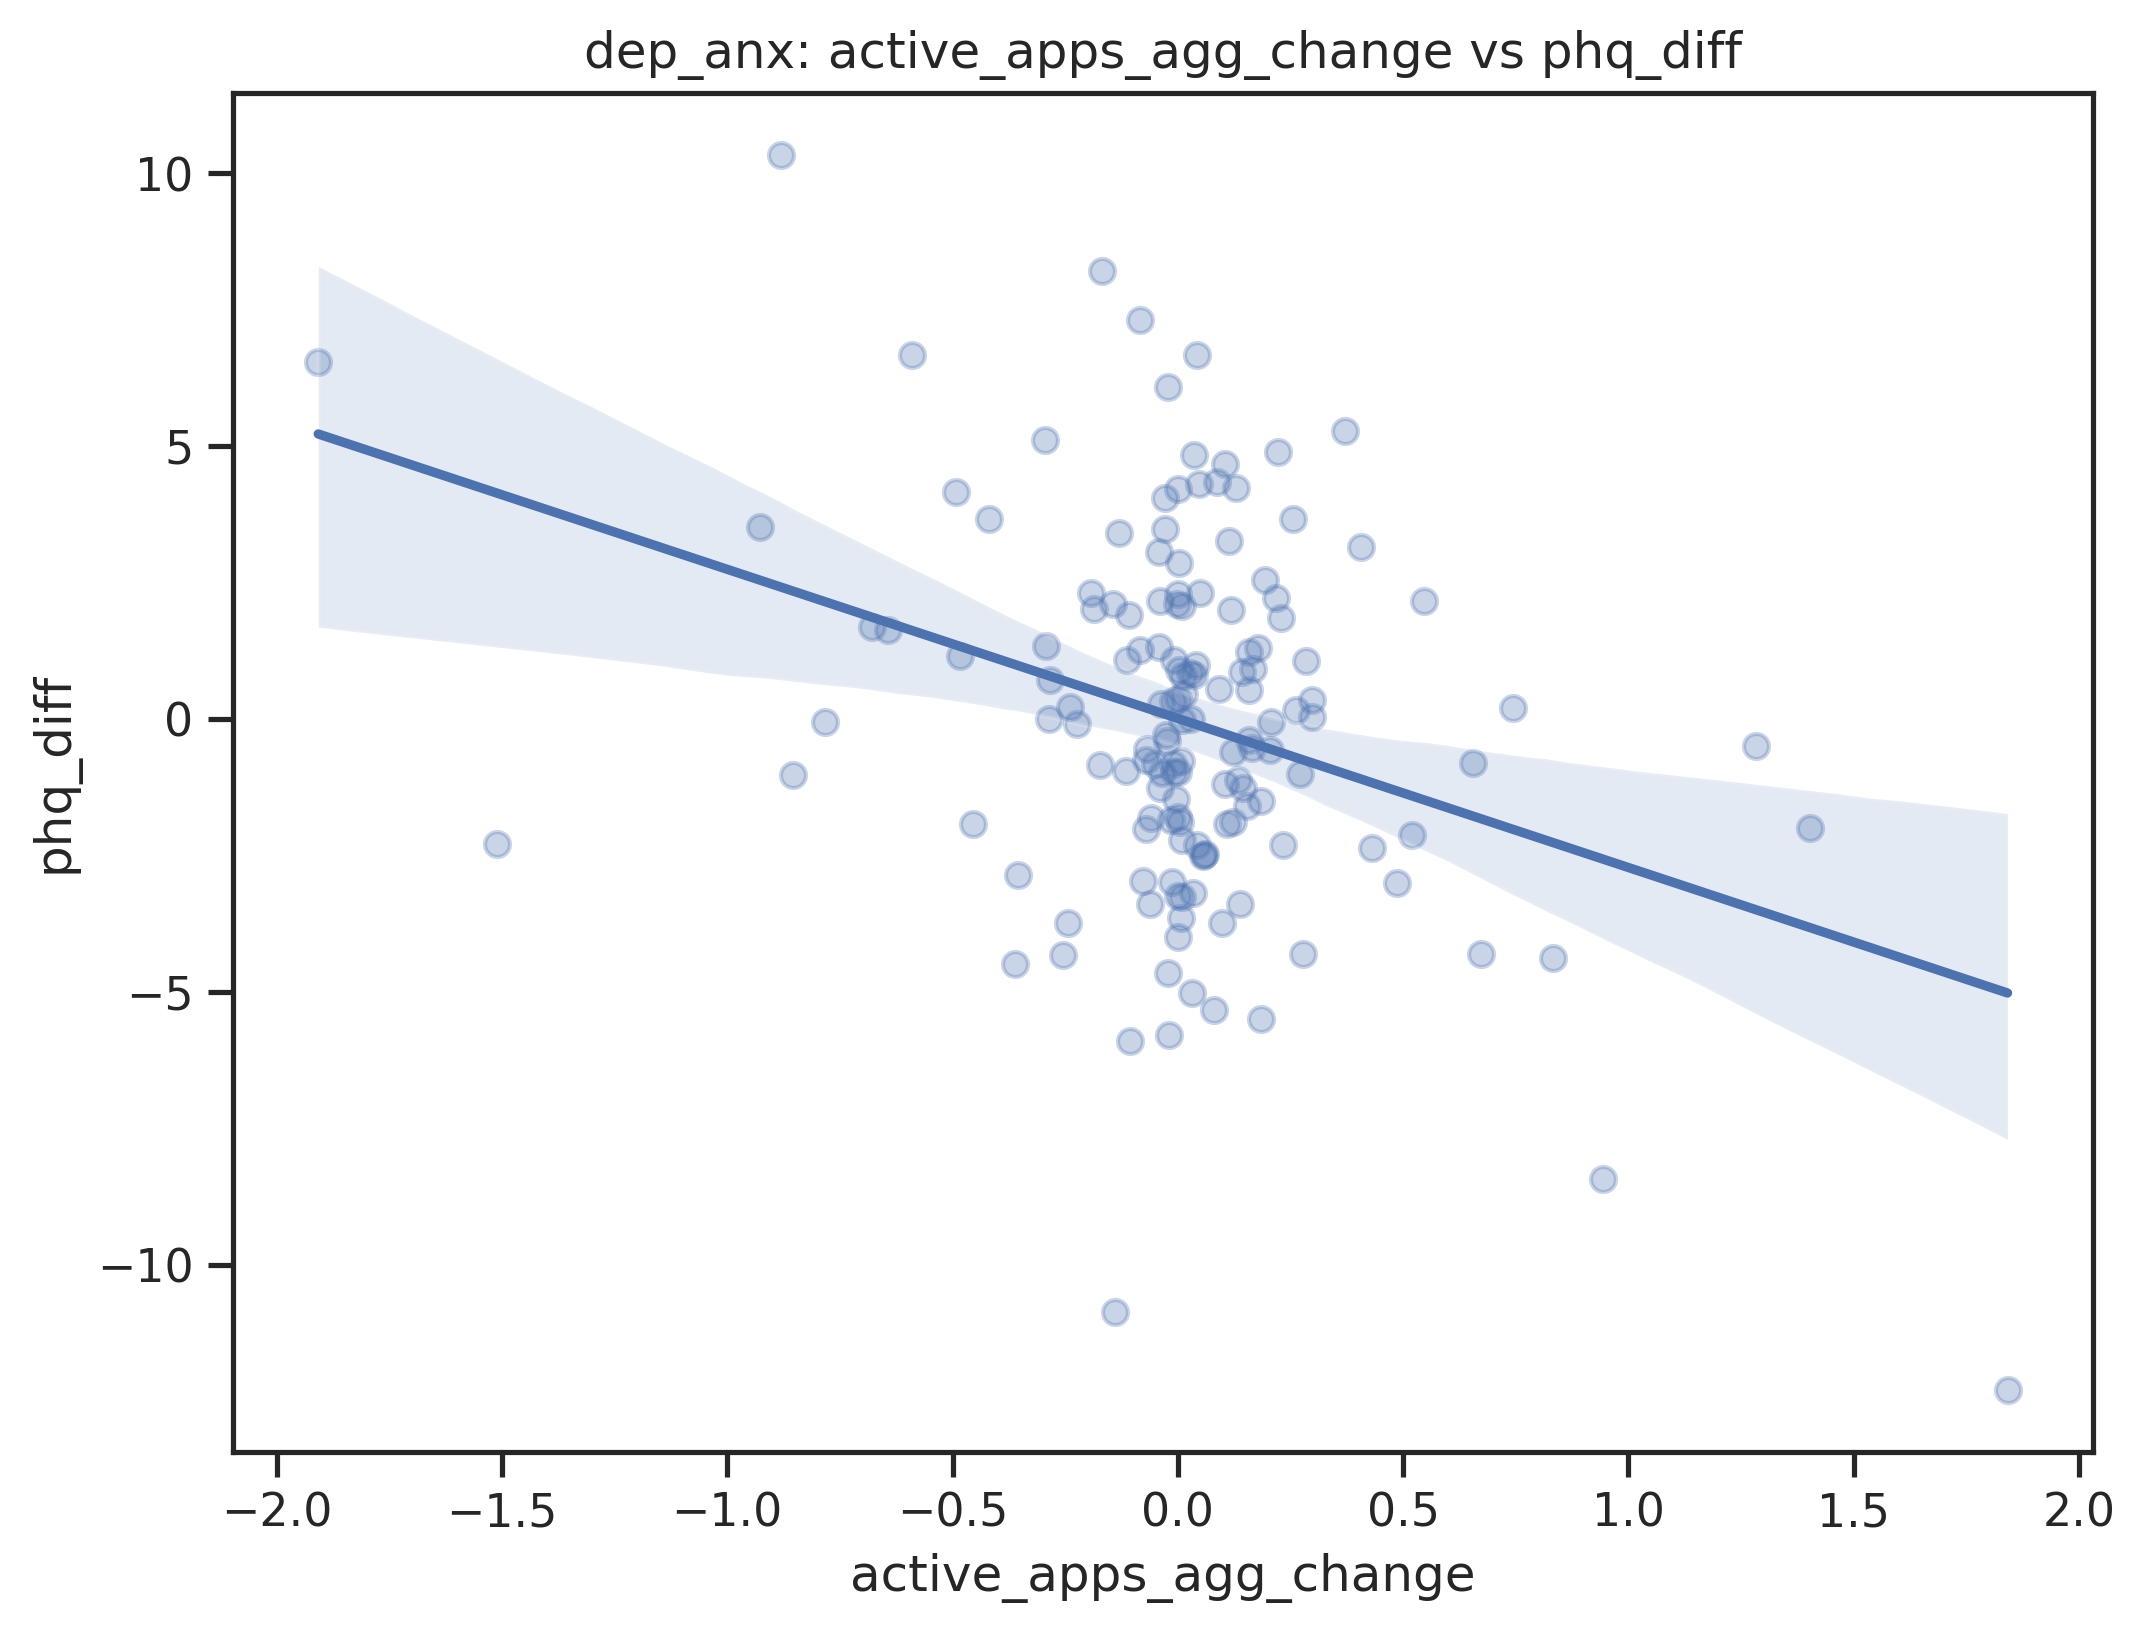

In [643]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_agg_df, 'dep_anx', (8,6))

# Reverse PHQ

## Full population

In [644]:
display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman')

## no_symp

In [646]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'no_symp']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## soc_anx

In [647]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'soc_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## gen_anx

In [648]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'gen_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

## dep_anx

In [649]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'dep_anx']
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

# Summary Tables of Significant Correlations

## SPIN

In [623]:
build_corr_table(gad_spin_corr, 'passive_apps_agg_change', 'spin_diff', 'passive app change to SPIN change')

In [624]:
build_corr_table(rev_gad_spin_corr, 'passive_apps_agg_change', 'spin_diff', 'SPIN change to passive app change')

## GAD

In [626]:
build_corr_table(gad_spin_corr, 'active_apps_agg_change', 'gad_diff', 'location PCA change to GAD change', method='spearman')

In [627]:
build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', 'gad_diff', 'GAD change to location PCA change', method='spearman')

## PHQ

In [629]:
build_corr_table(phq_corr, 'fus_pca1_agg_change', 'phq_diff', 'location PCA change to PHQ change')

In [630]:
build_corr_table(rev_phq_corr, 'fus_pca1_agg_change', 'phq_diff', 'PHQ change to location PCA change')

# Change over Time Periods Analysis

## Functions

In [650]:
def plot_over_time(cols, df, title, study_wks=[4,7,10,13,16], figsize=(8,6)):
    _, ax = plt.subplots(figsize=figsize)
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    

    plt.axhline(y=0, ls='--')
    plt.xlabel("study_wk")
    plt.xticks(study_wks)
    plt.title(title)
    plt.legend()
    
    return plt    

In [651]:
def build_time_corr_df(seq_df, target, feat_cols, study_wks=[4,7,10,13,16]):
    pair_df = pd.DataFrame()
    for idx in study_wks:
        sel_df = seq_df[seq_df['study_wk'] == idx]
        #sel_df = sel_df.dropna(subset=['date'])
        sel_df = sel_df[[target] + feat_cols]
        df = pg.pairwise_corr(sel_df, columns=[feat_cols, [target]], padjust="fdr_bh")
        df['idx'] = idx
        pair_df = pair_df.append(df)
        
    return pair_df

## PHQ

In [652]:
pop_df = build_time_corr_df(phq_corr, 'phq_diff', agg_cols_change)

In [653]:
pop_df[pop_df['X'] == 'fus_pca1_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

X         Y    n      r  idx     p-unc    p-corr  \
14  fus_pca1_agg_change  phq_diff  147 -0.037    4  0.658976  0.864497   
14  fus_pca1_agg_change  phq_diff  142 -0.246    7  0.003217  0.054694   
14  fus_pca1_agg_change  phq_diff  159 -0.154   10  0.052347  0.444952   
14  fus_pca1_agg_change  phq_diff  160 -0.008   13  0.918166  0.975552   
14  fus_pca1_agg_change  phq_diff  153 -0.142   16  0.080595  0.796960   

   p-adjust           CI95%  
14   fdr_bh    [-0.2, 0.13]  
14   fdr_bh  [-0.39, -0.08]  
14   fdr_bh     [-0.3, 0.0]  
14   fdr_bh   [-0.16, 0.15]  
14   fdr_bh   [-0.29, 0.02]

(-1, 0.6)

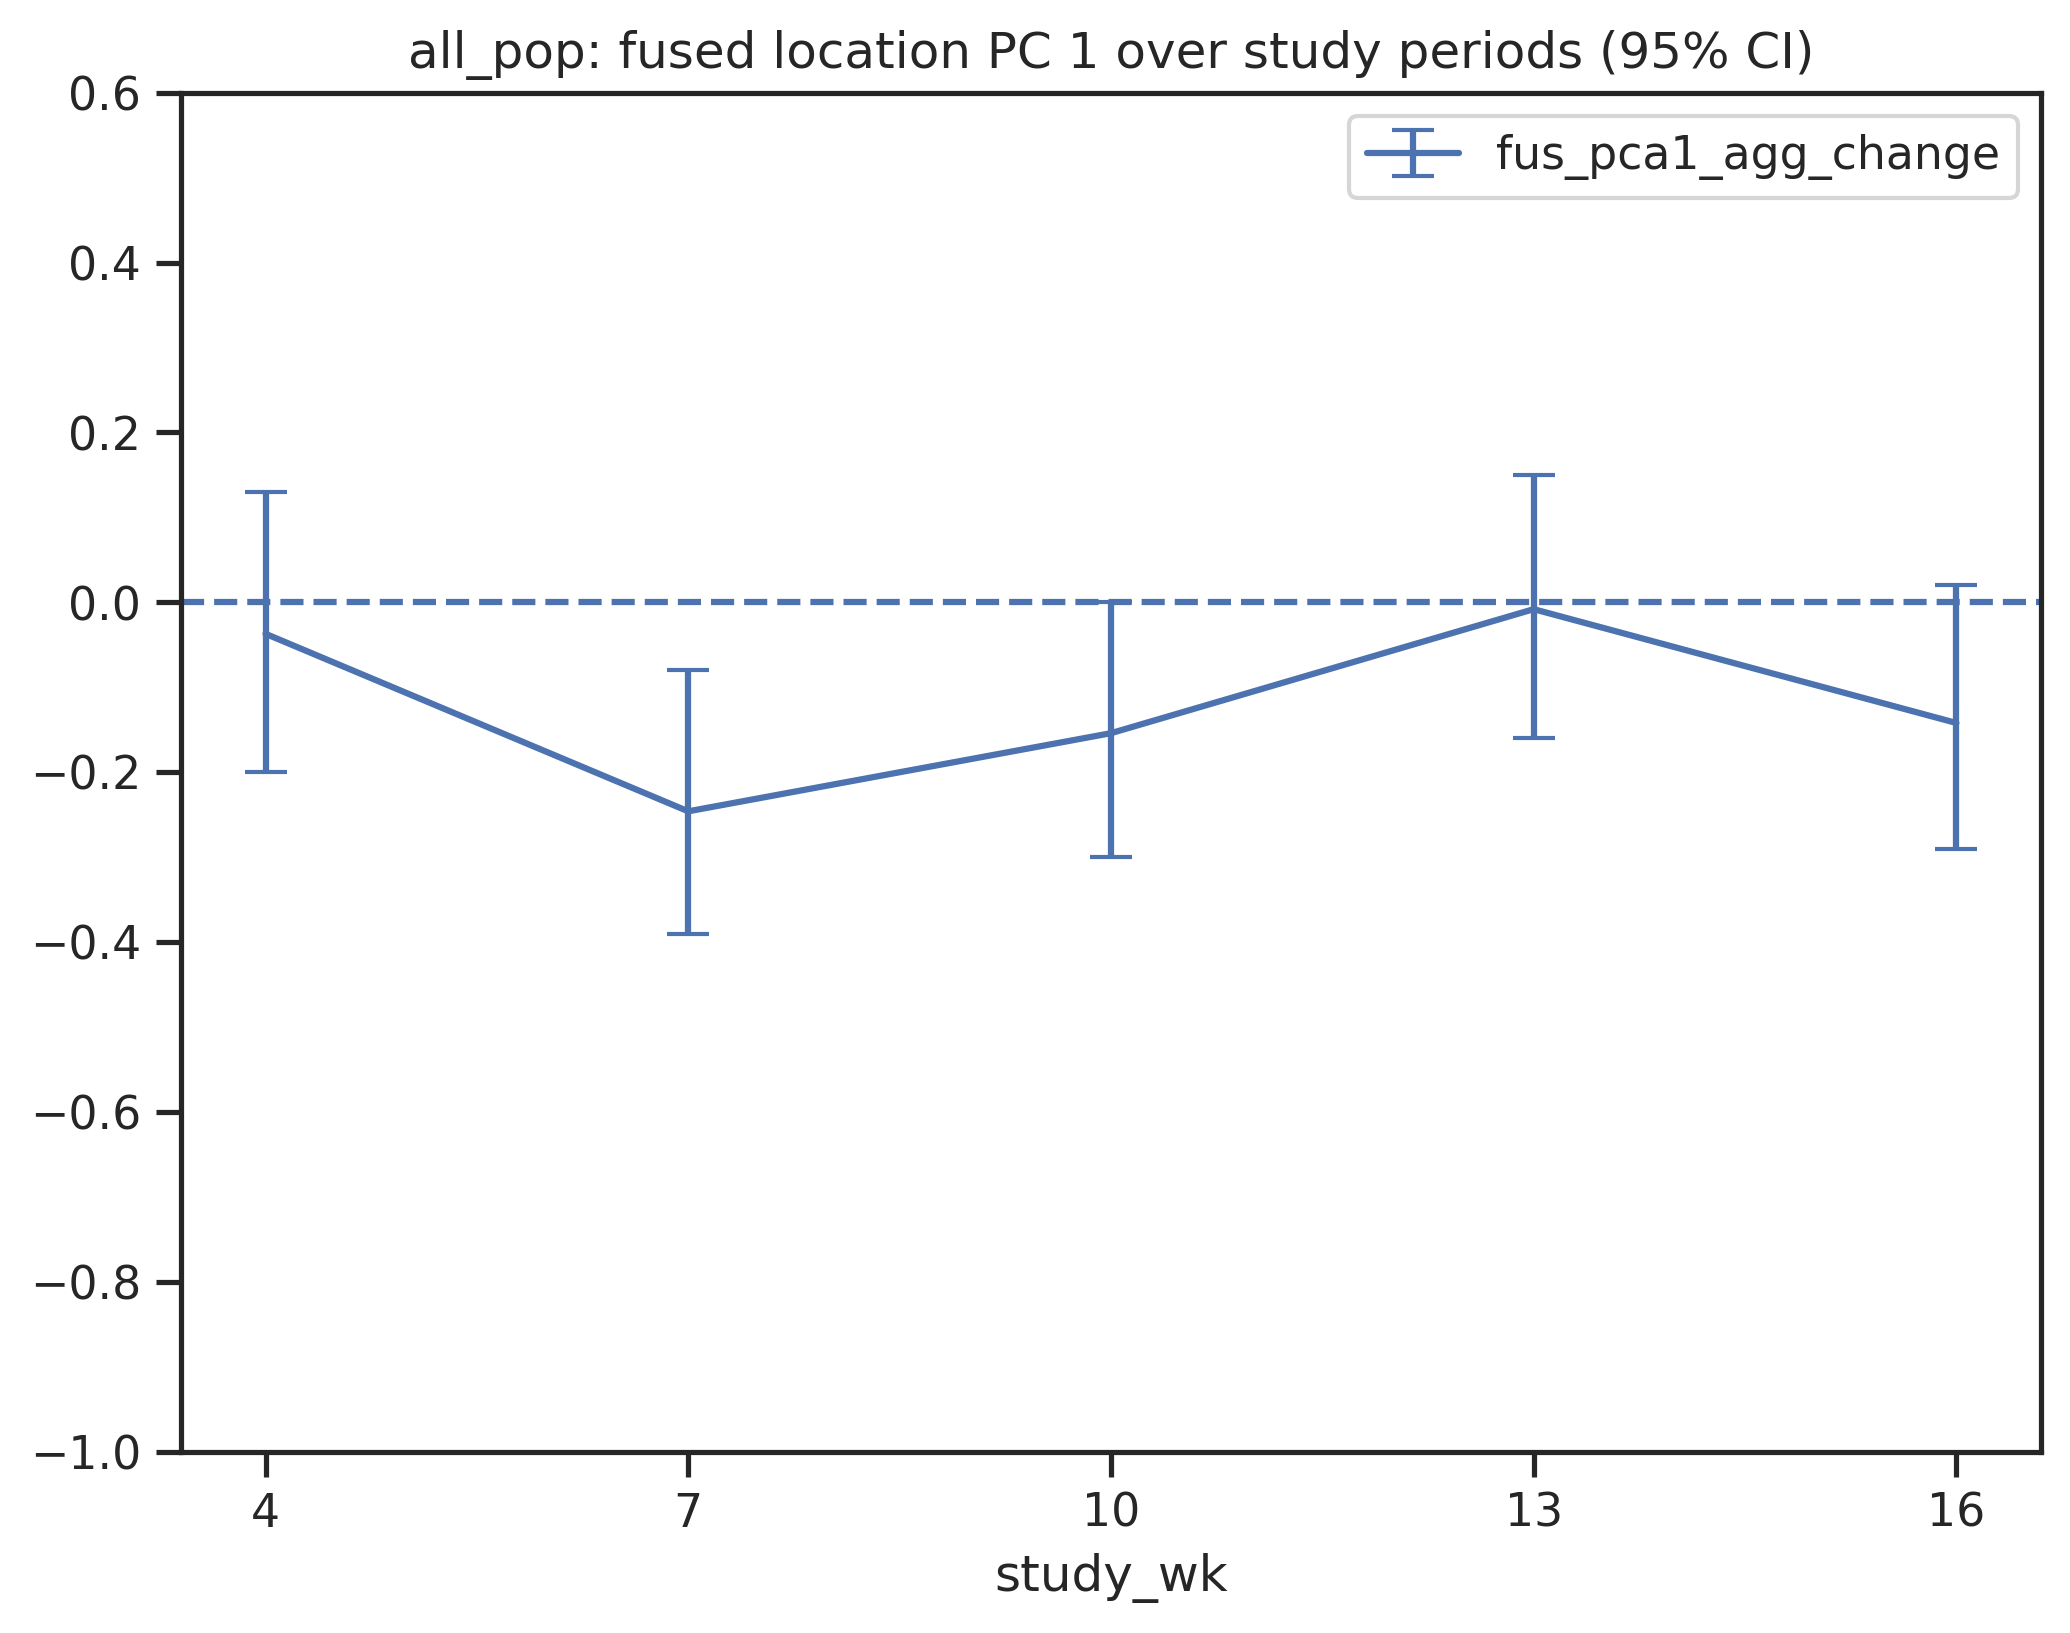

In [654]:
p = plot_over_time(['fus_pca1_agg_change'], pop_df, "all_pop: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

In [655]:
dep_anx_df = build_time_corr_df(phq_corr[phq_corr['baseline_cluster'] == 'dep_anx'], 'phq_diff', agg_cols_change)

In [656]:
dep_anx_df[dep_anx_df['X'] == 'fus_pca1_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

X         Y   n      r  idx     p-unc    p-corr  \
14  fus_pca1_agg_change  phq_diff  28 -0.394    4  0.038164  0.518786   
14  fus_pca1_agg_change  phq_diff  26 -0.670    7  0.000179  0.003037   
14  fus_pca1_agg_change  phq_diff  28 -0.406   10  0.031869  0.147447   
14  fus_pca1_agg_change  phq_diff  30  0.185   13  0.328274  0.767287   
14  fus_pca1_agg_change  phq_diff  30 -0.234   16  0.212701  0.602652   

   p-adjust           CI95%  
14   fdr_bh  [-0.67, -0.02]  
14   fdr_bh  [-0.84, -0.38]  
14   fdr_bh  [-0.68, -0.04]  
14   fdr_bh   [-0.19, 0.51]  
14   fdr_bh   [-0.55, 0.14]

(-1, 0.6)

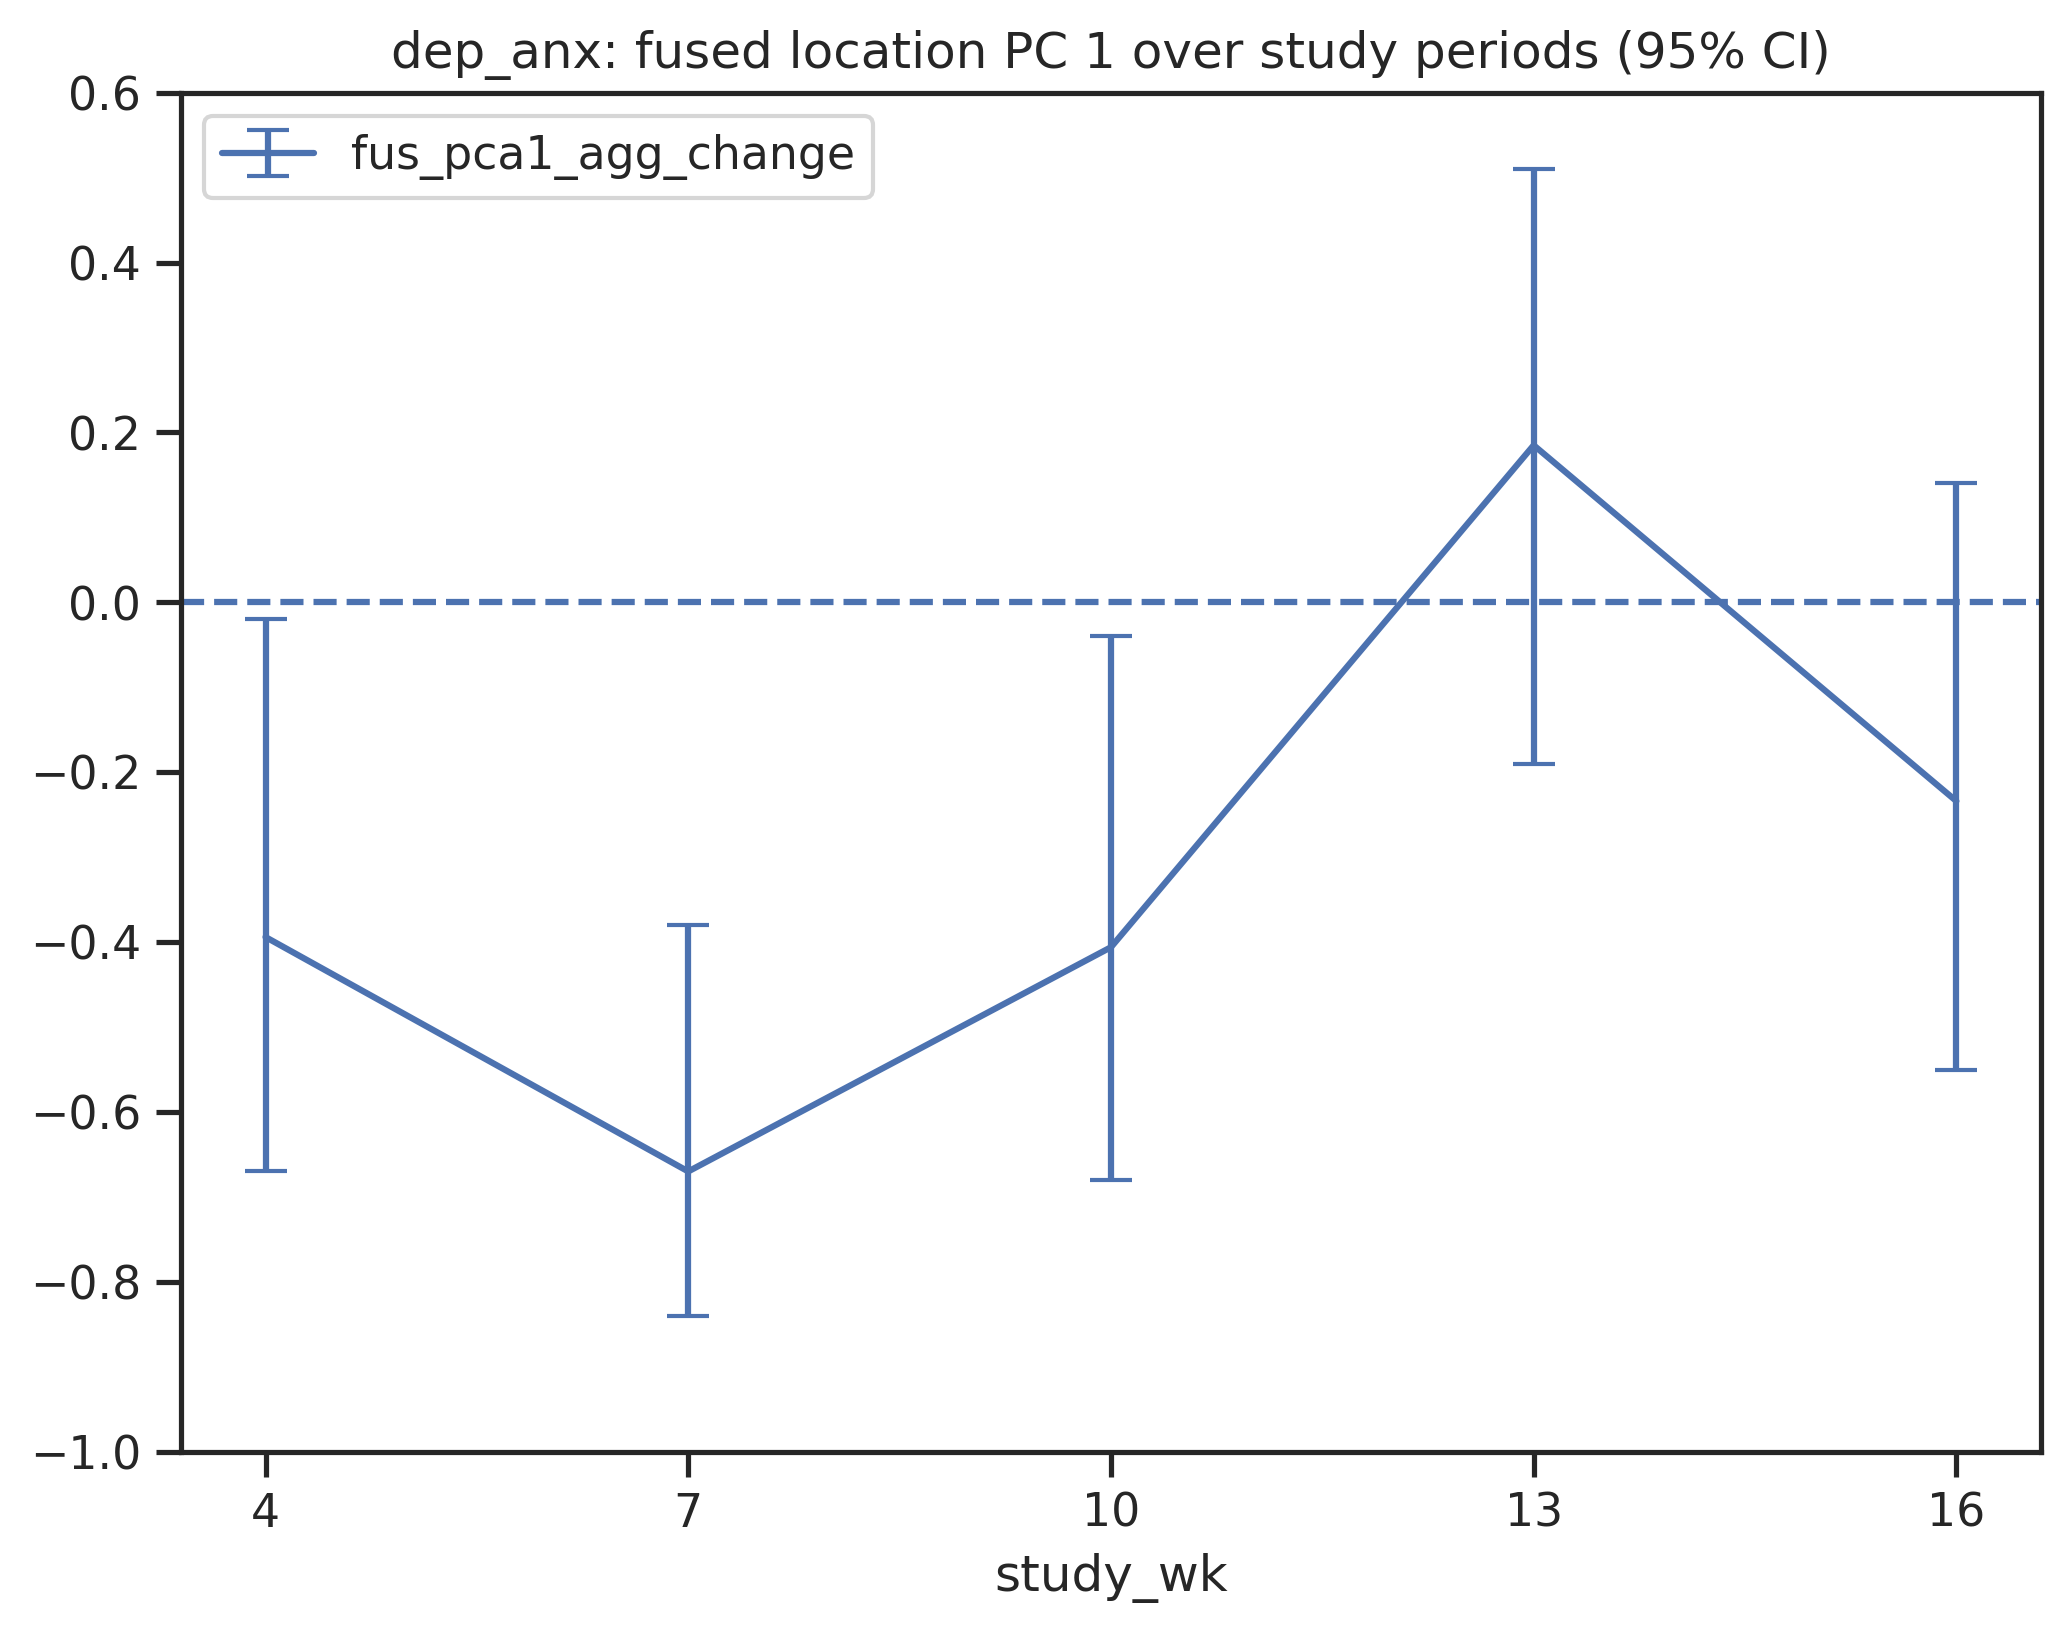

In [657]:
p = plot_over_time(['fus_pca1_agg_change'], dep_anx_df, "dep_anx: fused location PC 1 over study periods (95% CI)")
p.ylim(-1,0.6)

## GAD

In [658]:
gad_df = build_time_corr_df(gad_spin_corr, 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [659]:
gad_df[gad_df['X'] == 'social_apps_agg_change']

X         Y   method       tail    n      r  \
2  social_apps_agg_change  gad_diff  pearson  two-sided  191 -0.119   
2  social_apps_agg_change  gad_diff  pearson  two-sided  191  0.079   
2  social_apps_agg_change  gad_diff  pearson  two-sided  193 -0.023   
2  social_apps_agg_change  gad_diff  pearson  two-sided  193  0.054   

           CI95%     r2  adj_r2      z     p-unc    p-corr p-adjust   BF10  \
2  [-0.26, 0.02]  0.014   0.004 -0.120  0.101252  0.384823   fdr_bh  0.343   
2  [-0.06, 0.22]  0.006  -0.004  0.079  0.274619  0.553709   fdr_bh  0.164   
2  [-0.16, 0.12]  0.001  -0.010 -0.023  0.752218  0.850788   fdr_bh  0.095   
2  [-0.09, 0.19]  0.003  -0.008  0.054  0.456001  0.672111   fdr_bh  0.119   

   power  idx  
2  0.375    7  
2  0.194   10  
2  0.061   13  
2  0.116   16

In [661]:
dep_anx_gad_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx'], 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [662]:
dep_anx_gad_df[dep_anx_gad_df['X'] == 'social_apps_agg_change']

X         Y   method       tail   n      r  \
2  social_apps_agg_change  gad_diff  pearson  two-sided  35 -0.233   
2  social_apps_agg_change  gad_diff  pearson  two-sided  34  0.194   
2  social_apps_agg_change  gad_diff  pearson  two-sided  34 -0.182   
2  social_apps_agg_change  gad_diff  pearson  two-sided  35 -0.209   

           CI95%     r2  adj_r2      z     p-unc    p-corr p-adjust   BF10  \
2  [-0.53, 0.11]  0.054  -0.005 -0.237  0.177243  0.930010   fdr_bh  0.504   
2   [-0.15, 0.5]  0.038  -0.024  0.196  0.271485  0.592460   fdr_bh  0.381   
2  [-0.49, 0.17]  0.033  -0.029 -0.184  0.301913  0.978479   fdr_bh  0.356   
2  [-0.51, 0.13]  0.044  -0.016 -0.212  0.227154  0.689278   fdr_bh  0.424   

   power  idx  
2  0.275    7  
2  0.198   10  
2  0.180   13  
2  0.229   16

## SPIN

In [663]:
spin_df = build_time_corr_df(gad_spin_corr, 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [664]:
spin_df[spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

X          Y    n      r  idx     p-unc    p-corr  \
1  passive_apps_agg_change  spin_diff  191  0.094    7  0.195317  0.844363   
1  passive_apps_agg_change  spin_diff  191  0.090   10  0.214940  0.487346   
1  passive_apps_agg_change  spin_diff  193  0.130   13  0.072127  0.201666   
1  passive_apps_agg_change  spin_diff  192  0.100   16  0.166357  0.463296   

  p-adjust          CI95%  
1   fdr_bh  [-0.05, 0.23]  
1   fdr_bh  [-0.05, 0.23]  
1   fdr_bh  [-0.01, 0.27]  
1   fdr_bh  [-0.04, 0.24]

(-0.4, 1)

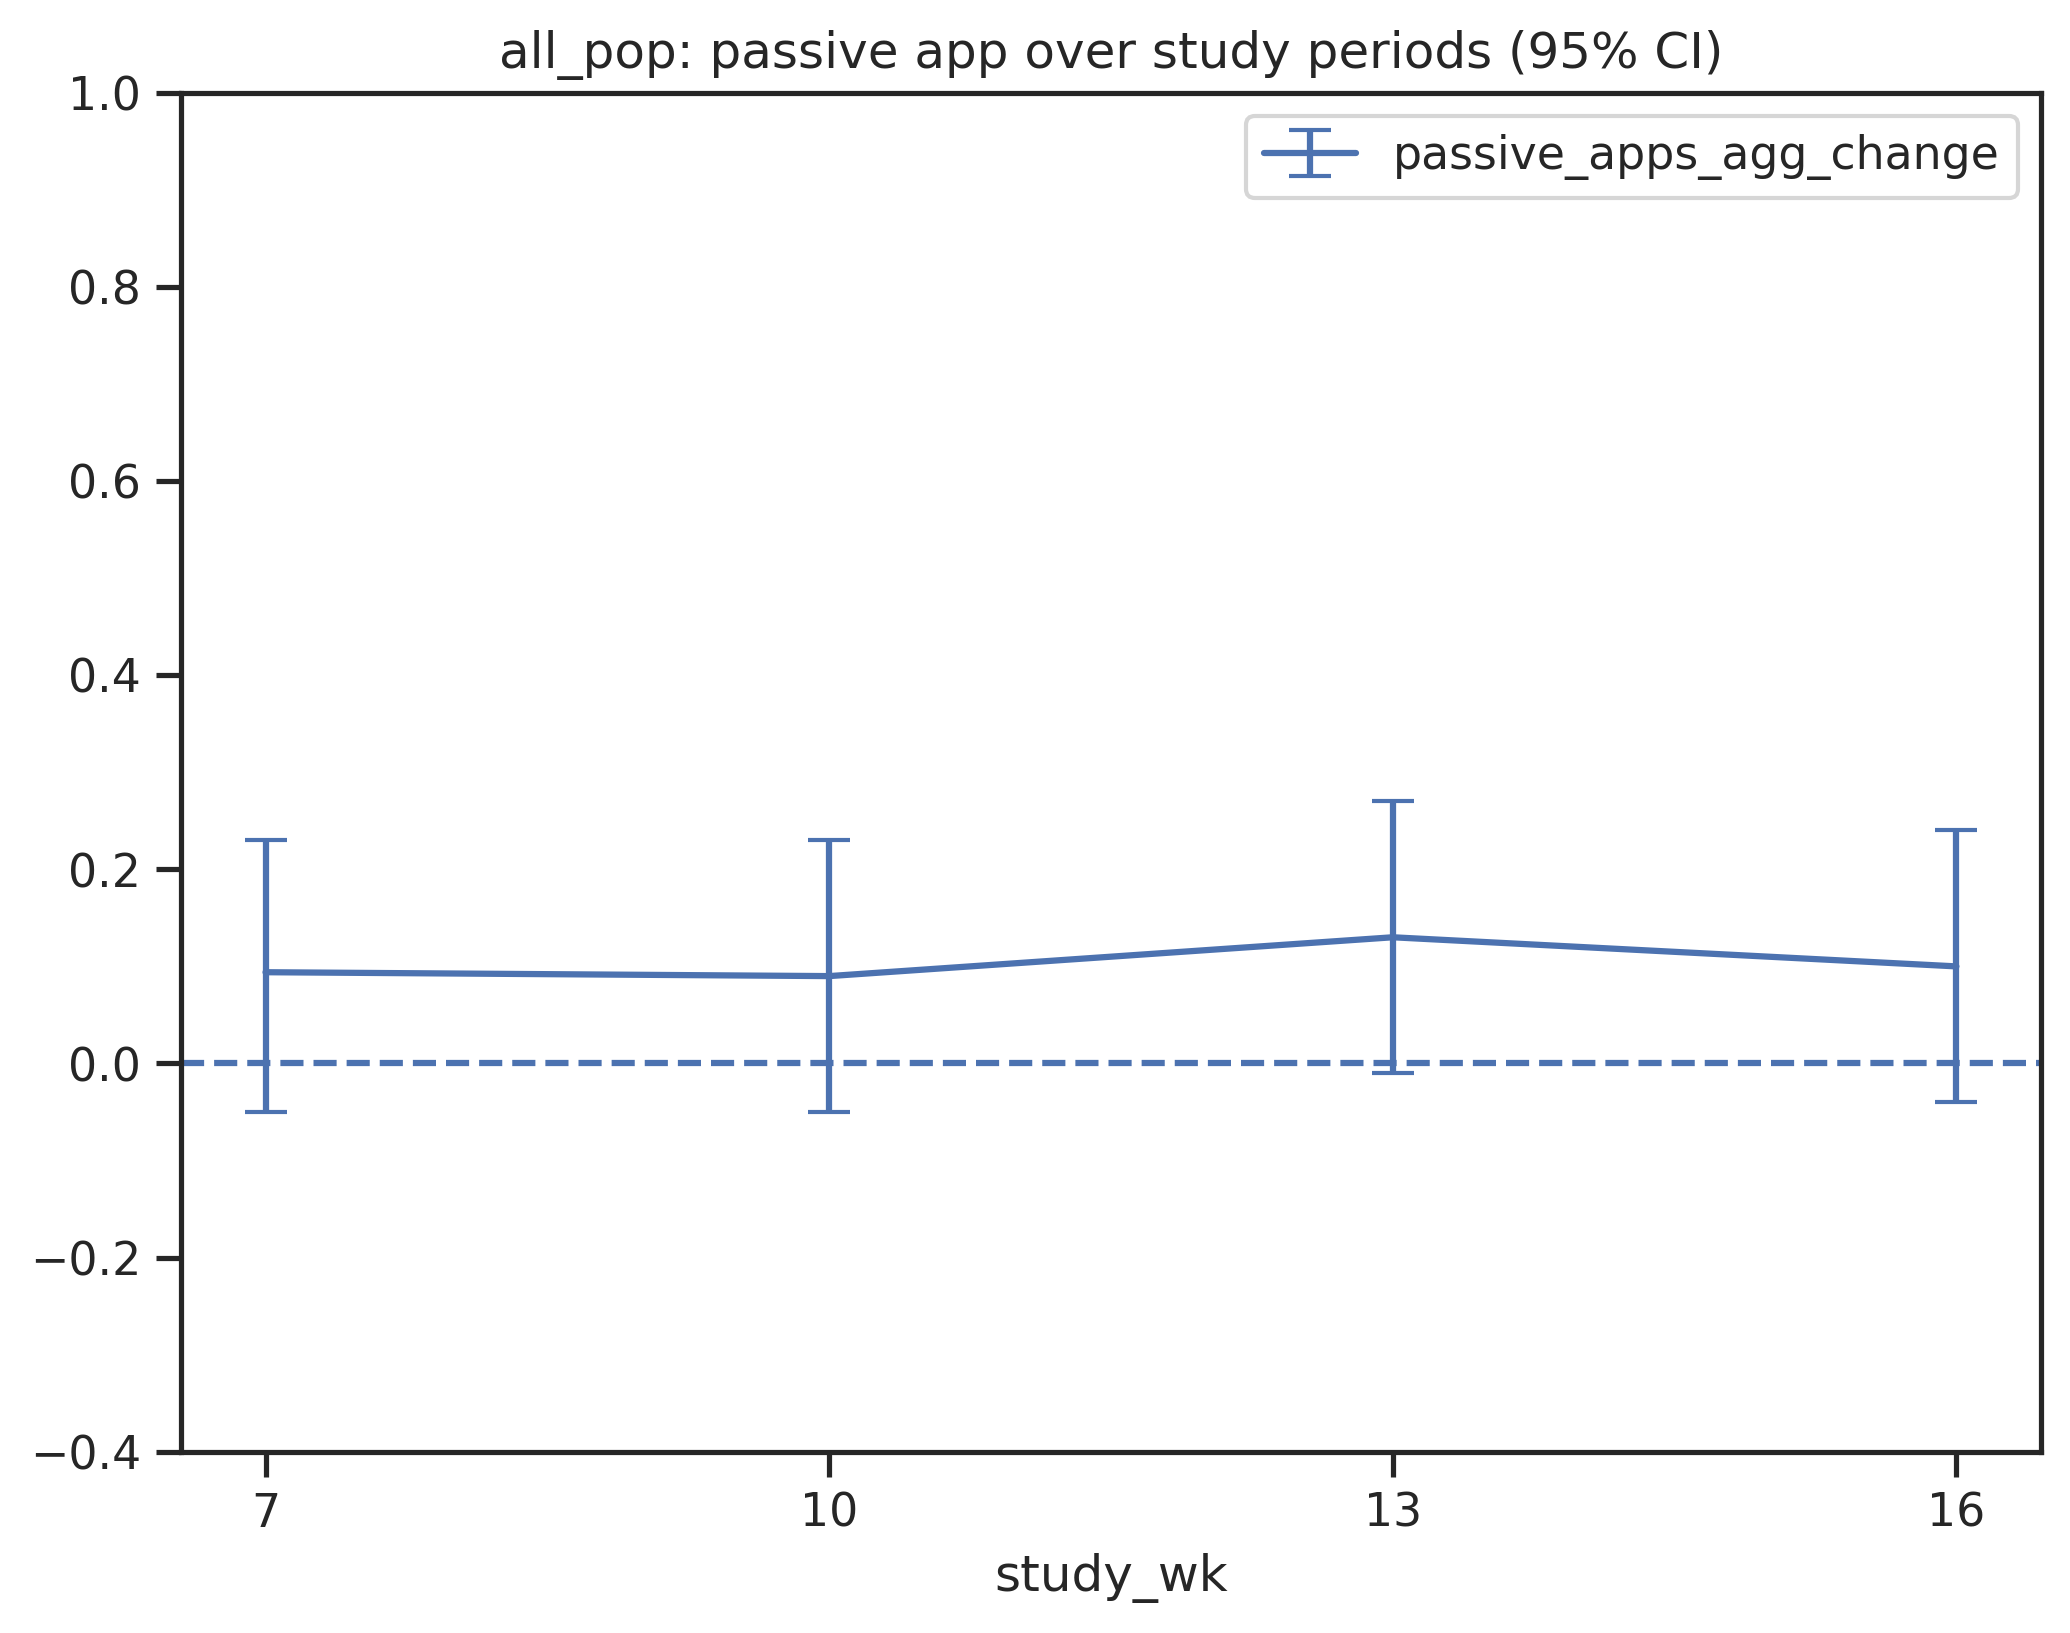

In [665]:
p = plot_over_time(['passive_apps_agg_change'], spin_df, "all_pop: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)

In [666]:
soc_anx_spin_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx'], 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [667]:
soc_anx_spin_df[dep_anx_spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

X          Y   n      r  idx     p-unc    p-corr  \
1  passive_apps_agg_change  spin_diff  50  0.222    7  0.121887  0.414415   
1  passive_apps_agg_change  spin_diff  50  0.079   10  0.585368  0.952609   
1  passive_apps_agg_change  spin_diff  51  0.415   13  0.002470  0.010498   
1  passive_apps_agg_change  spin_diff  51  0.209   16  0.140599  0.478038   

  p-adjust          CI95%  
1   fdr_bh  [-0.06, 0.47]  
1   fdr_bh   [-0.2, 0.35]  
1   fdr_bh   [0.16, 0.62]  
1   fdr_bh  [-0.07, 0.46]

(-0.4, 1)

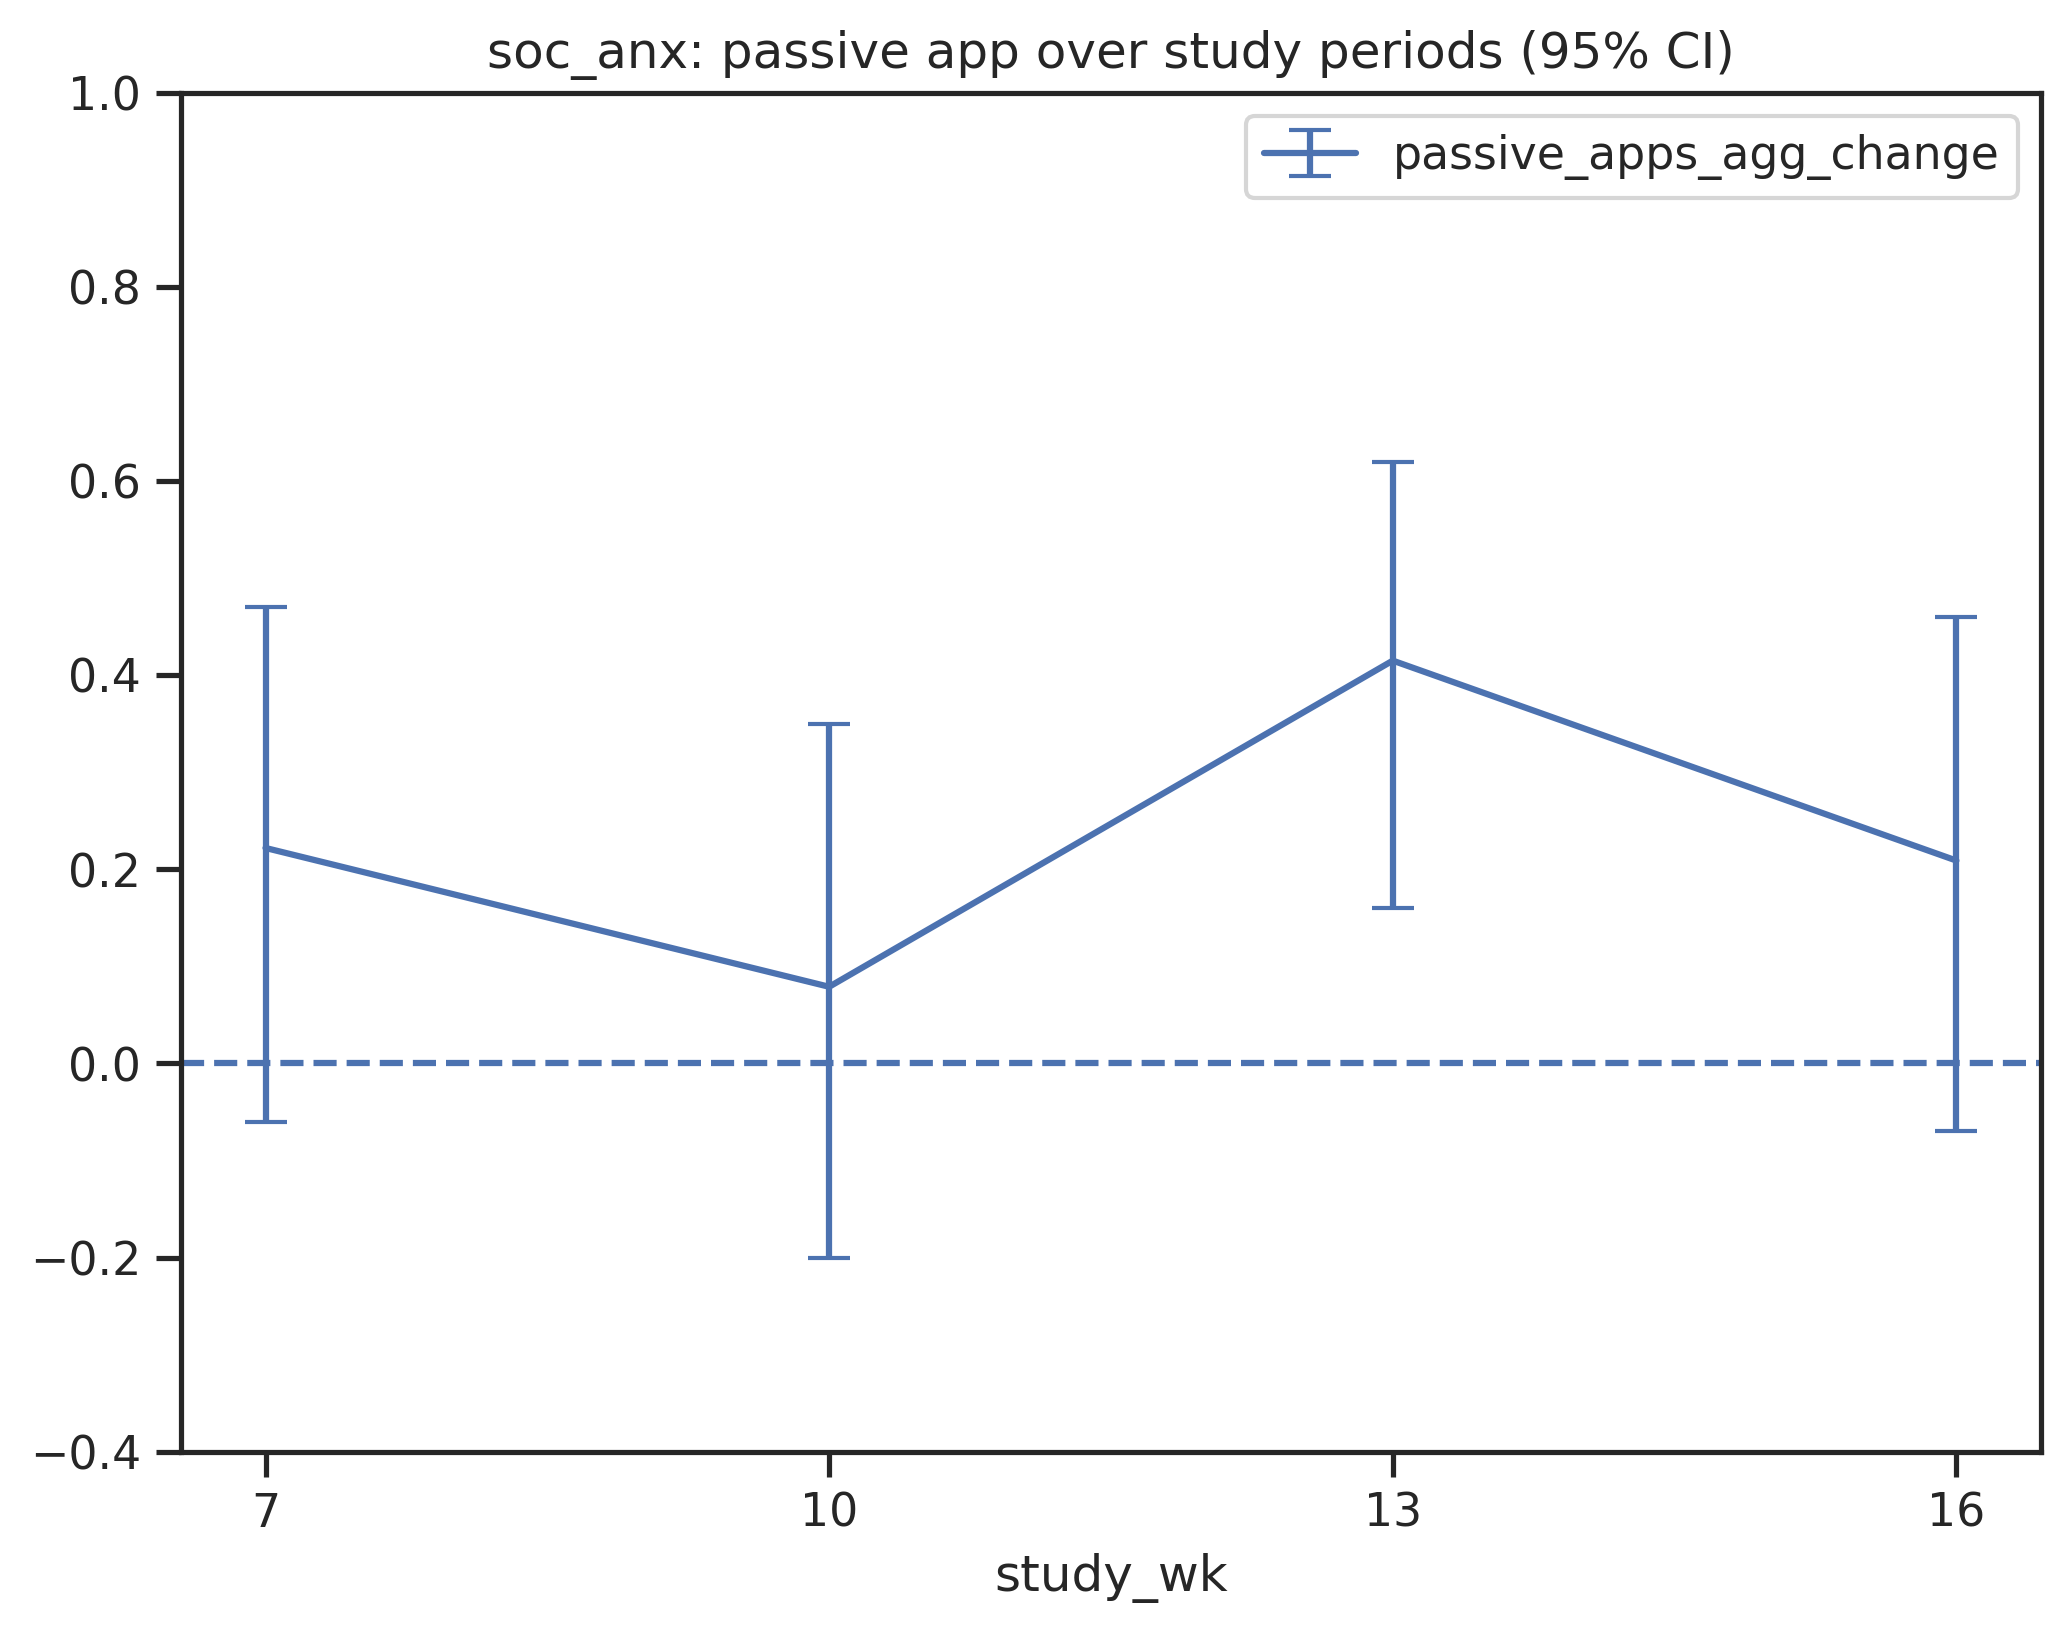

In [668]:
p = plot_over_time(['passive_apps_agg_change'], soc_anx_spin_df, "soc_anx: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)